In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from PIL import ImageFile

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Add
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'
FINAL_TEST_PATH = './stage2_test_final/'

#TRAIN_PATH = 'data/stage1_train/'
#TEST_PATH = 'data/stage1_test/'
#FINAL_TEST_PATH = 'data/stage2_test_final/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

2021-08-19 14:41:15.441184: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
os.getcwd()

'/home/borin/IcFlorindo2020/UnetNuclei'

In [3]:
# Get train and test IDs
train_ids = sorted(next(os.walk(TRAIN_PATH))[1])
test_ids = sorted(next(os.walk(TEST_PATH))[1])
final_test_ids = sorted(next(os.walk(FINAL_TEST_PATH))[1])

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

Getting and resizing train images and masks ... 


In [5]:
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):

    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    #Append image to numpy array for train dataset
    X_train[n] = img

    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)

        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        mask = np.maximum(mask, mask_)

    #Append mask to numpy array for train dataset
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_

    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]

    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])

    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    #Append image to numpy array for test dataset
    X_test[n] = img

print('Done!')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 670/670 [03:42<00:00,  3.01it/s]

Getting and resizing test images ... 



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 55.88it/s]

Done!


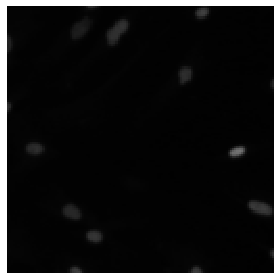

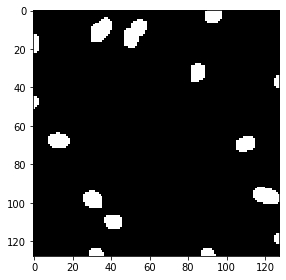

In [6]:
#Check if training data looks all right
ix = random.randint(0, X_train.shape[0])

plt.axis('off')
imshow(X_train[ix])
plt.show()

imshow(np.squeeze(Y_train[ix]))
plt.show()

In [7]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

2021-08-19 14:45:00.843097: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-19 14:45:00.918769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-19 14:45:00.920393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.86GHz coreCount: 15 deviceMemorySize: 7.91GiB deviceMemoryBandwidth: 238.66GiB/s
2021-08-19 14:45:00.920484: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-19 14:45:00.928625: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-19 14:45:00.928818: I tensorflow/stream_executor/platform/de

In [8]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [9]:
# Fit model
earlystopper = EarlyStopping(patience=15, verbose=1)
checkpointer = ModelCheckpoint('model_unet_checkpoint.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=100,
                    callbacks=[earlystopper, checkpointer])
model.save("model.h5")

2021-08-19 14:45:01.973967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-19 14:45:01.991478: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3999980000 Hz


Epoch 1/100


2021-08-19 14:45:03.497166: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-08-19 14:45:03.725597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8101
2021-08-19 14:45:03.967633: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-19 14:45:04.149999: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


38/38 [==============================] - 8s 128ms/step - loss: 0.3317 - accuracy: 0.8885 - val_loss: 4.3456 - val_accuracy: 0.2425

Epoch 00001: val_loss improved from inf to 4.34555, saving model to model_unet_checkpoint.h5
Epoch 2/100
38/38 [==============================] - 3s 83ms/step - loss: 0.1705 - accuracy: 0.9563 - val_loss: 2.1117 - val_accuracy: 0.4112

Epoch 00002: val_loss improved from 4.34555 to 2.11172, saving model to model_unet_checkpoint.h5
Epoch 3/100
38/38 [==============================] - 3s 82ms/step - loss: 0.1383 - accuracy: 0.9615 - val_loss: 0.6082 - val_accuracy: 0.8170

Epoch 00003: val_loss improved from 2.11172 to 0.60818, saving model to model_unet_checkpoint.h5
Epoch 4/100
38/38 [==============================] - 3s 82ms/step - loss: 0.1363 - accuracy: 0.9589 - val_loss: 1.1980 - val_accuracy: 0.4894

Epoch 00004: val_loss did not improve from 0.60818
Epoch 5/100
38/38 [==============================] - 3s 83ms/step - loss: 0.1260 - accuracy: 0.9604 -

38/38 [==============================] - 3s 82ms/step - loss: 0.0725 - accuracy: 0.9717 - val_loss: 0.0773 - val_accuracy: 0.9693

Epoch 00039: val_loss did not improve from 0.06455
Epoch 40/100
38/38 [==============================] - 3s 82ms/step - loss: 0.0708 - accuracy: 0.9724 - val_loss: 0.0691 - val_accuracy: 0.9720

Epoch 00040: val_loss did not improve from 0.06455
Epoch 41/100
38/38 [==============================] - 3s 82ms/step - loss: 0.0693 - accuracy: 0.9728 - val_loss: 0.0657 - val_accuracy: 0.9729

Epoch 00041: val_loss did not improve from 0.06455
Epoch 42/100
38/38 [==============================] - 3s 83ms/step - loss: 0.0686 - accuracy: 0.9731 - val_loss: 0.0638 - val_accuracy: 0.9736

Epoch 00042: val_loss improved from 0.06455 to 0.06380, saving model to model_unet_checkpoint.h5
Epoch 43/100
38/38 [==============================] - 3s 83ms/step - loss: 0.0671 - accuracy: 0.9728 - val_loss: 0.0673 - val_accuracy: 0.9726

Epoch 00043: val_loss did not improve from 

In [10]:
def plot_learning_curve(history):

    plt.figure(figsize = (12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("acurácia do modelo", fontsize = 20)
    plt.ylabel("acurácia (em %)", fontsize = 16)
    plt.xlabel("época", fontsize = 16)
    plt.legend(["treino", "teste"], loc = "upper left")
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("perda do modelo", fontsize = 20)
    plt.ylabel("valor perda", fontsize = 16)
    plt.xlabel("época", fontsize = 16)
    plt.legend(["treino", "teste"], loc = "upper left")
    plt.savefig("./ResultadosPlots/curve_UnetNuclei.png")

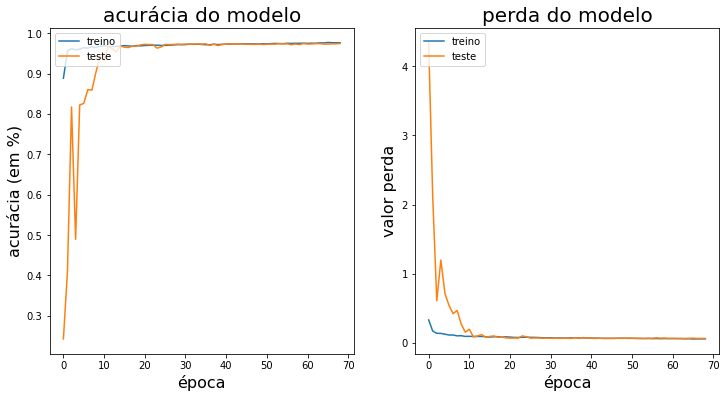

In [11]:
plot_learning_curve(results)
plt.show()

In [12]:
# Predict on train, val and test
#model = load_model("model.h5")
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test_t)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test_t[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))

3/3 [==============================] - 0s 156ms/step


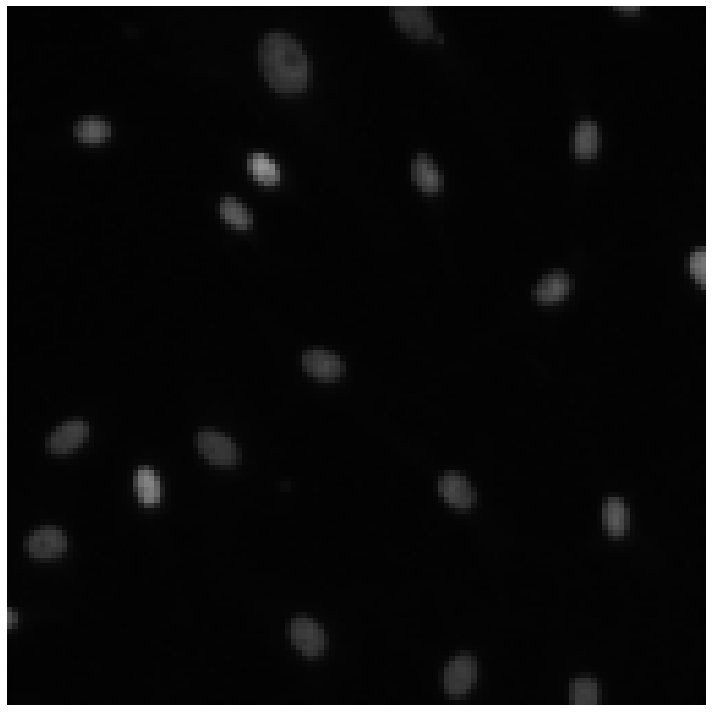

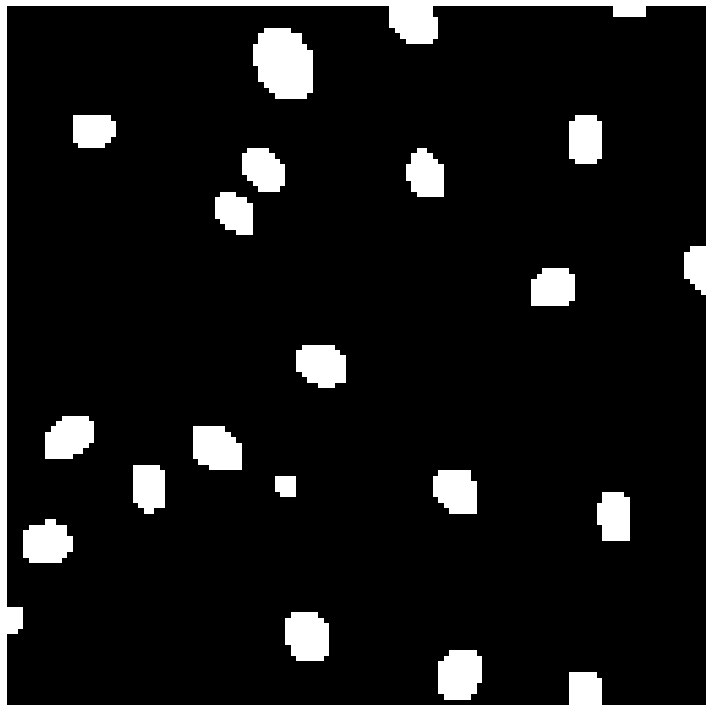

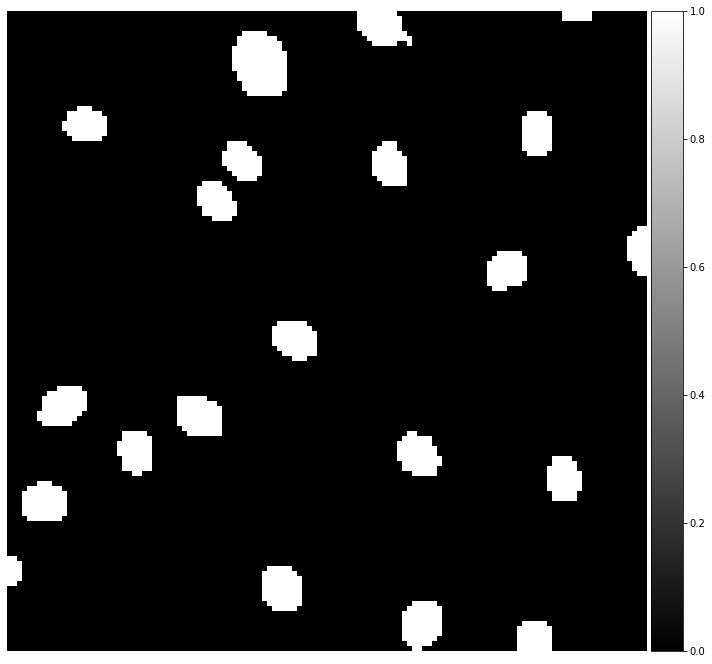

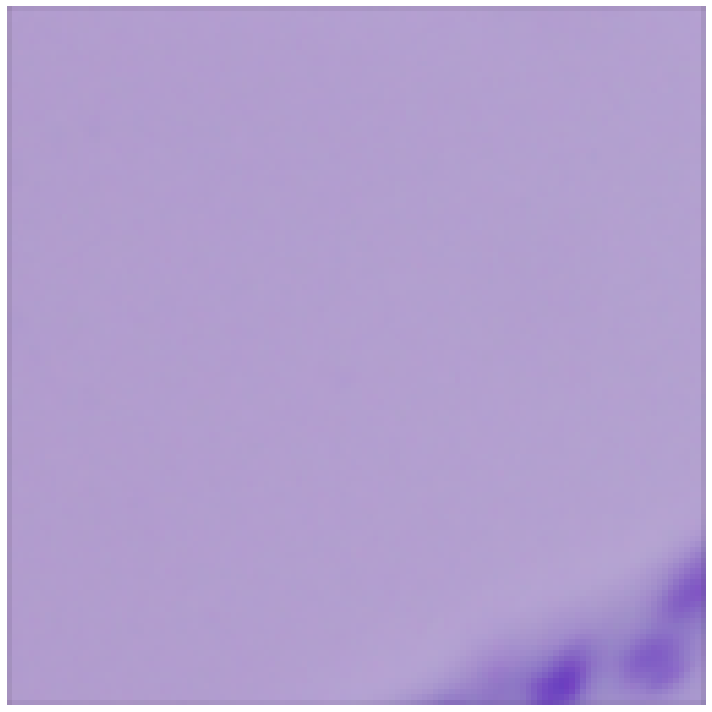

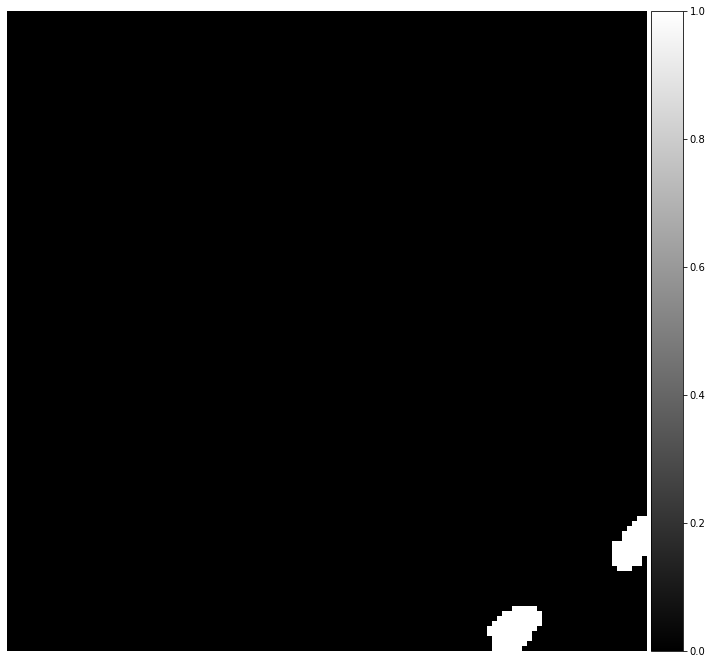

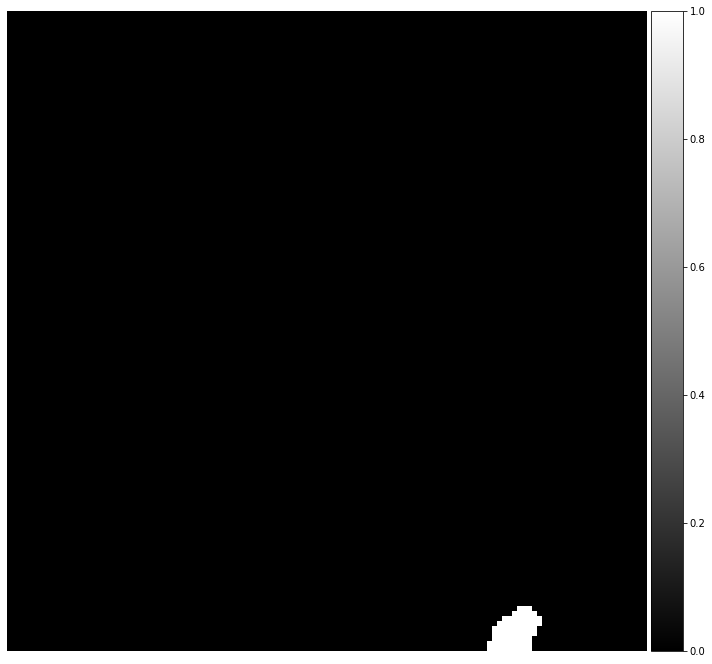

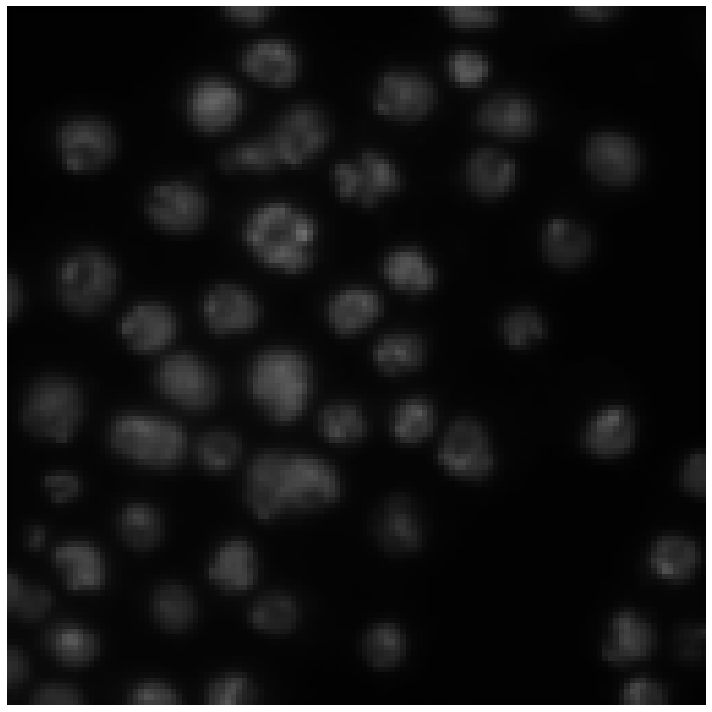

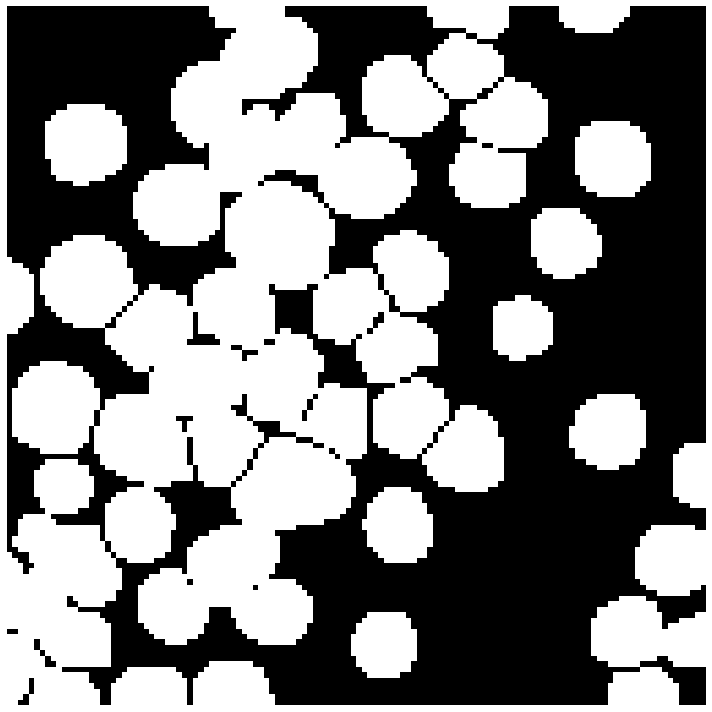

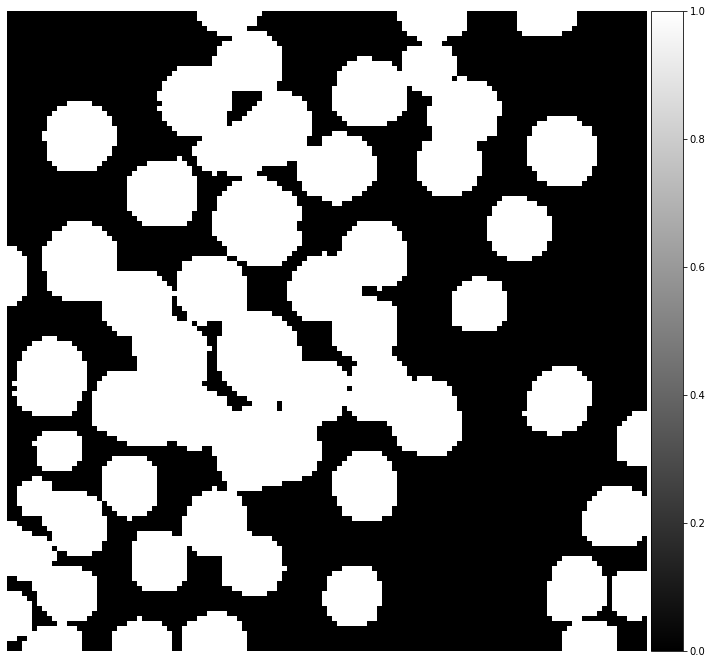

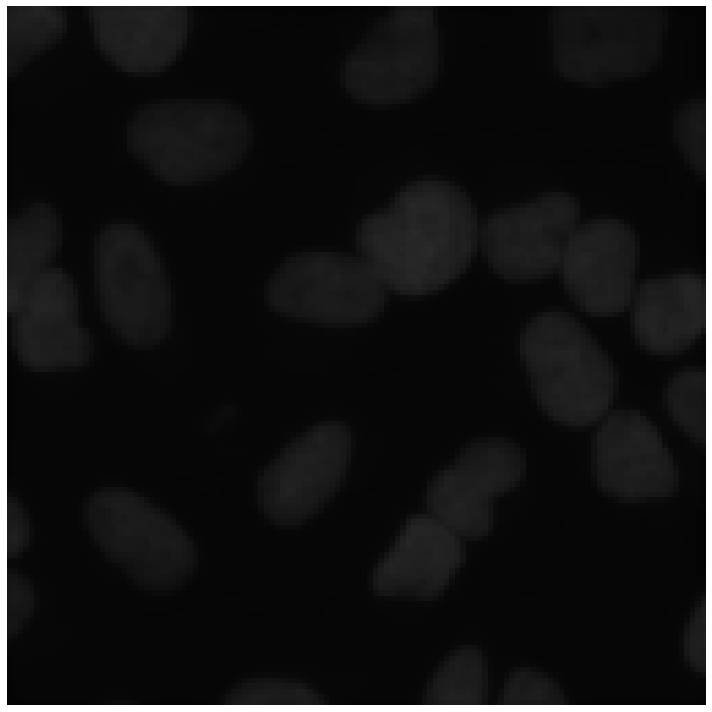

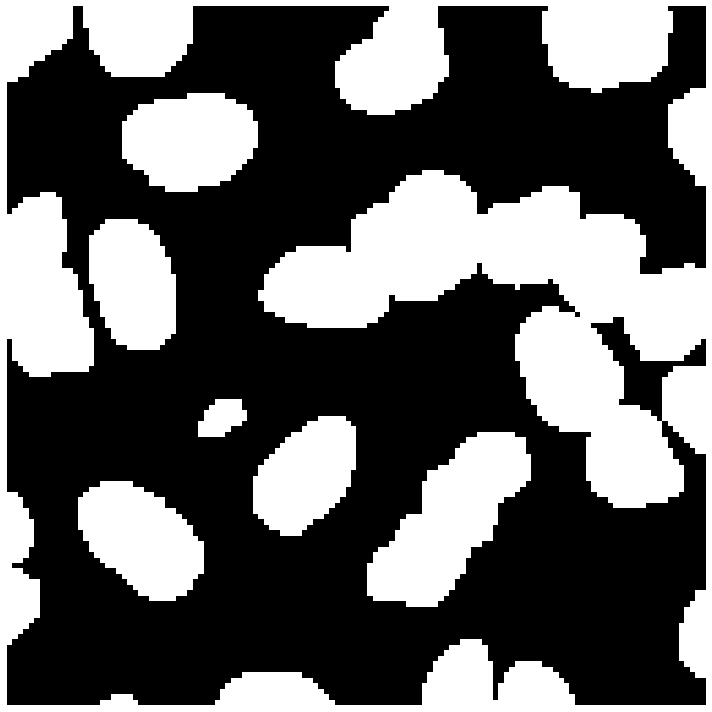

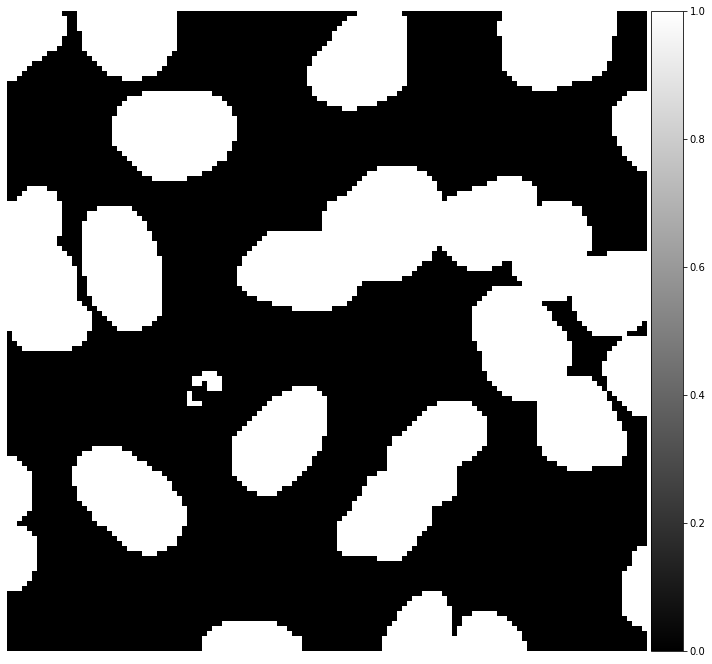

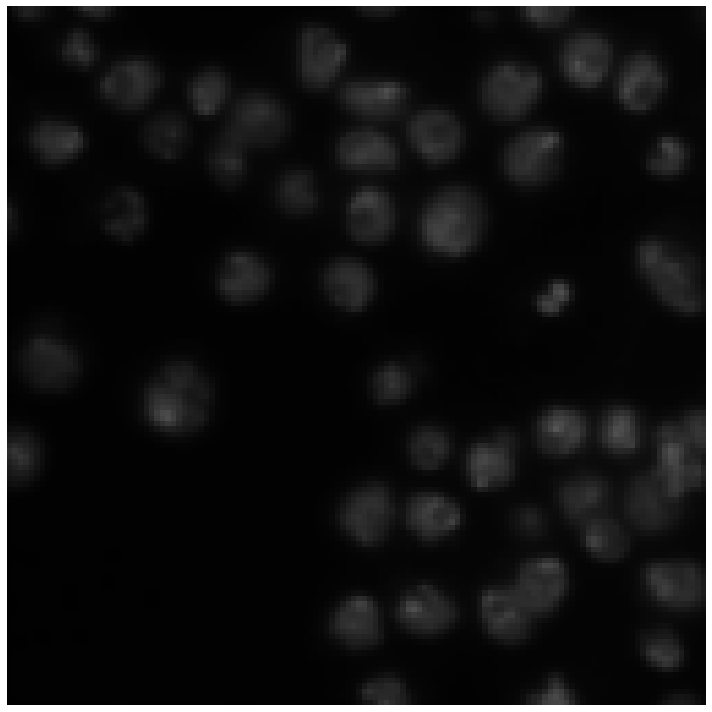

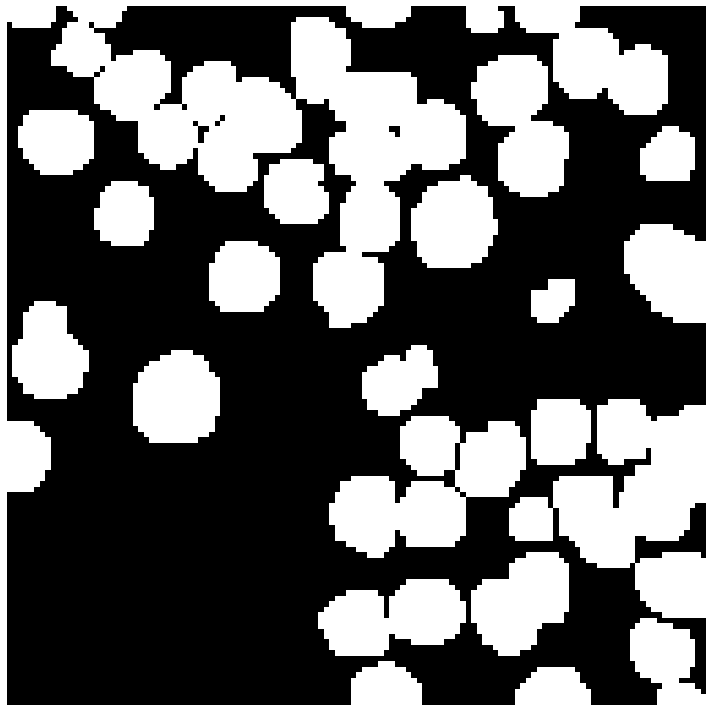

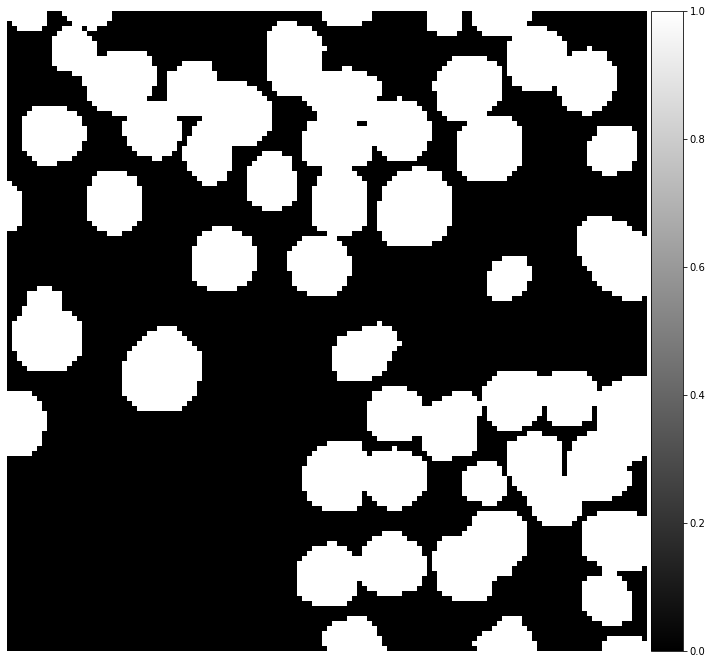

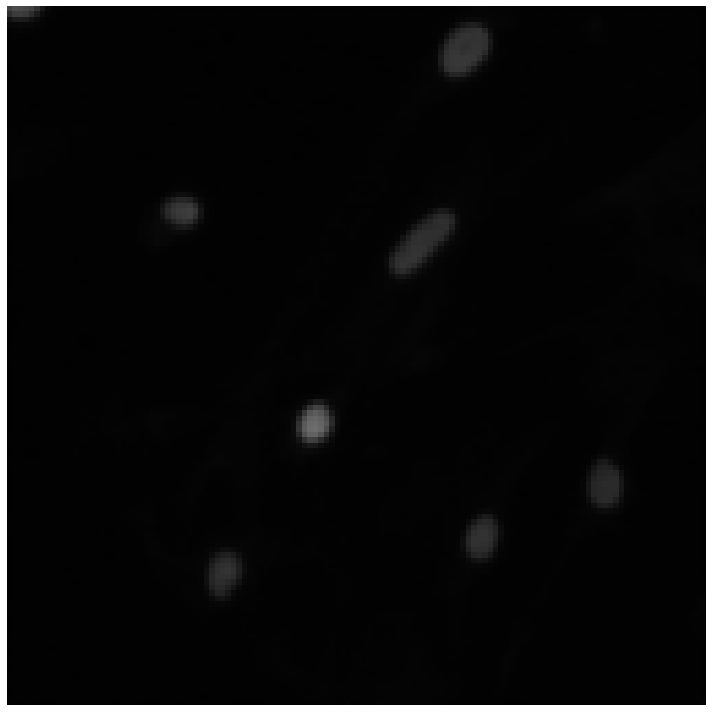

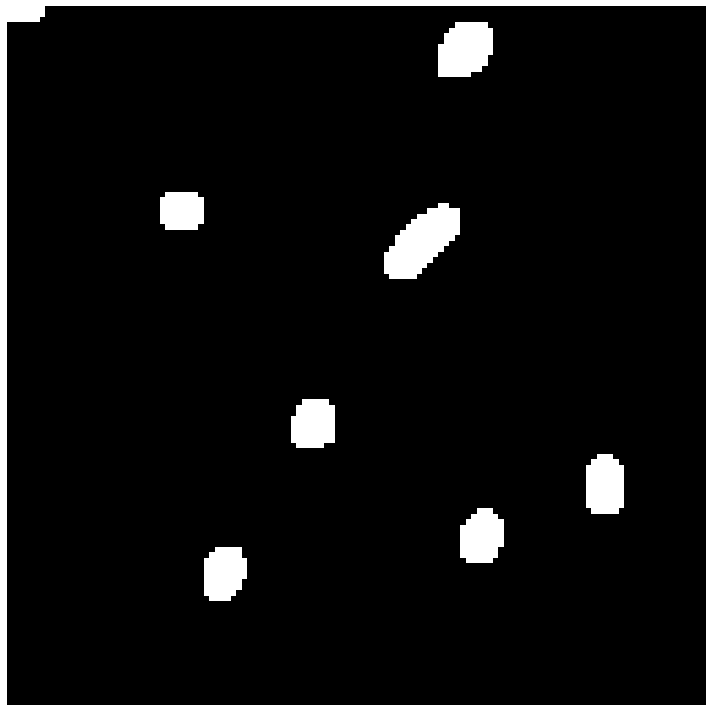

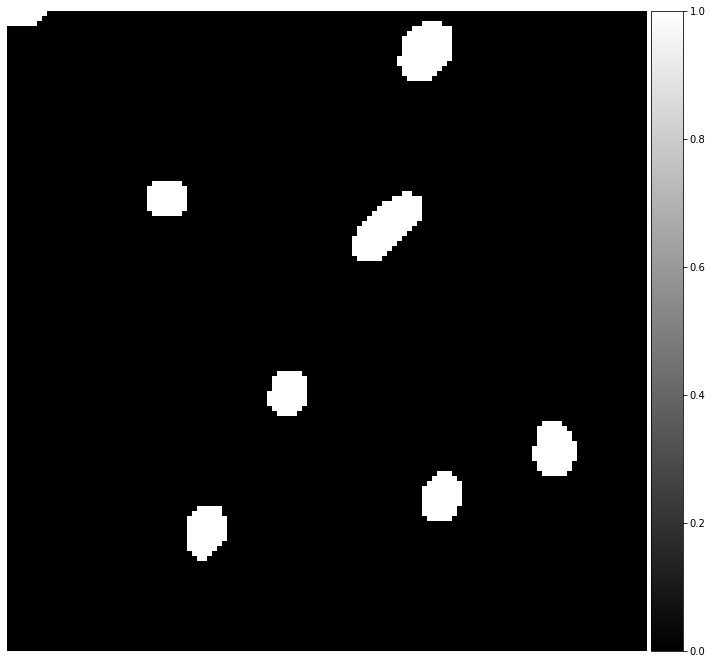

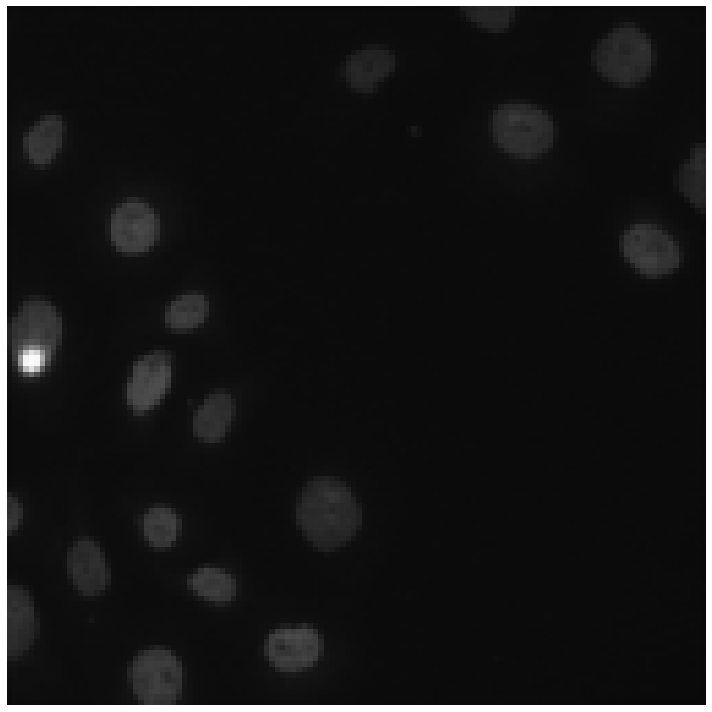

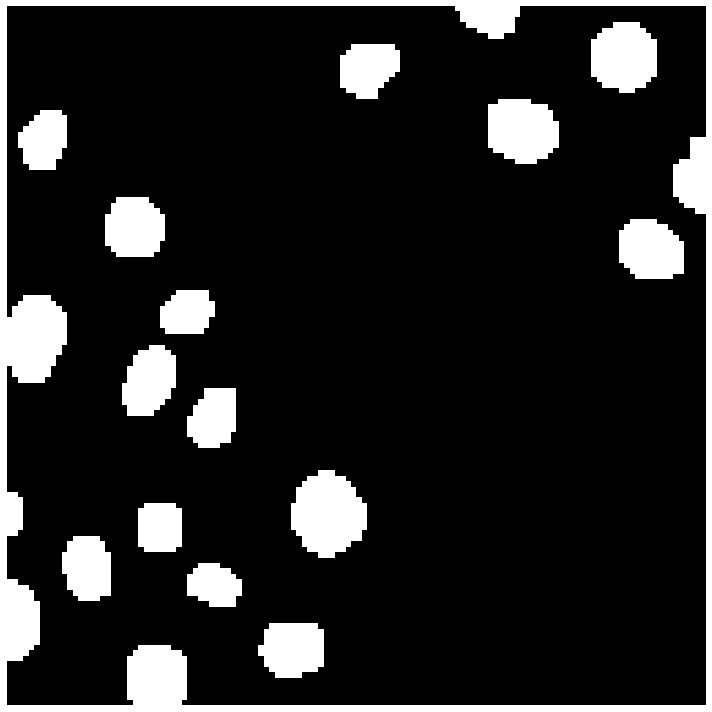

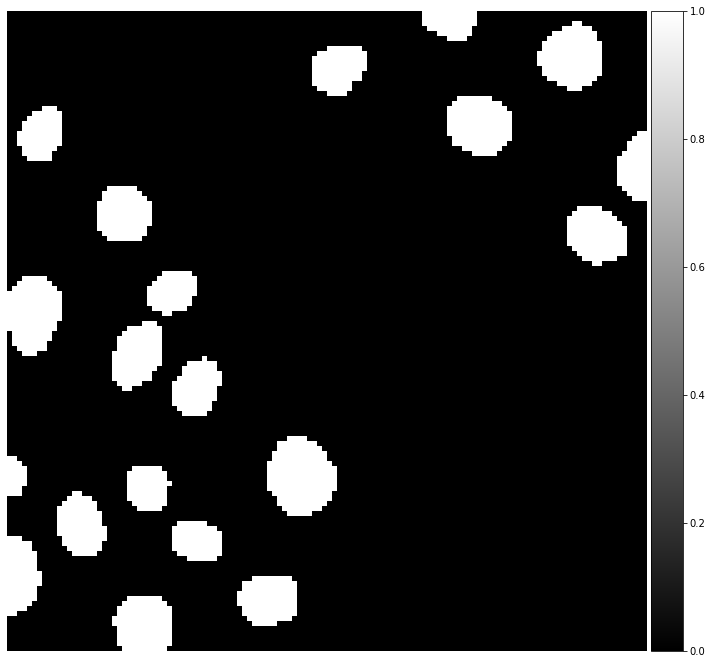

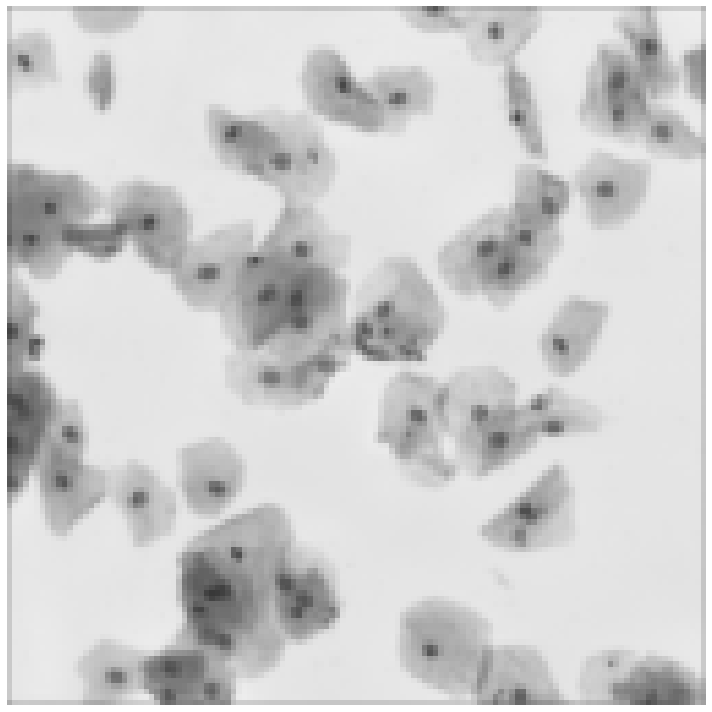

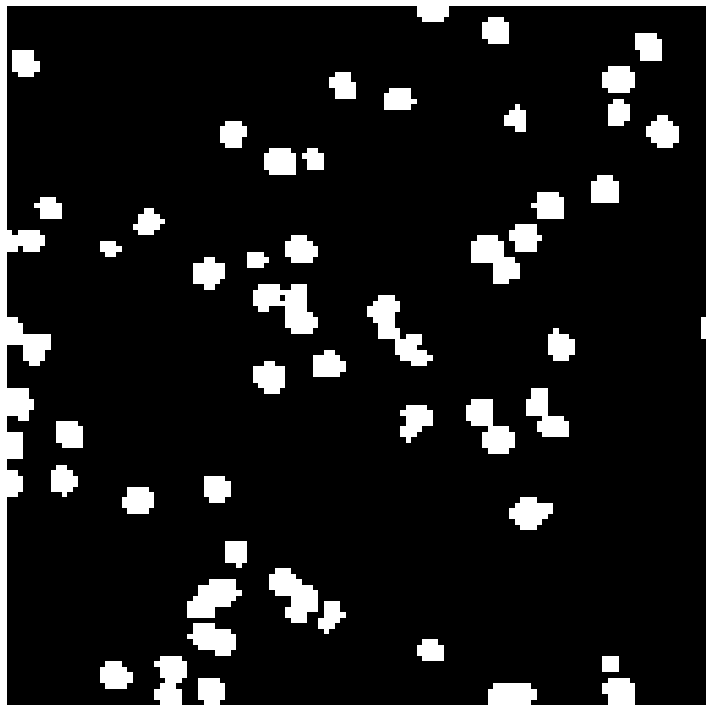

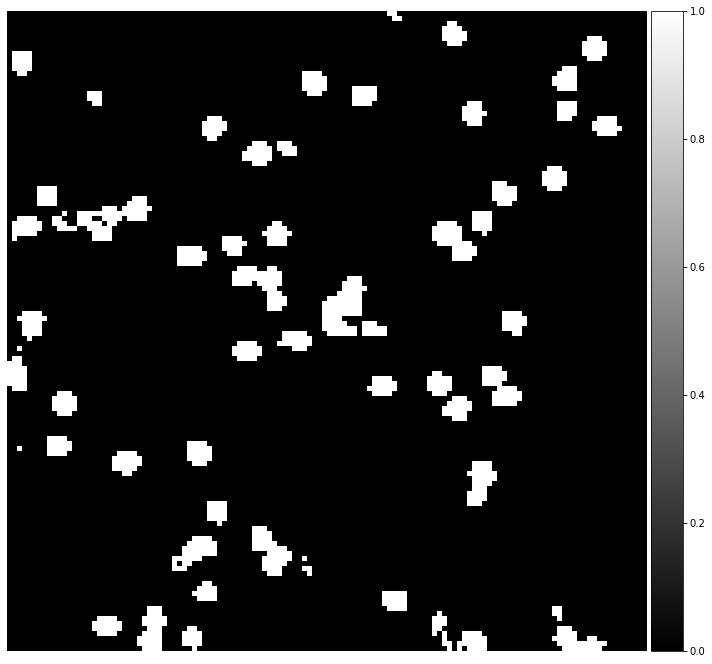

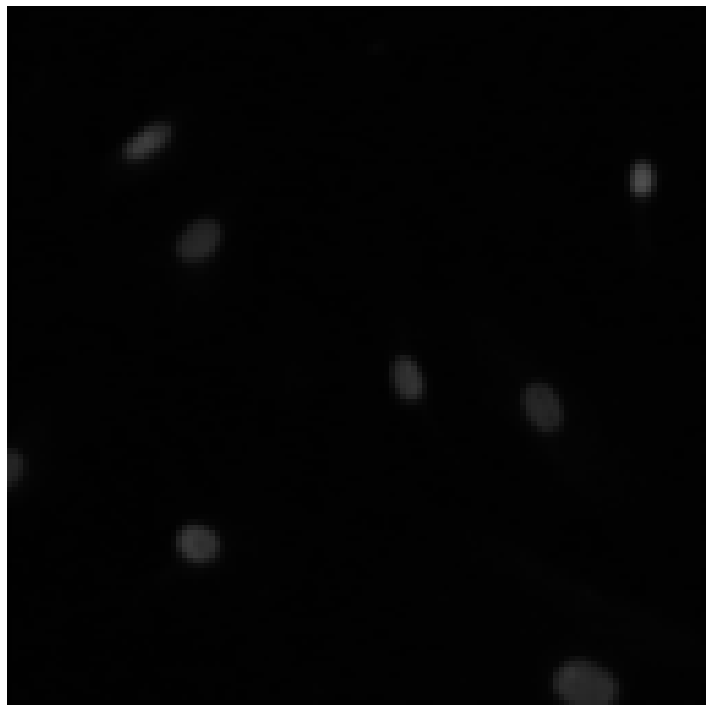

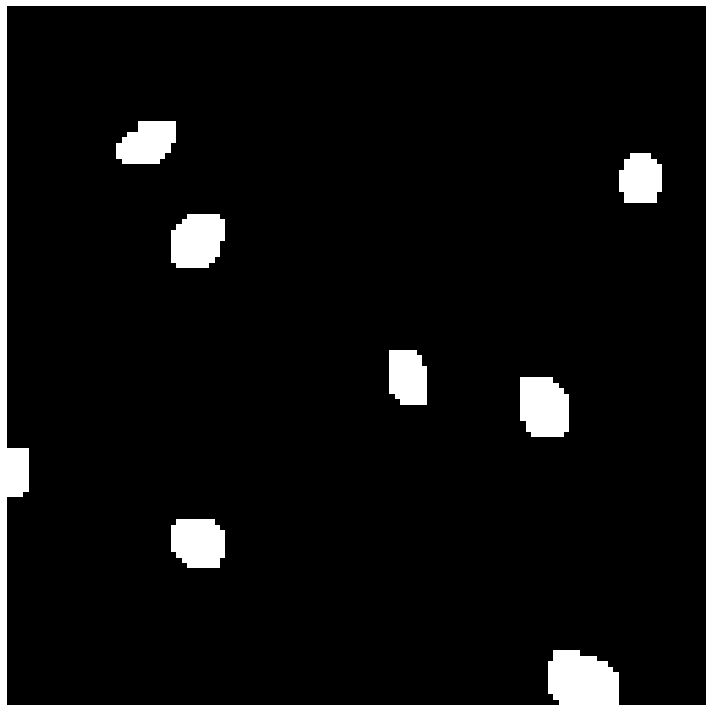

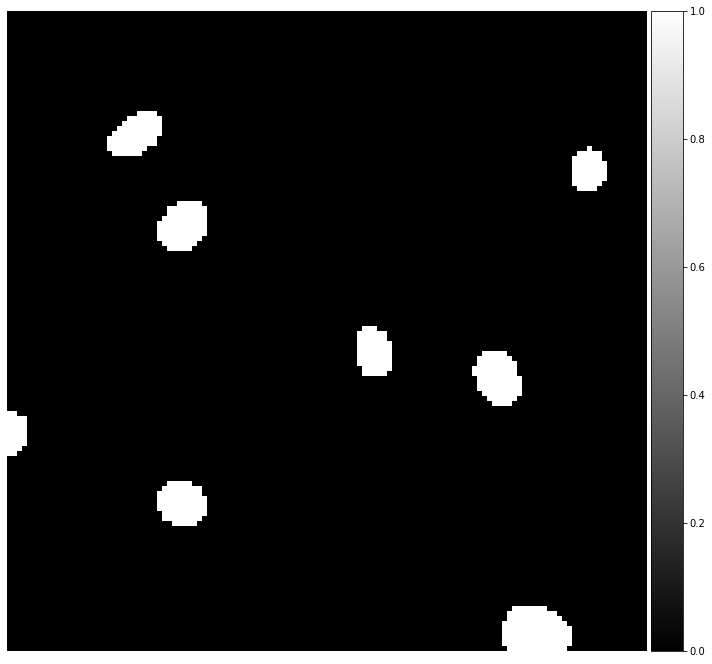

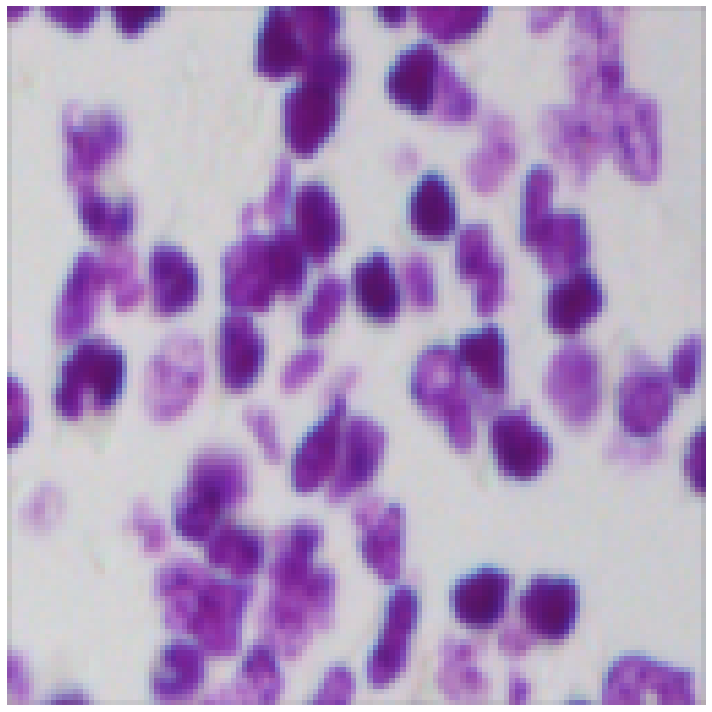

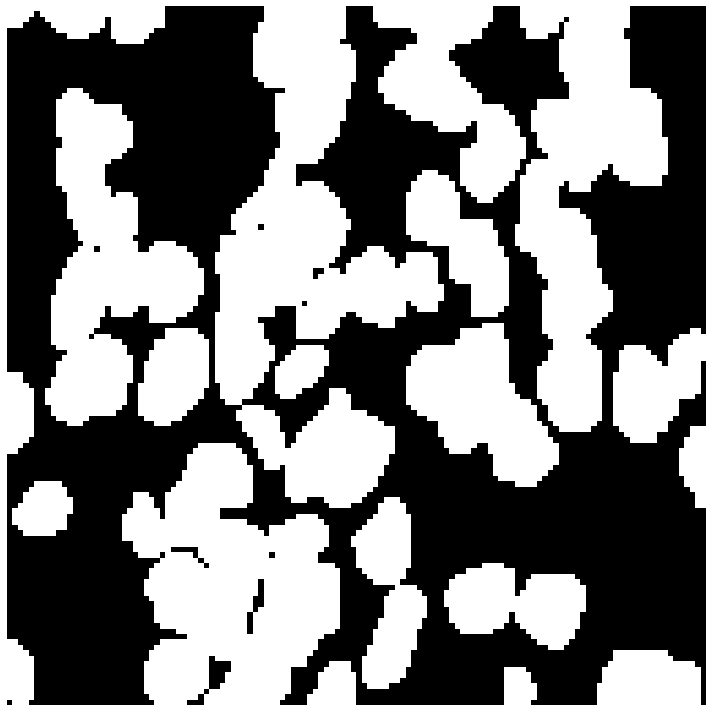

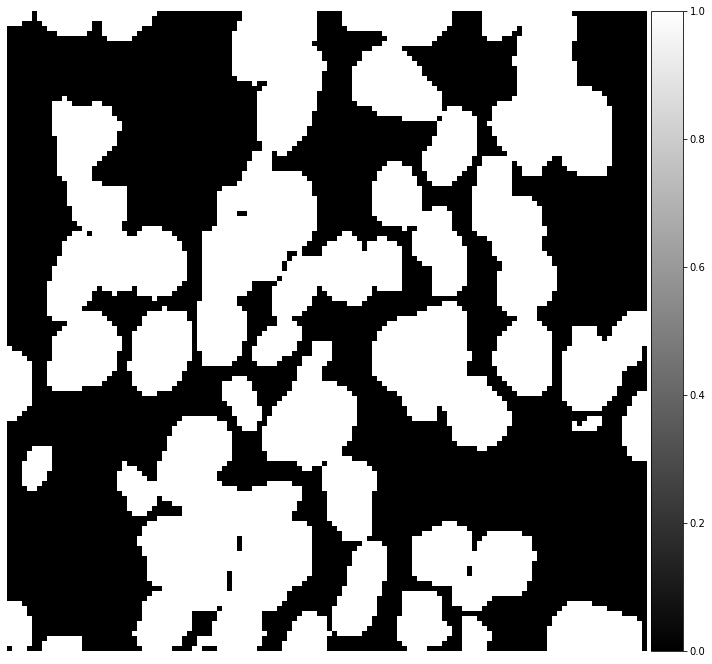

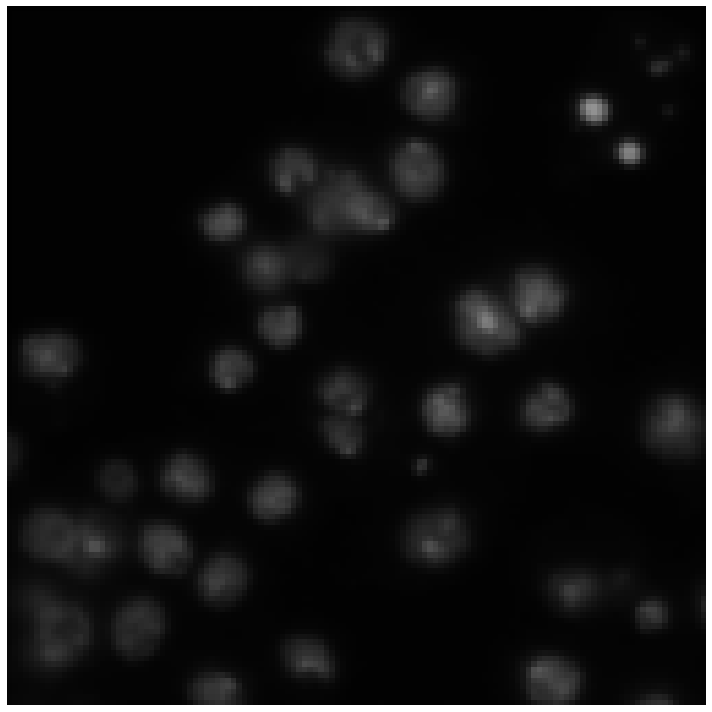

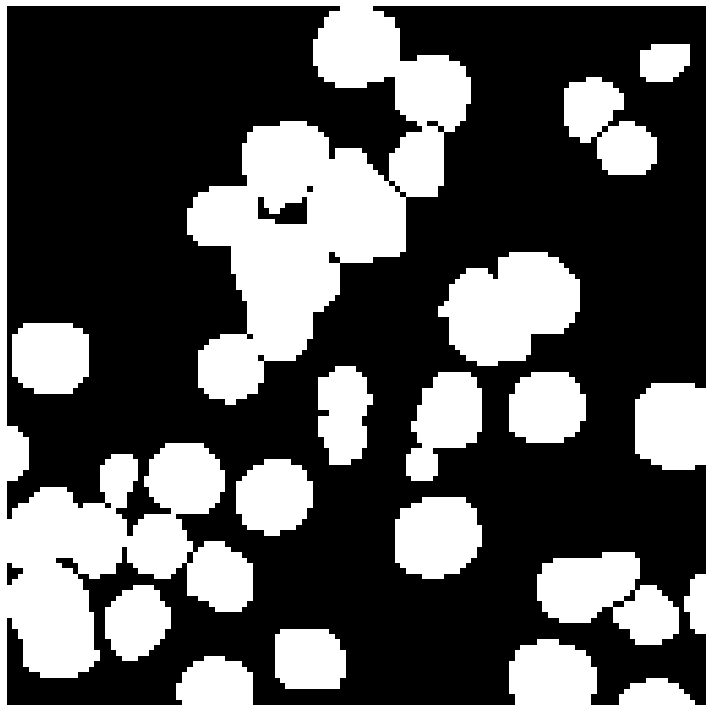

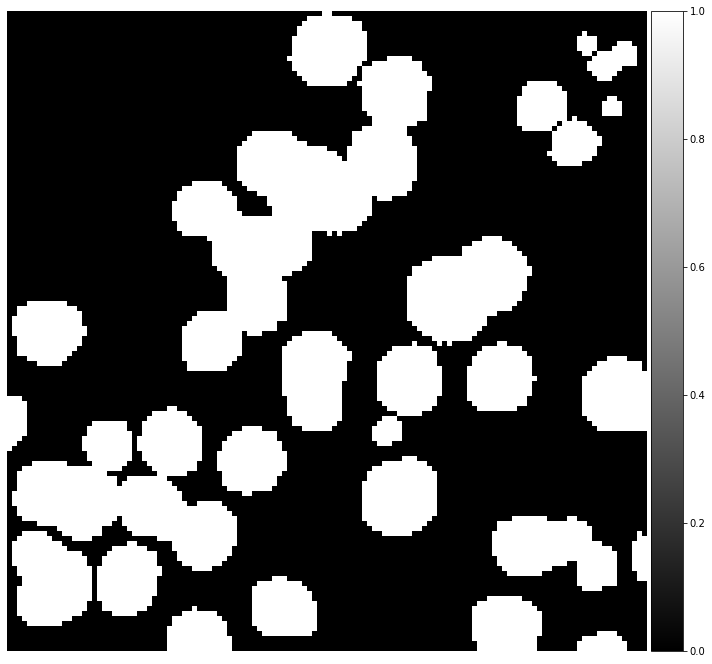

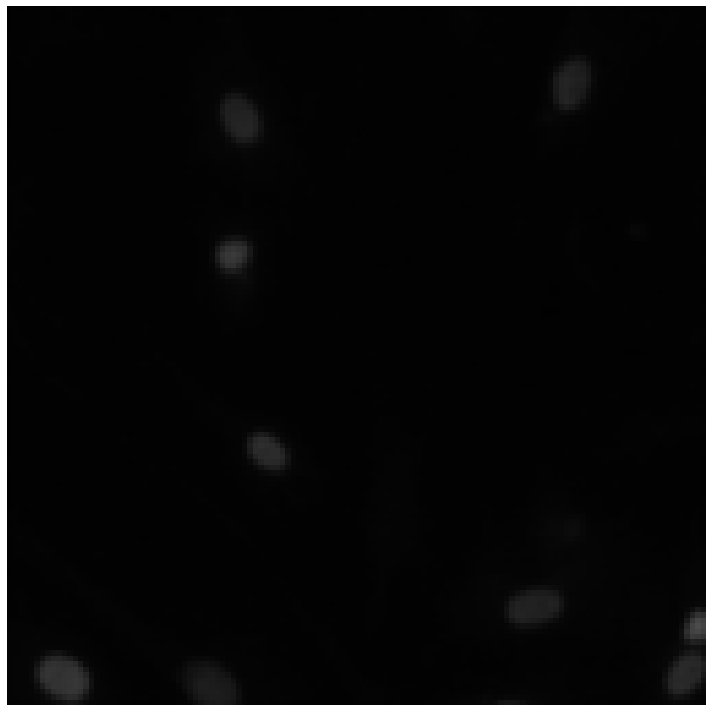

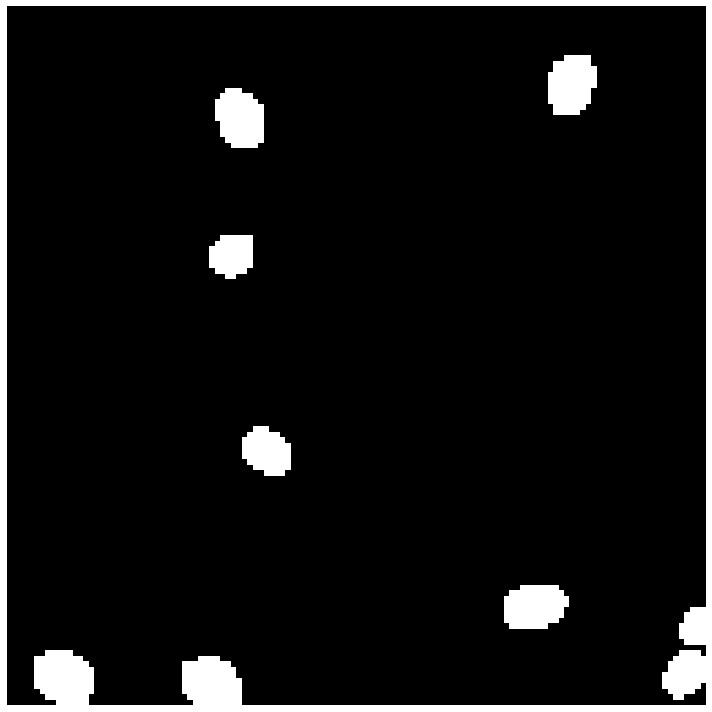

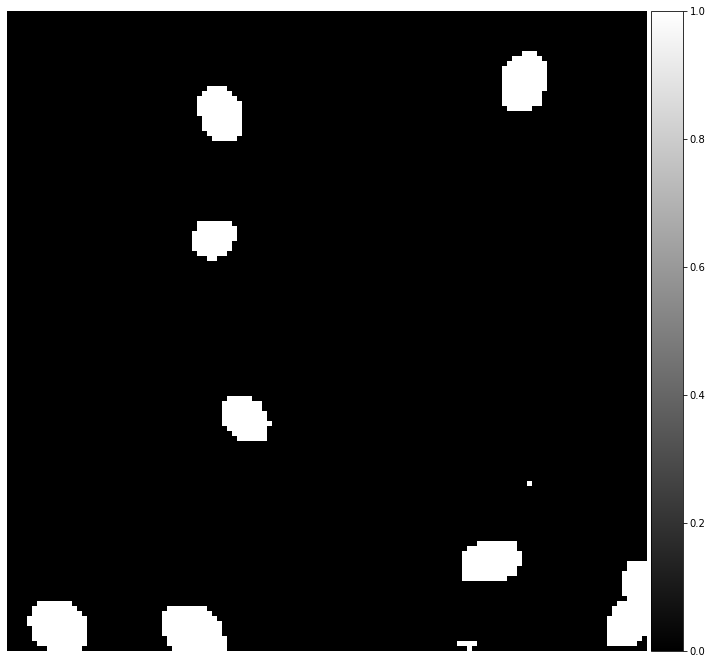

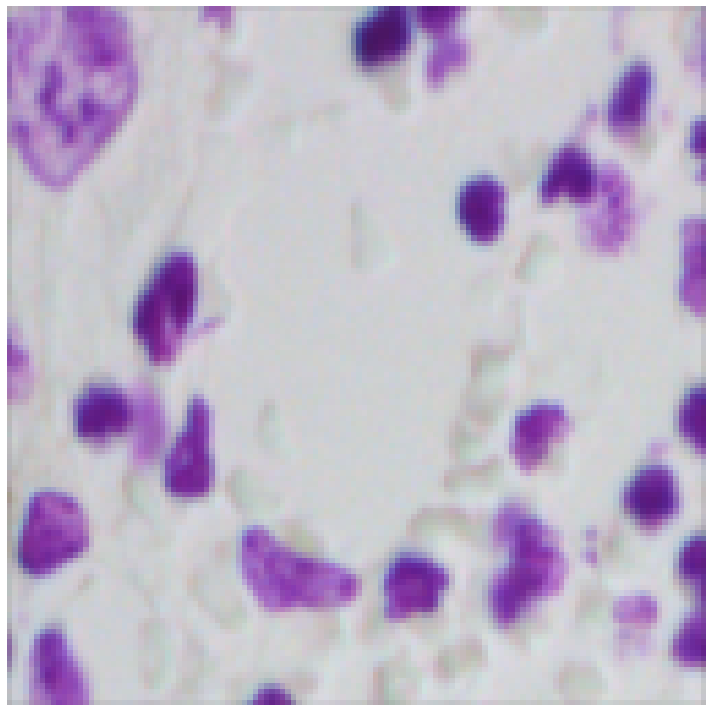

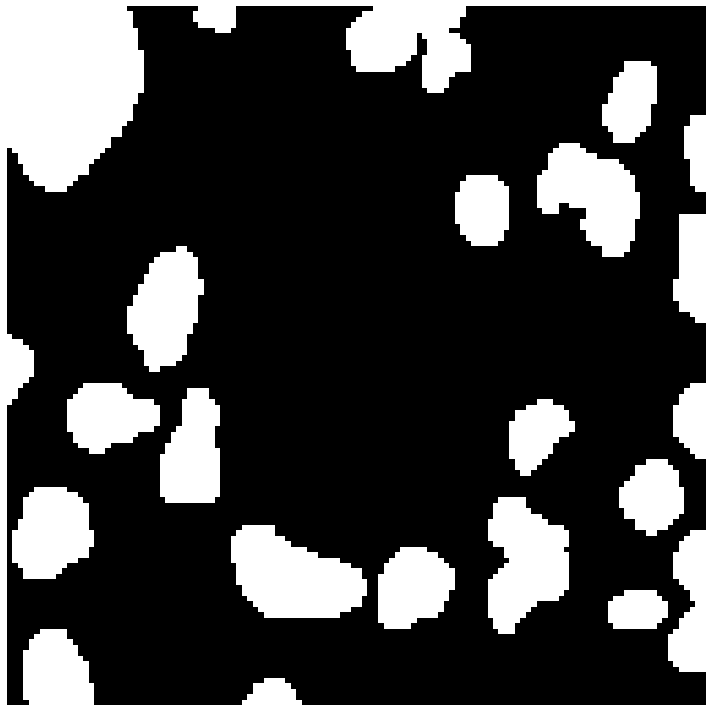

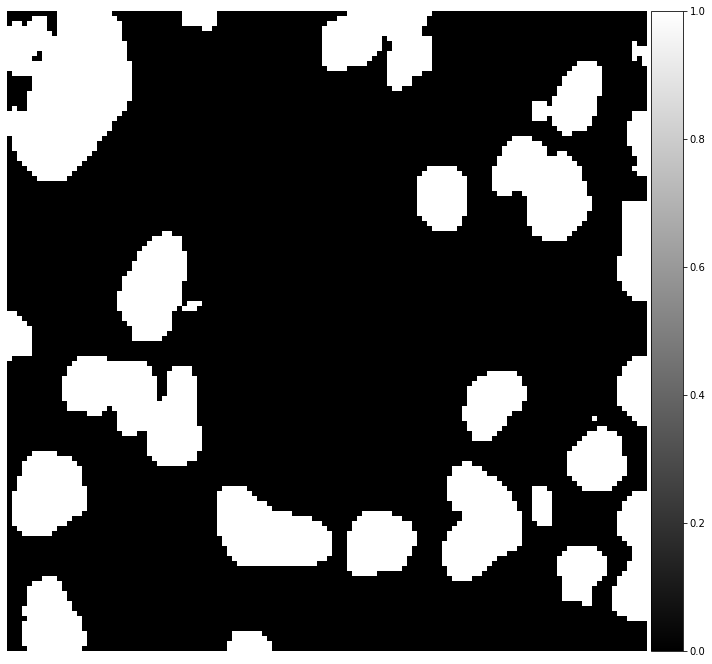

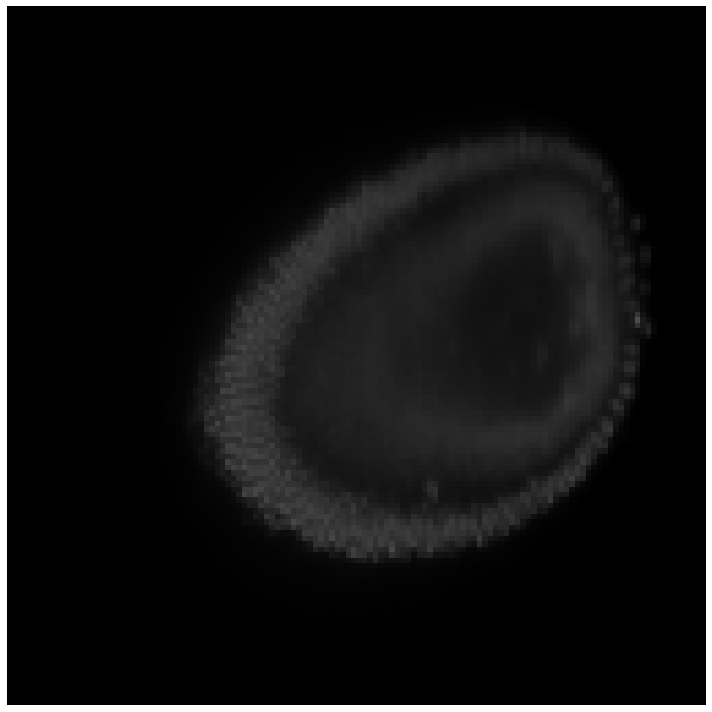

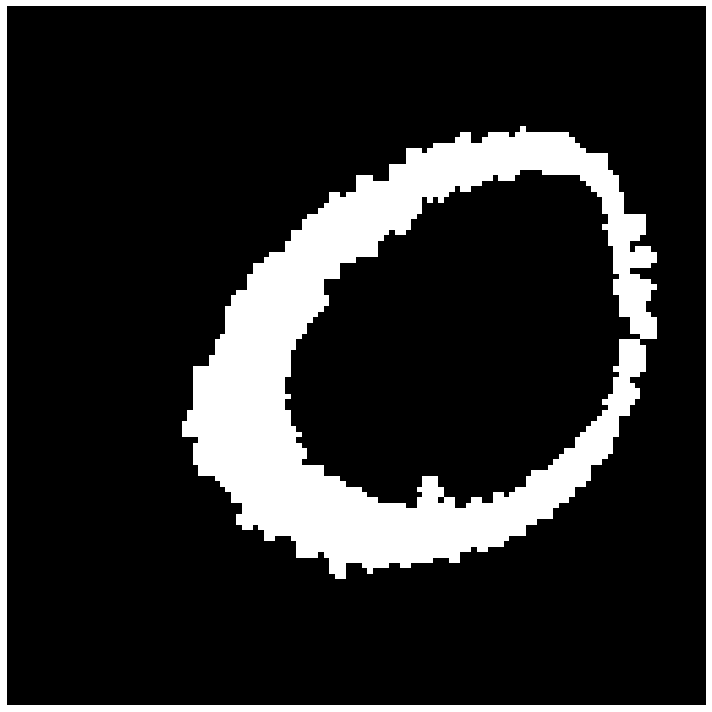

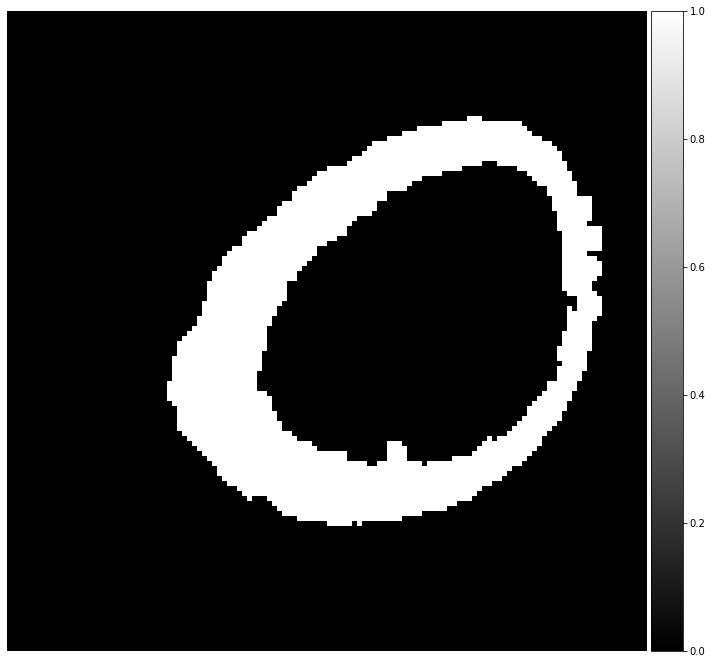

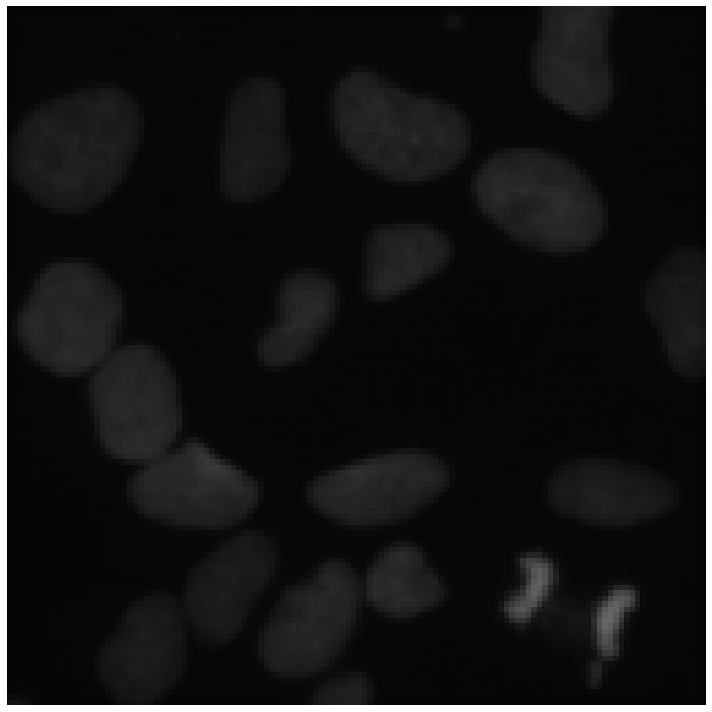

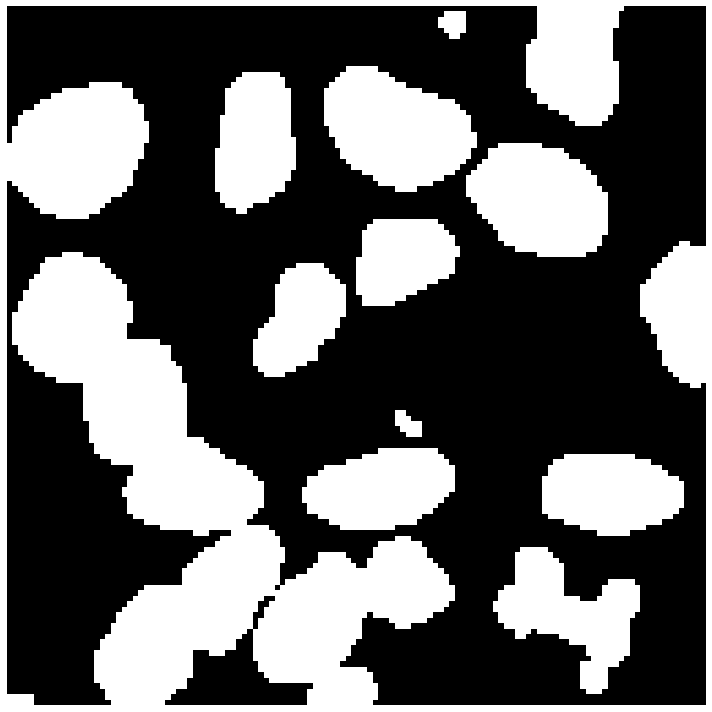

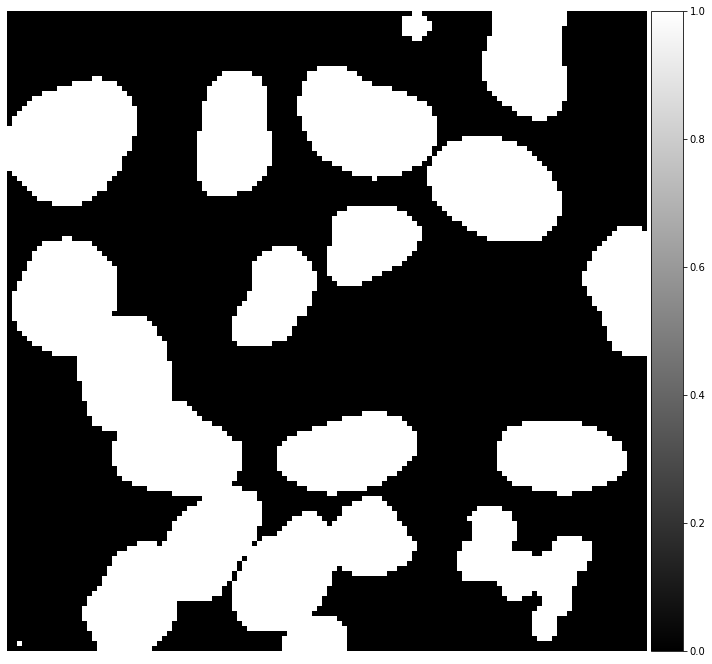

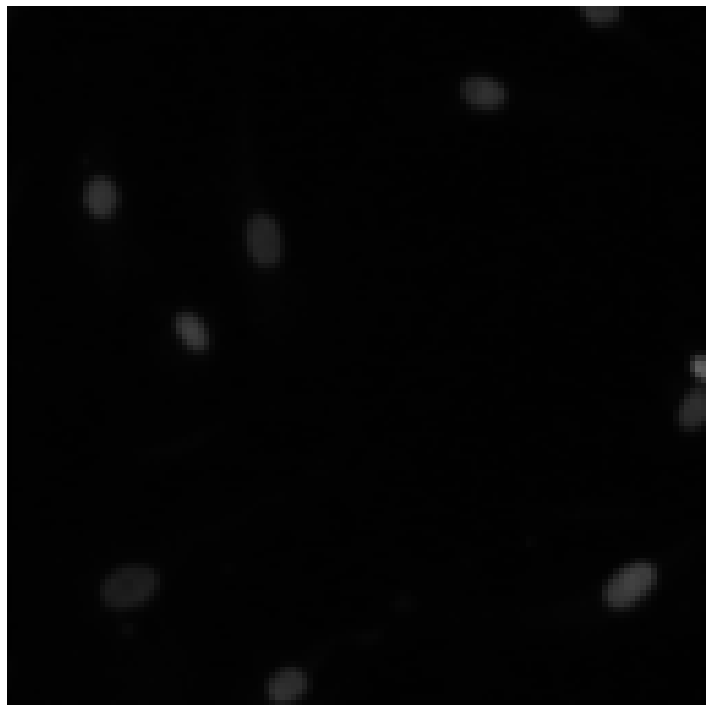

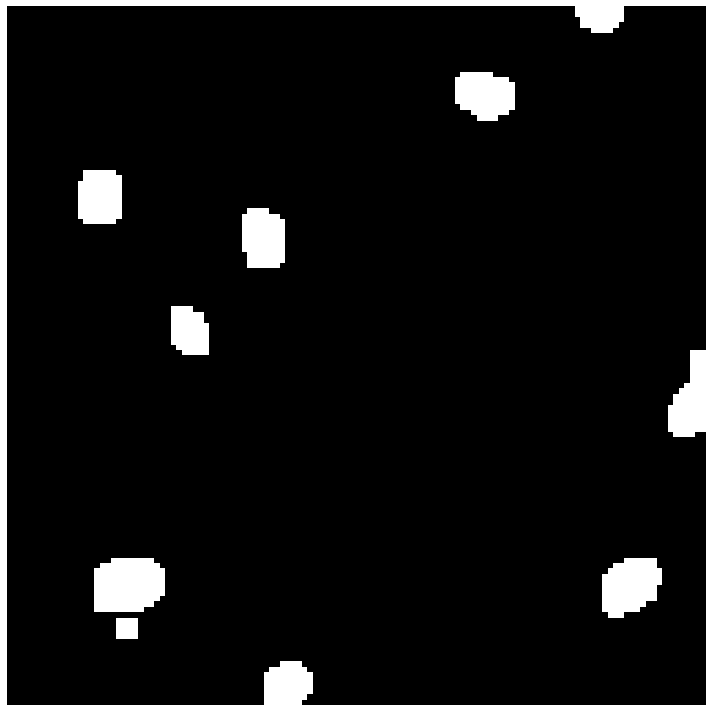

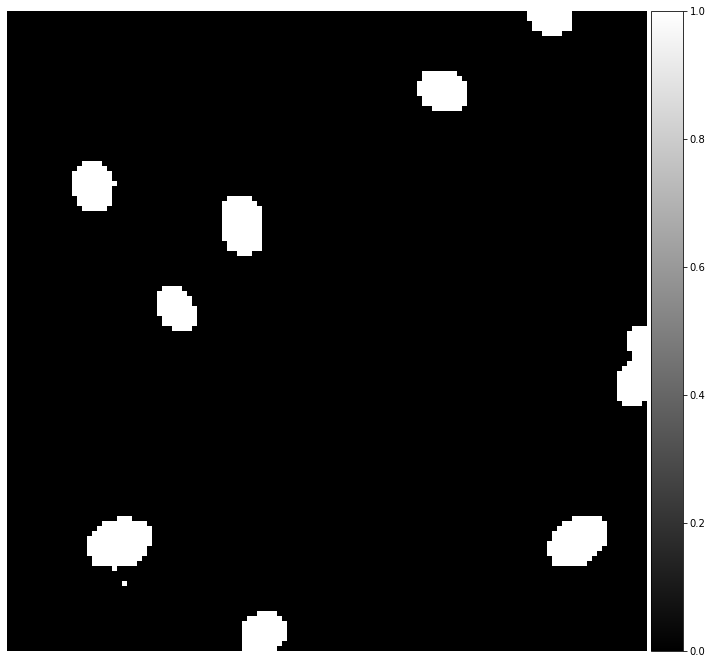

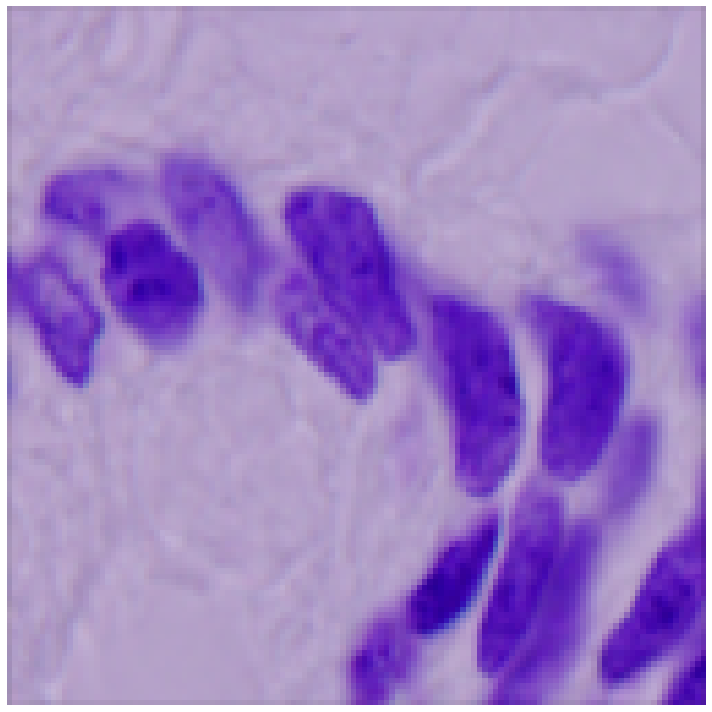

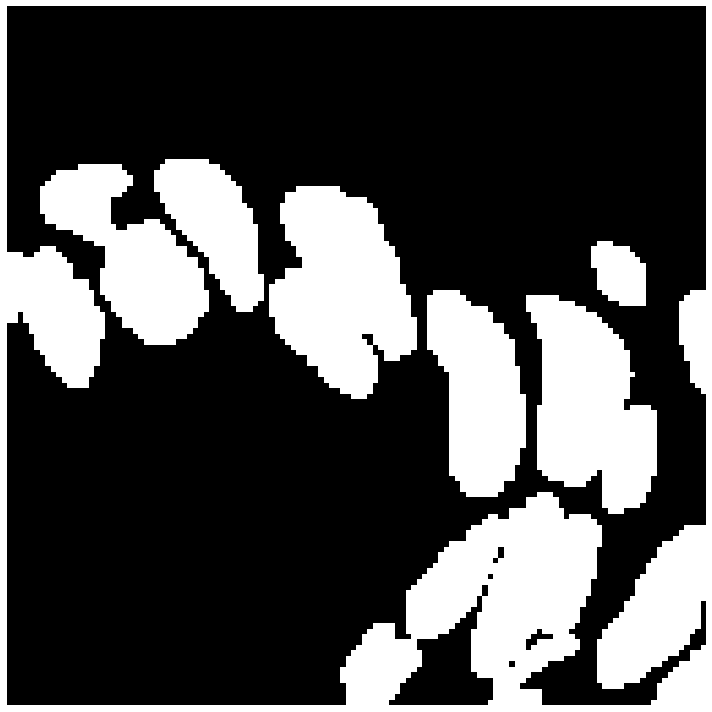

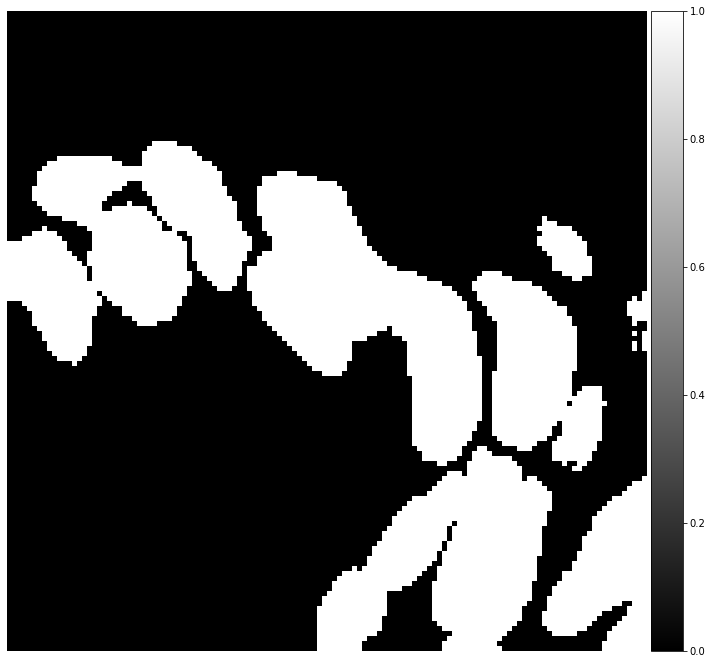

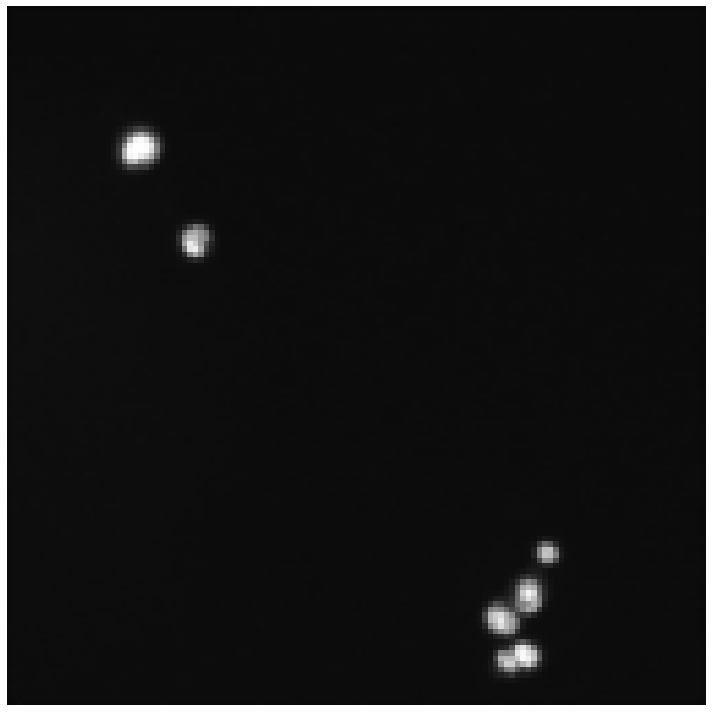

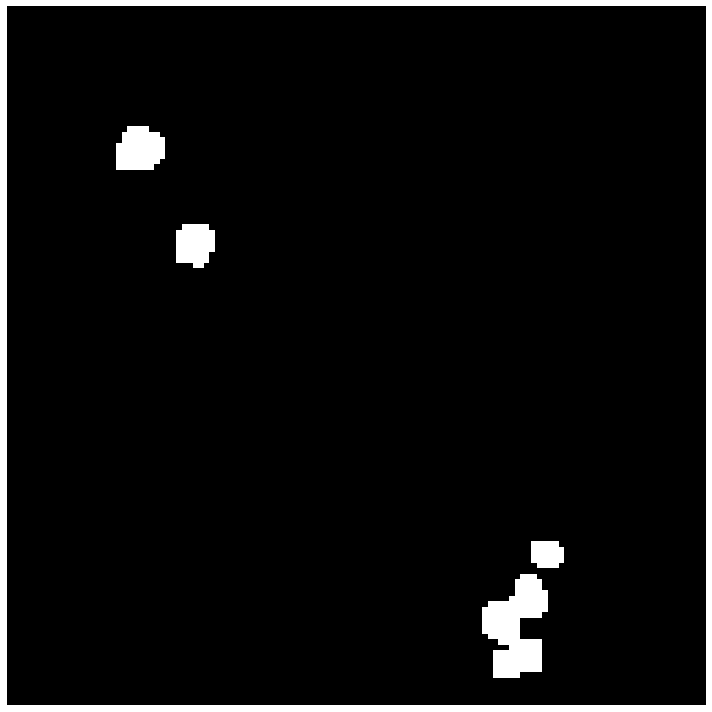

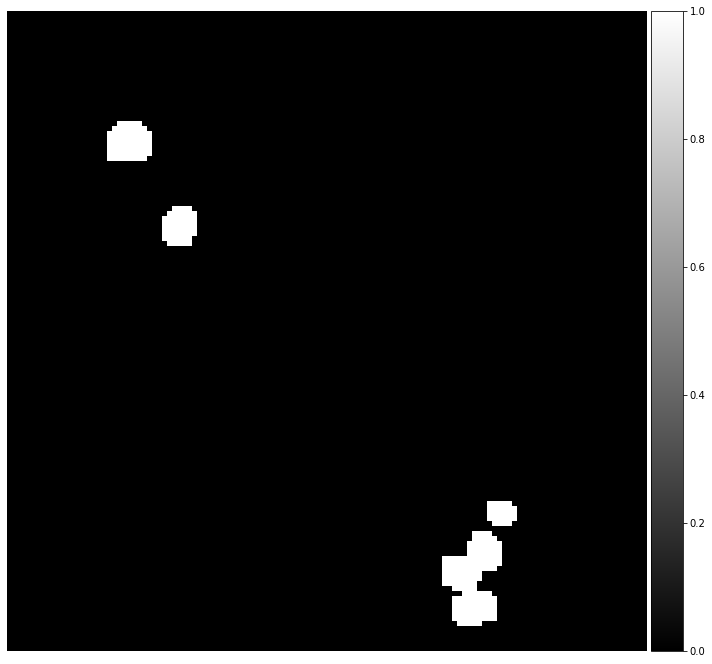

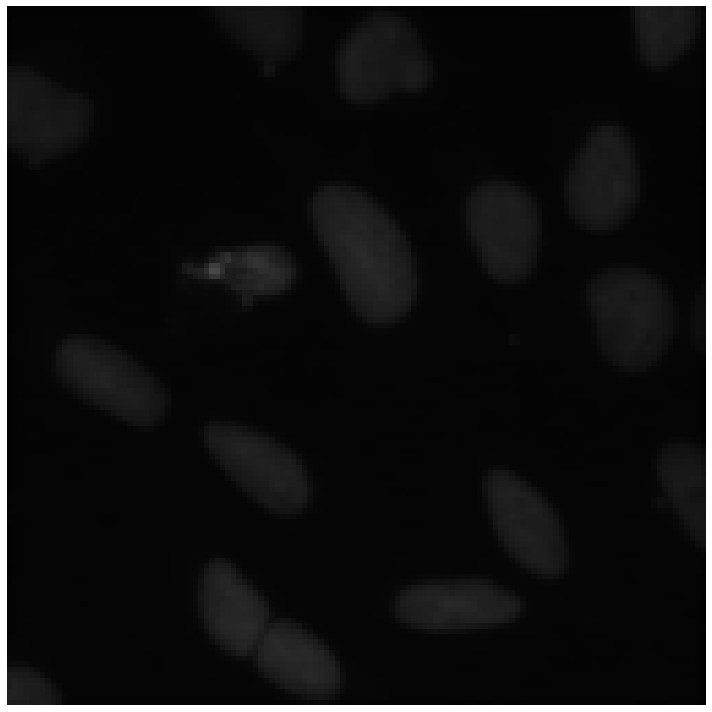

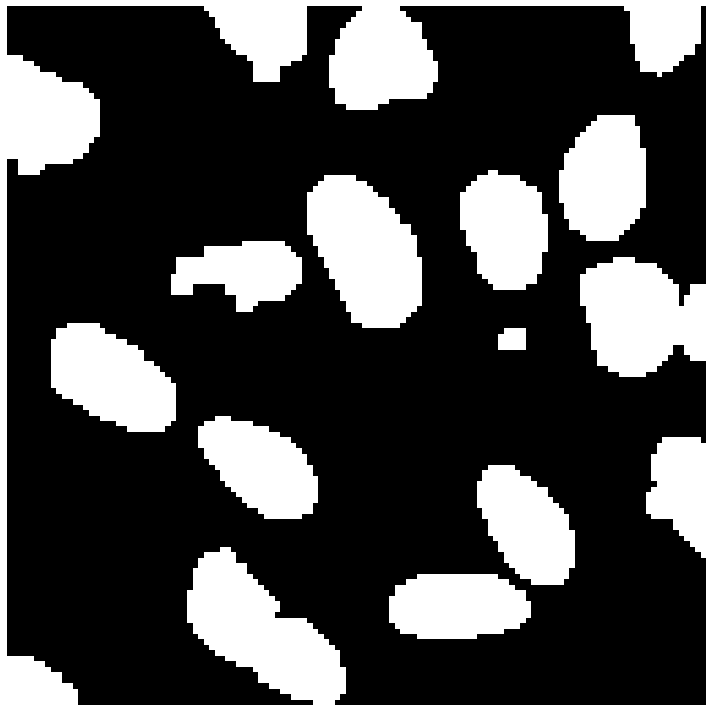

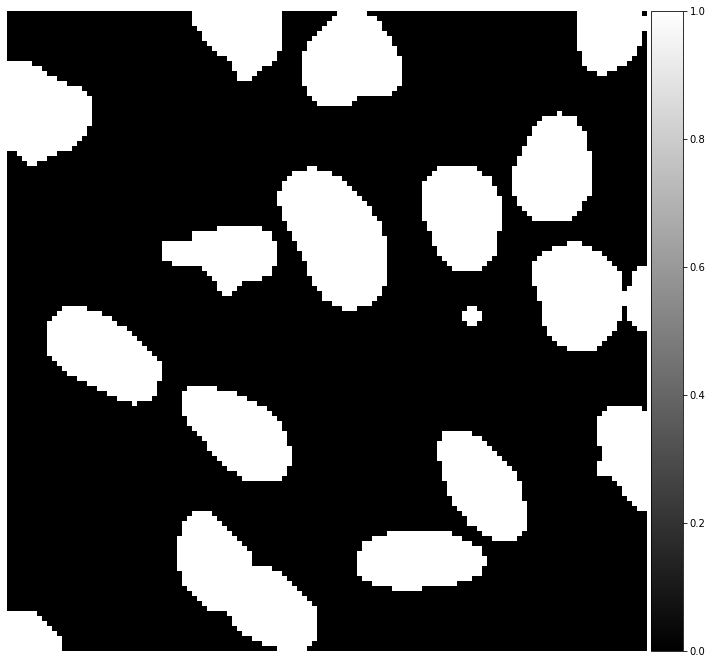

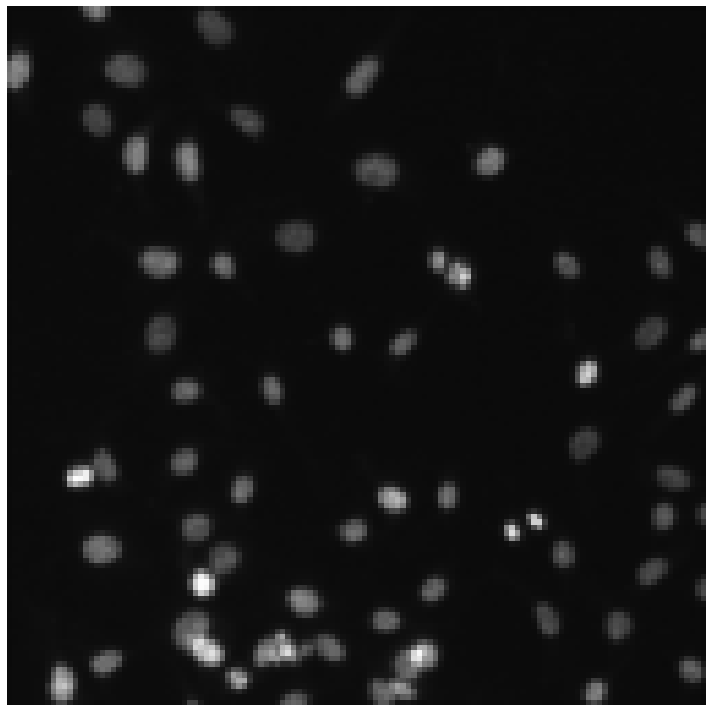

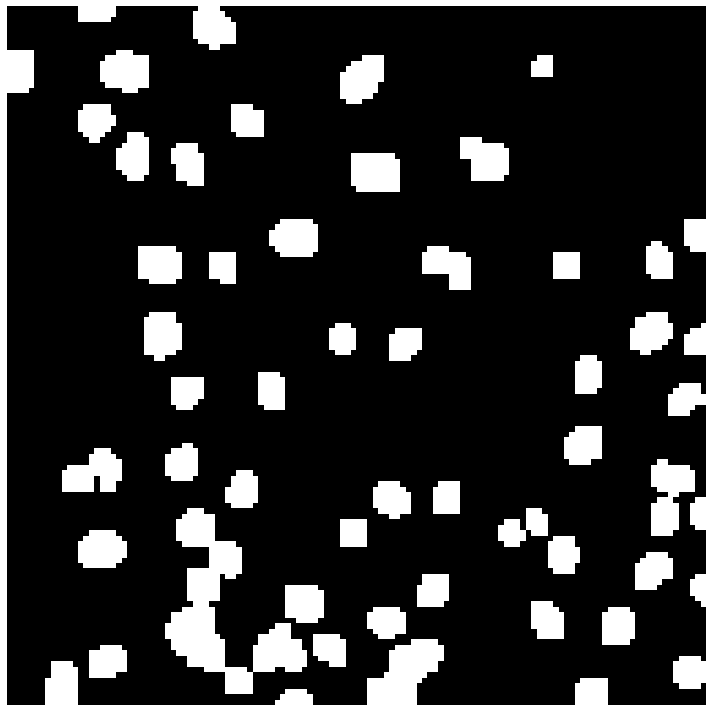

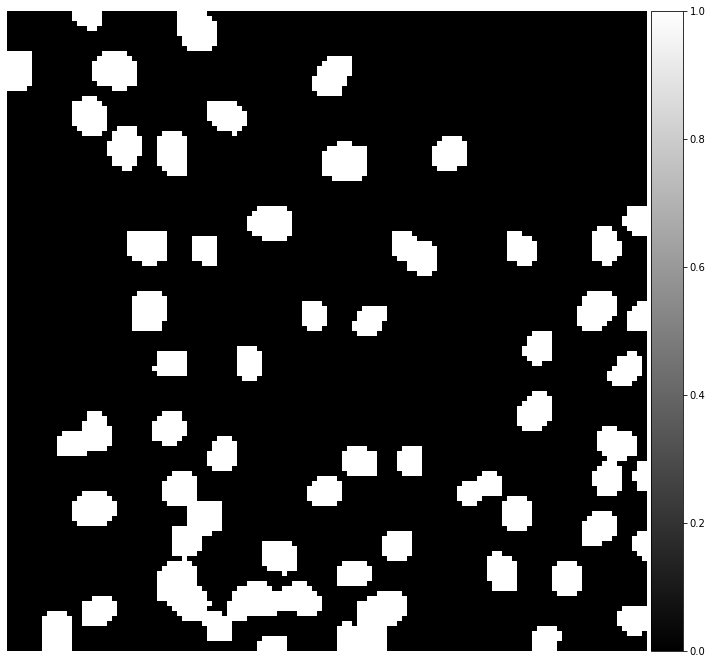

In [13]:
#Treino
for i in range(0, 20):

    ix = random.randint(0, len(preds_train_t))

    plt.figure(figsize=(10,10))
    plt.axis('off')
    imshow(X_train[ix])
    plt.savefig("./resultadosImages/Treino/ImageTrain{}.png".format(i))
    plt.show()

    plt.figure(figsize=(10,10))
    plt.axis('off')
    imshow(np.squeeze(Y_train[ix]), cmap=plt.cm.gray)
    plt.savefig("./resultadosImages/Treino/figUnetNucleiTrain{}.png".format(i))
    plt.show()

    plt.figure(figsize=(10,10))
    plt.axis('off')
    imshow(np.squeeze(preds_train_t[ix]), cmap=plt.cm.gray)
    plt.savefig("./resultadosImages/Treino/figUnetNucleiTrainPred{}.png".format(i))
    plt.show()

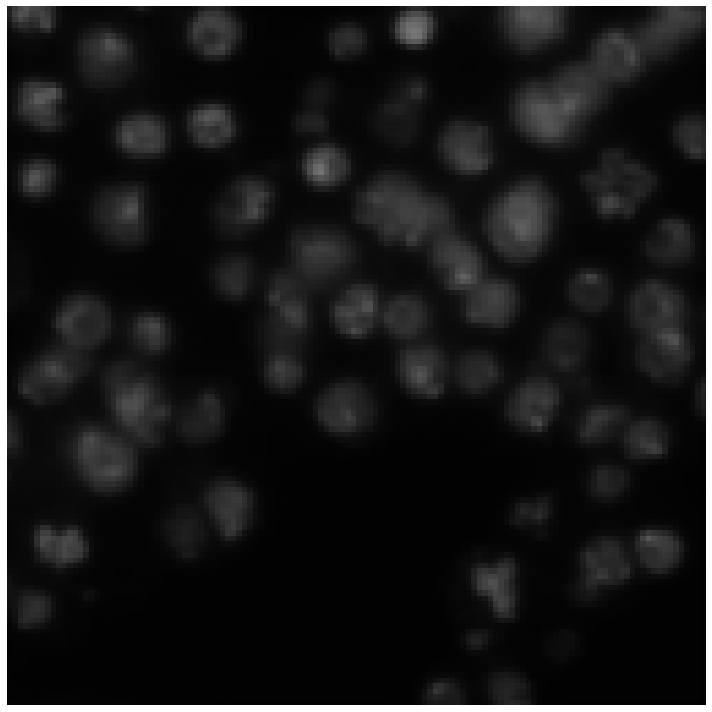

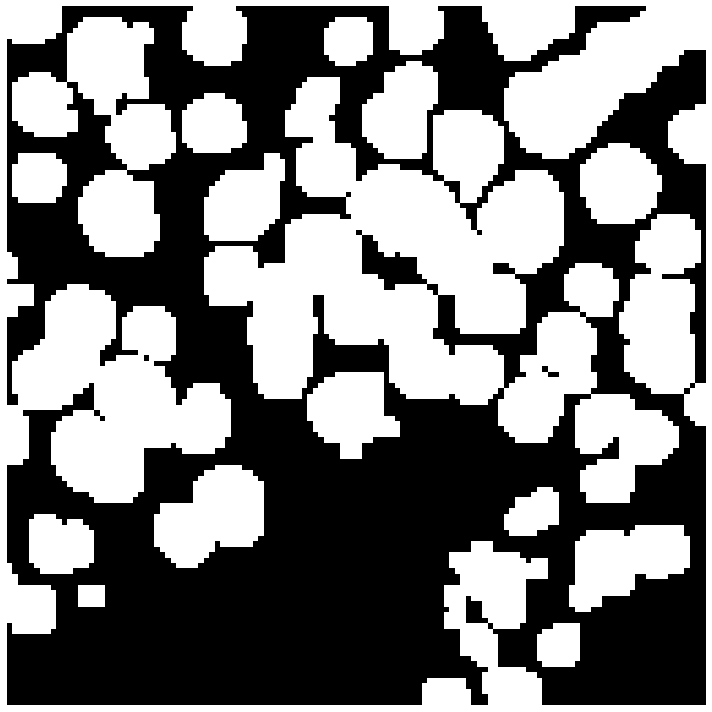

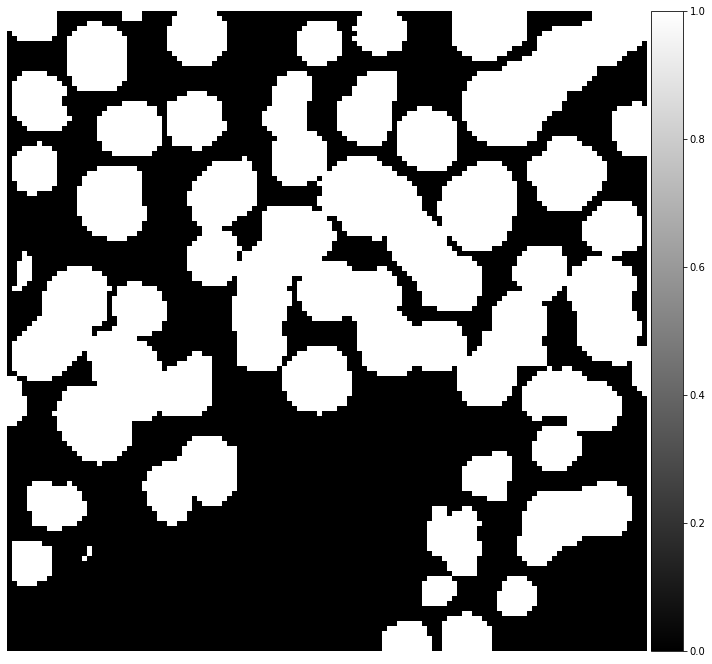

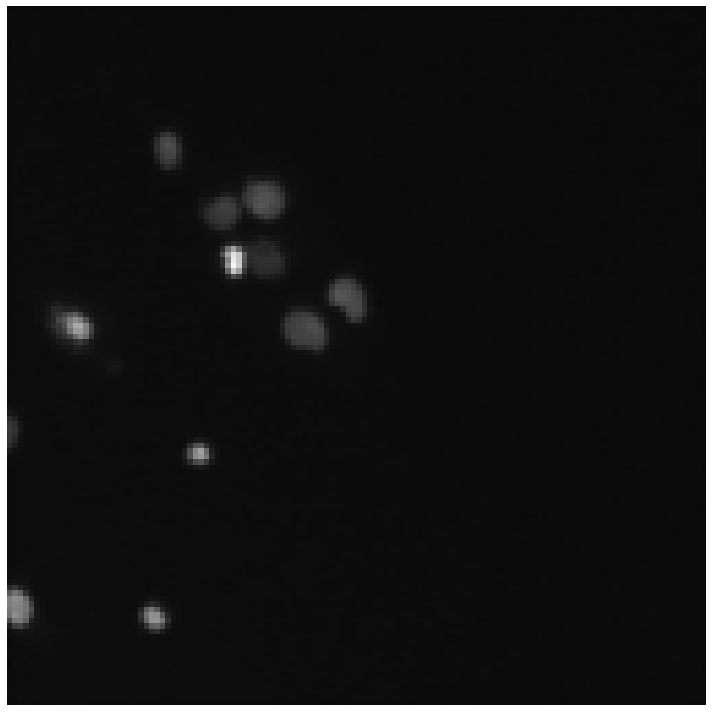

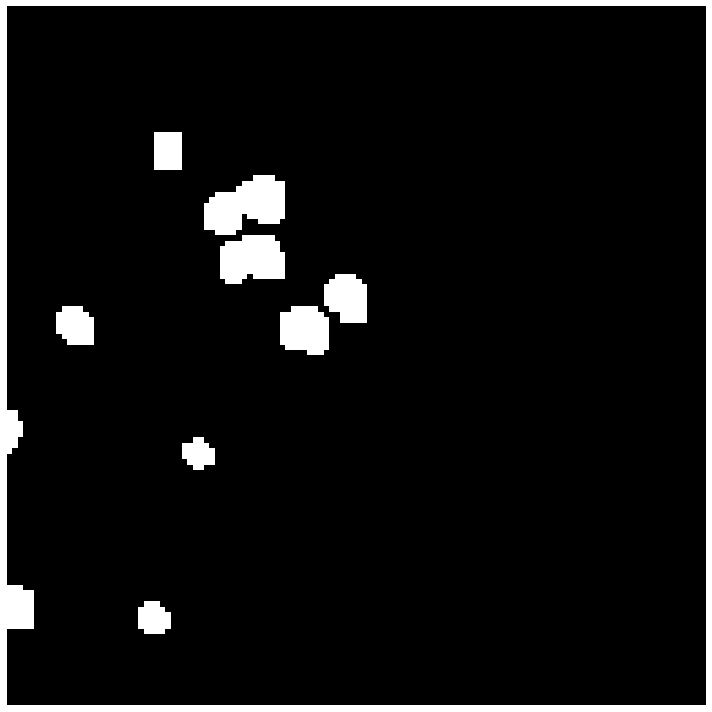

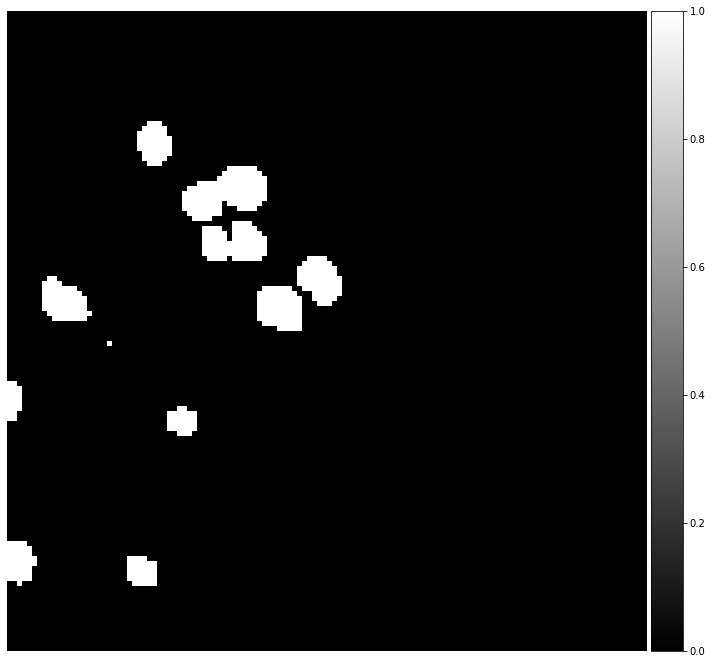

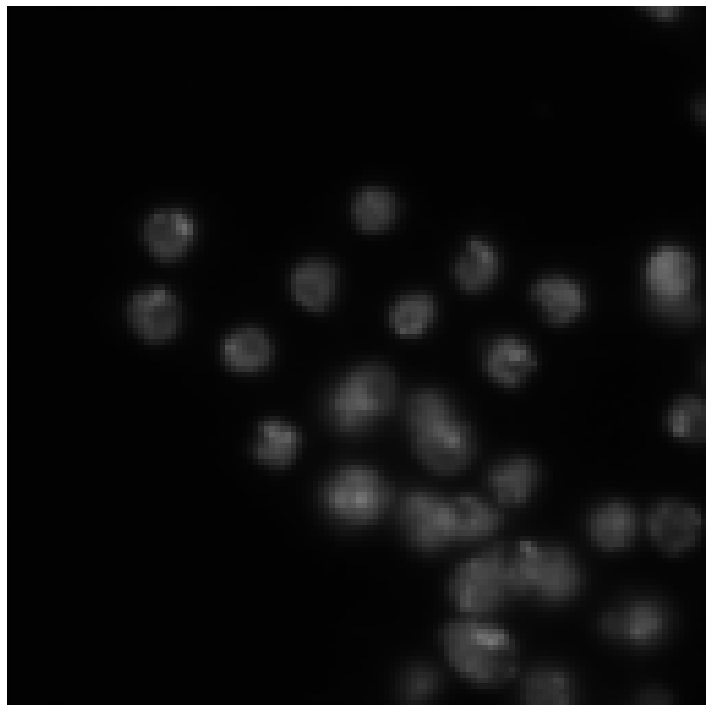

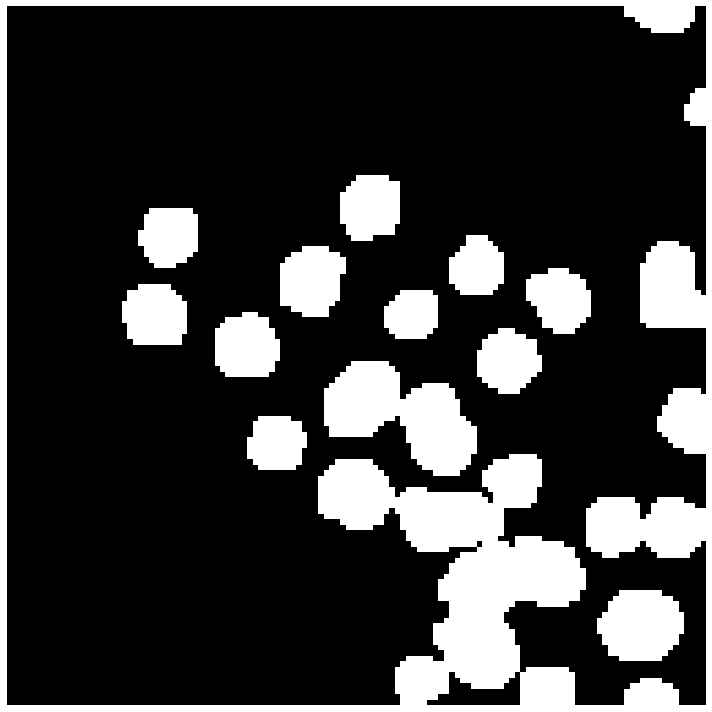

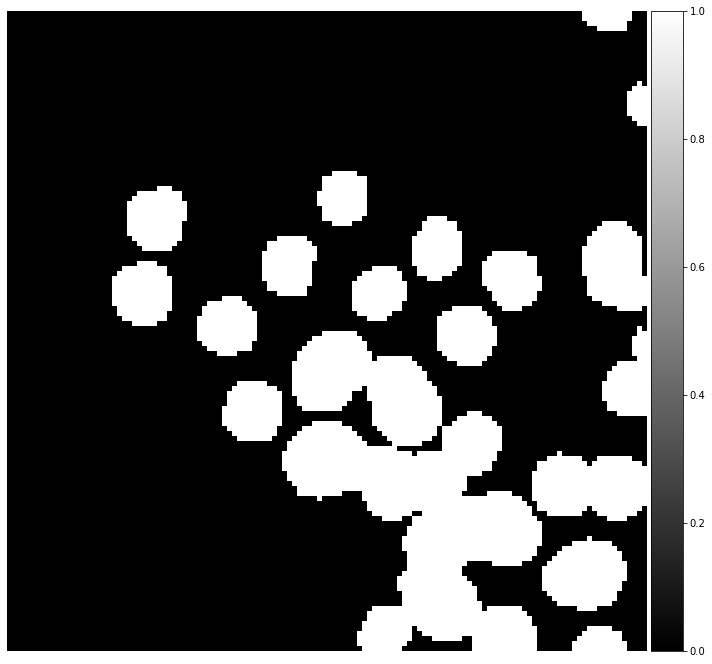

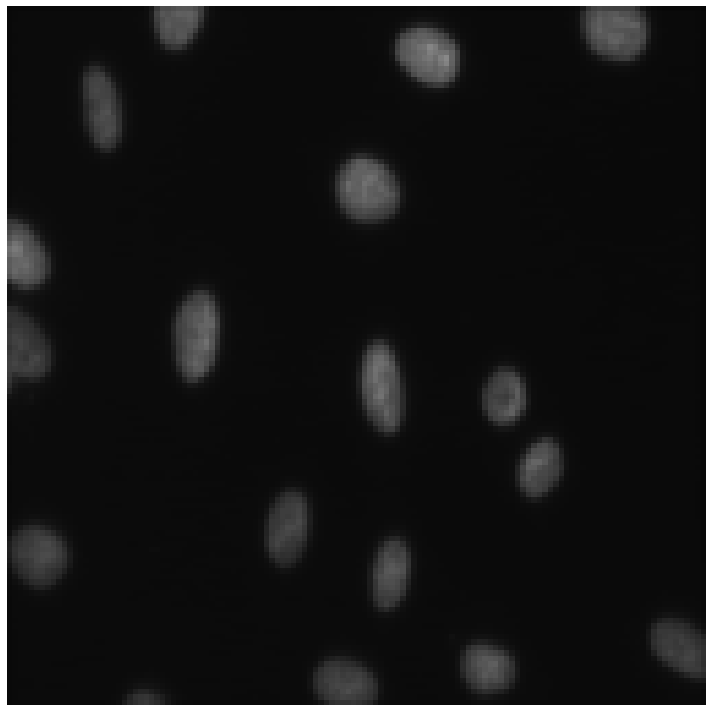

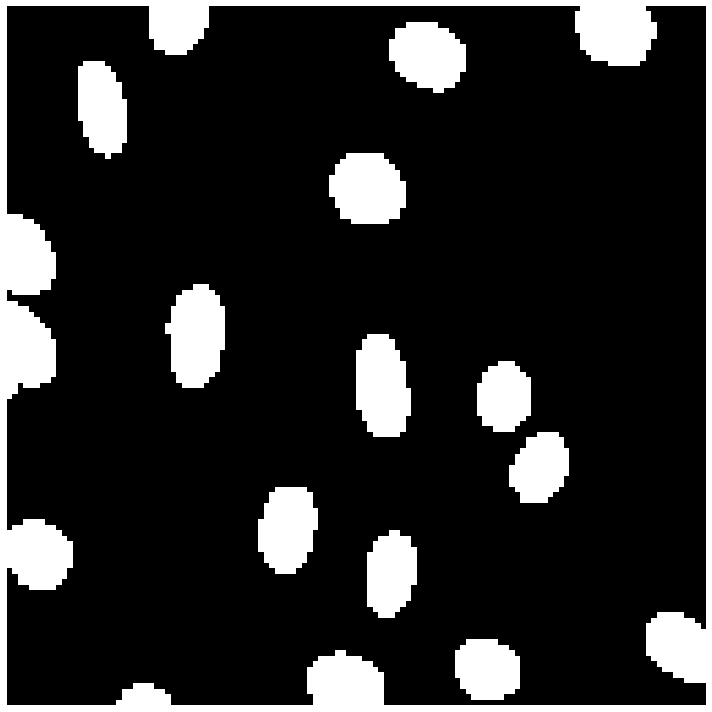

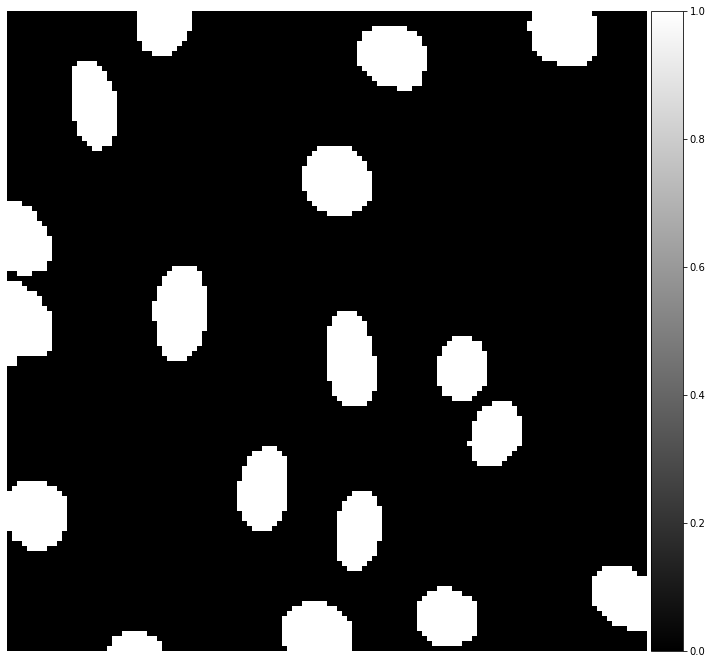

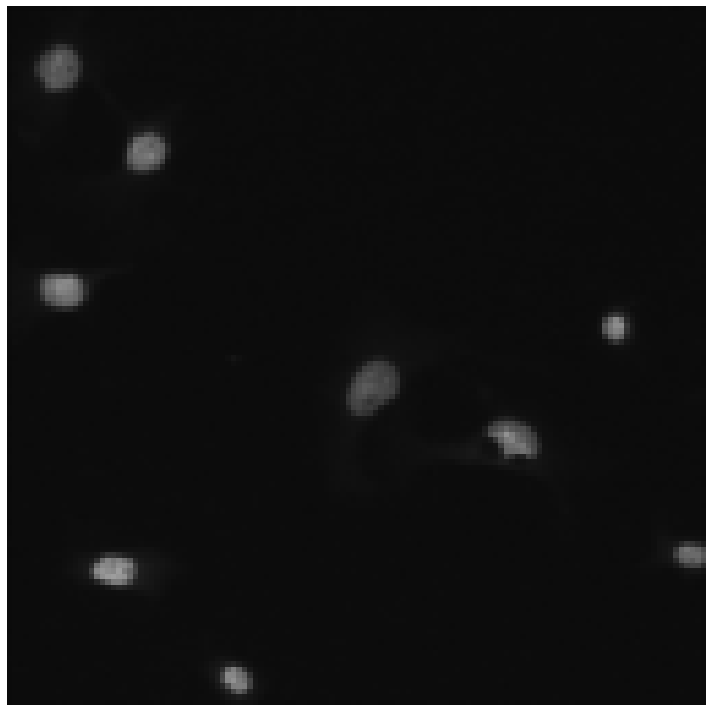

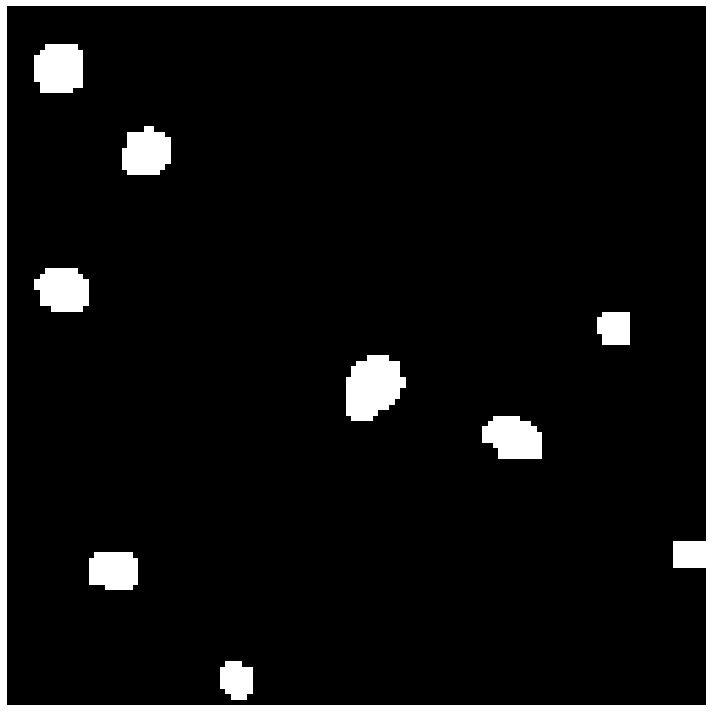

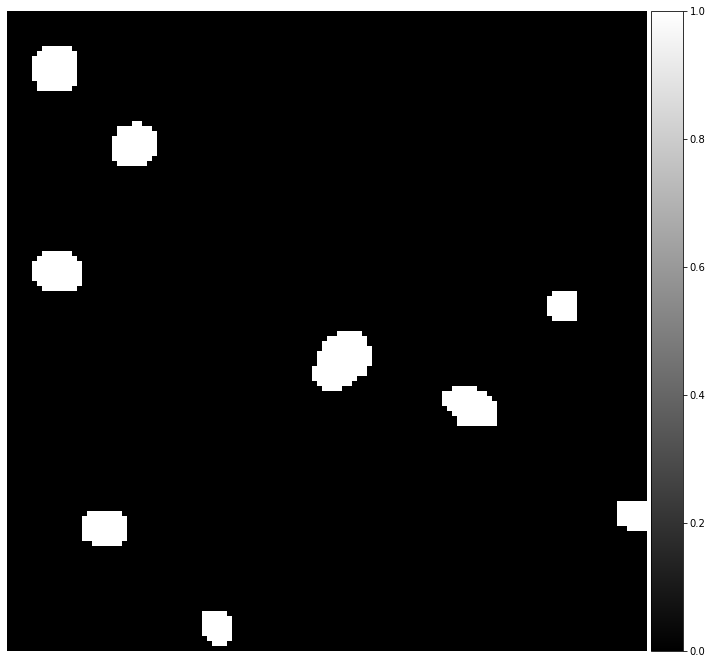

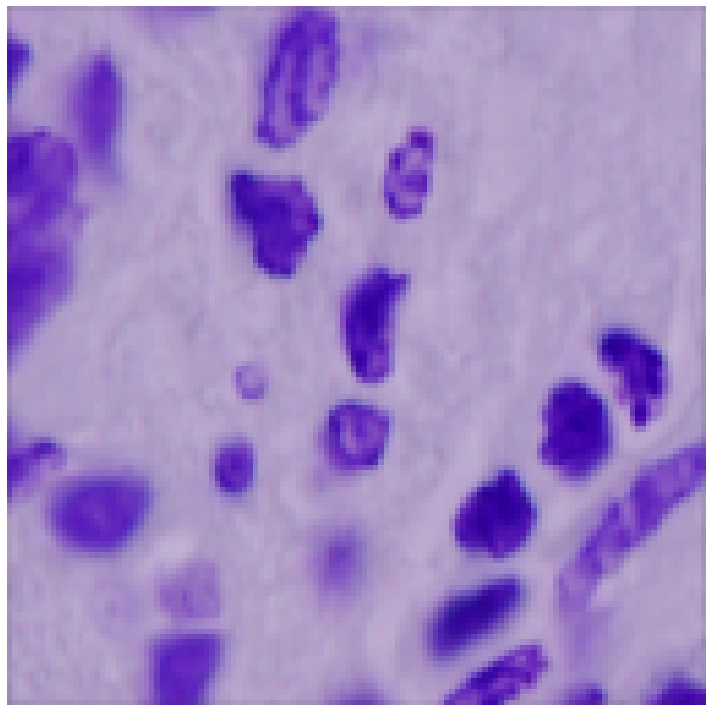

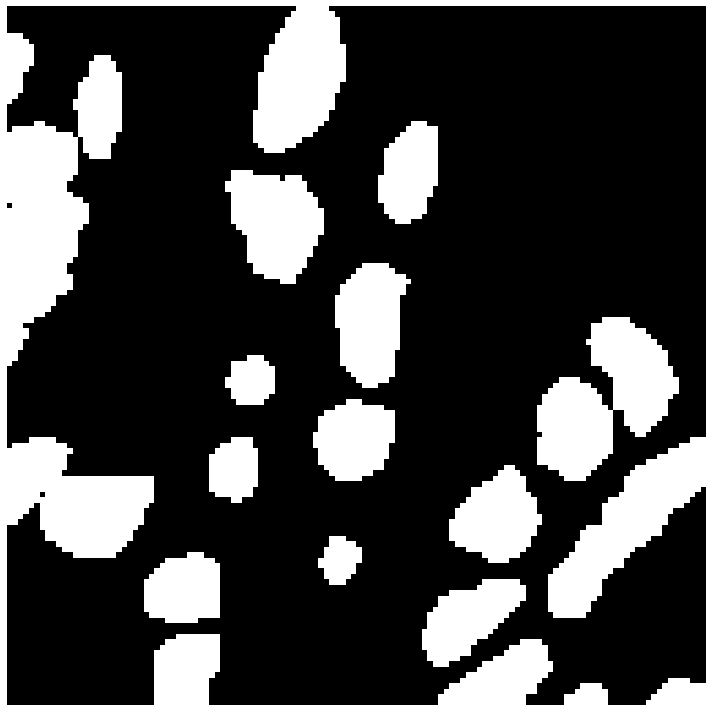

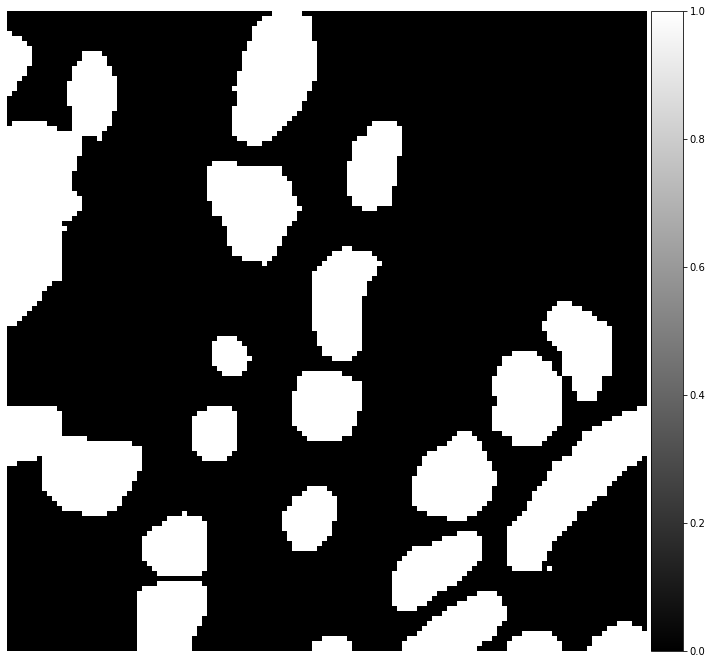

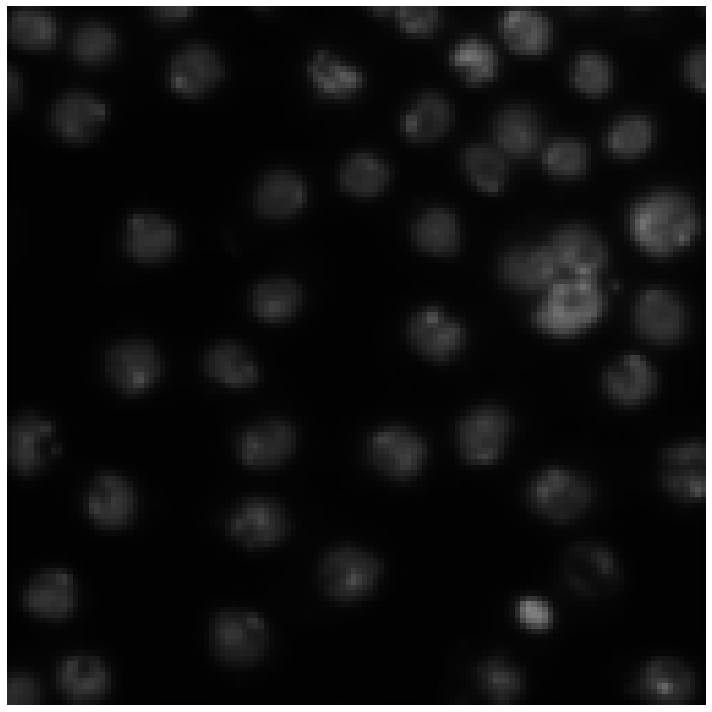

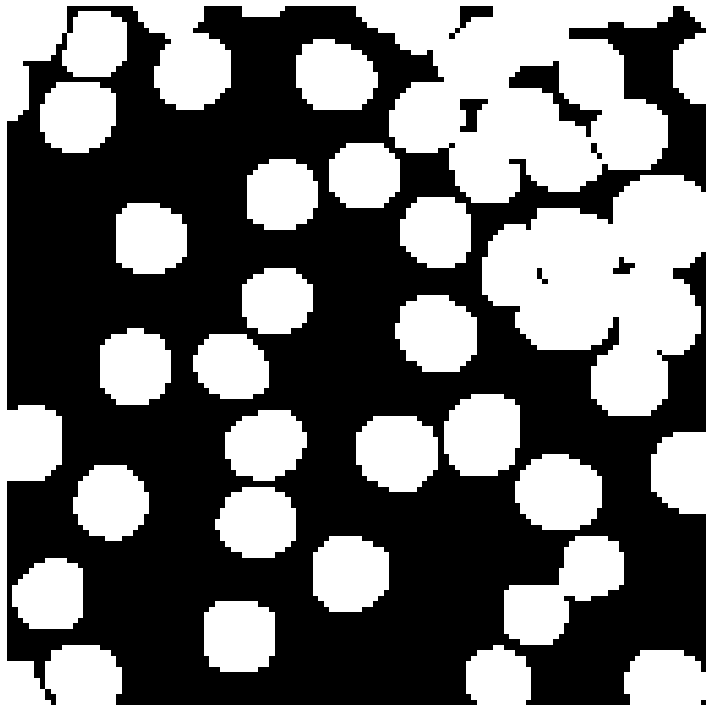

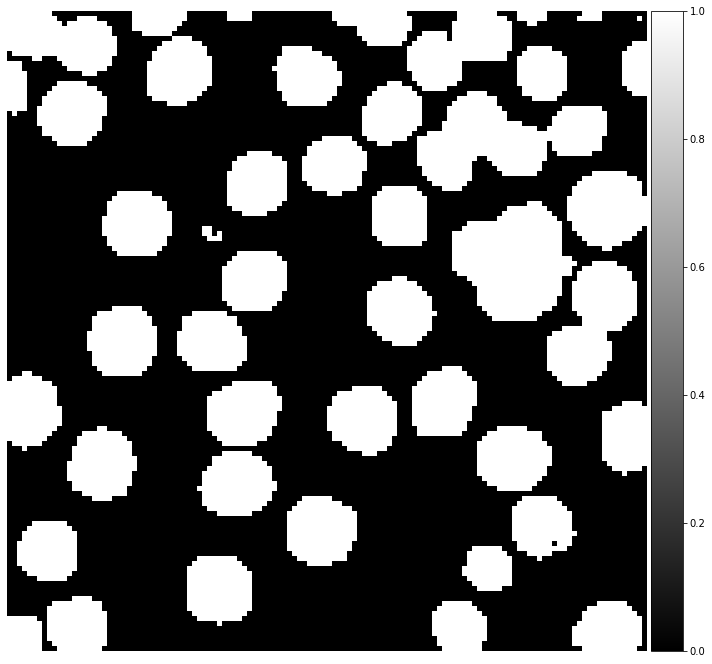

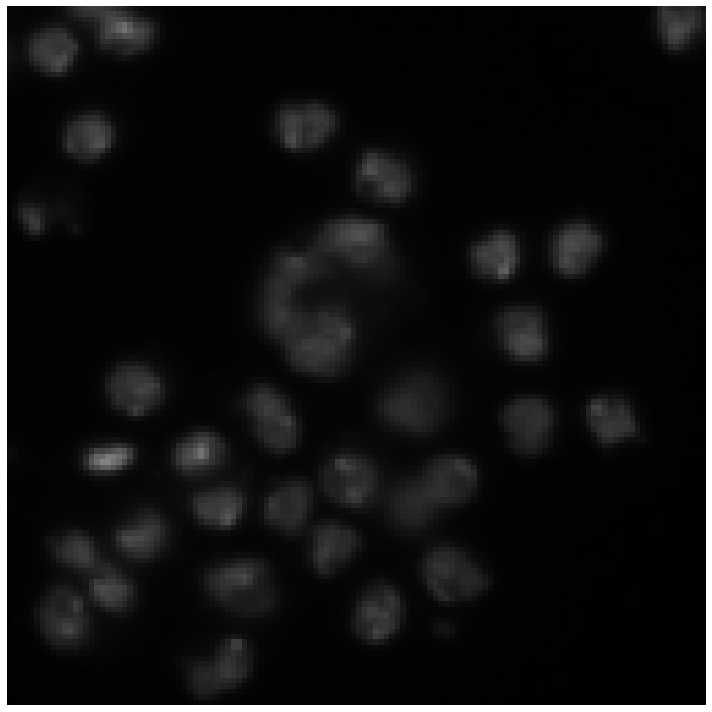

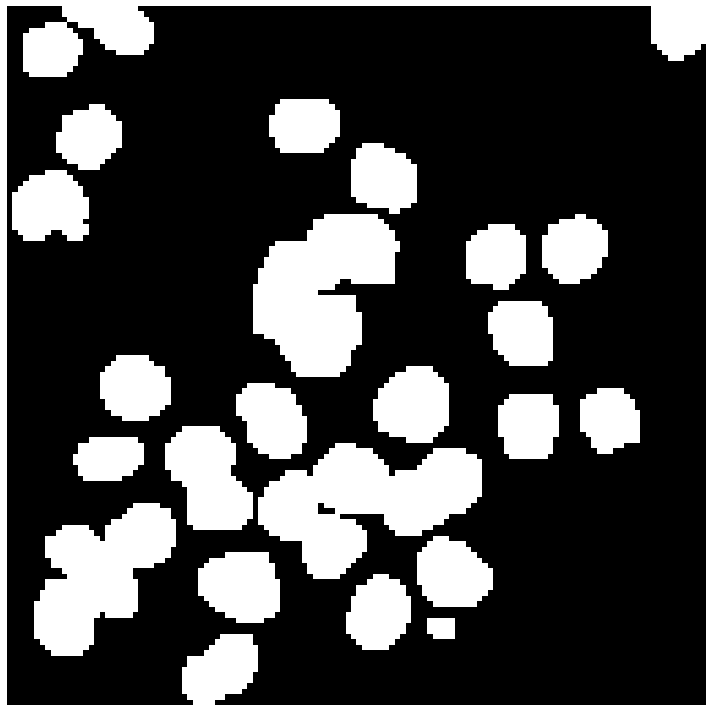

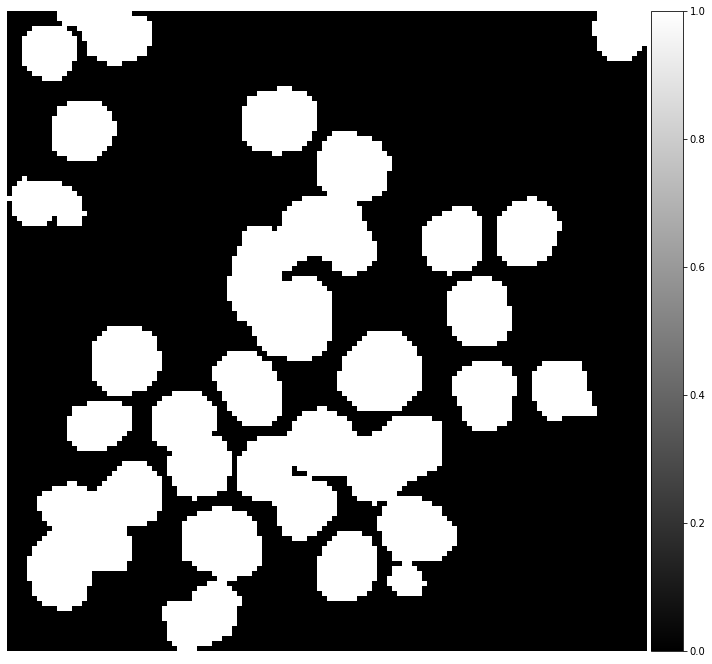

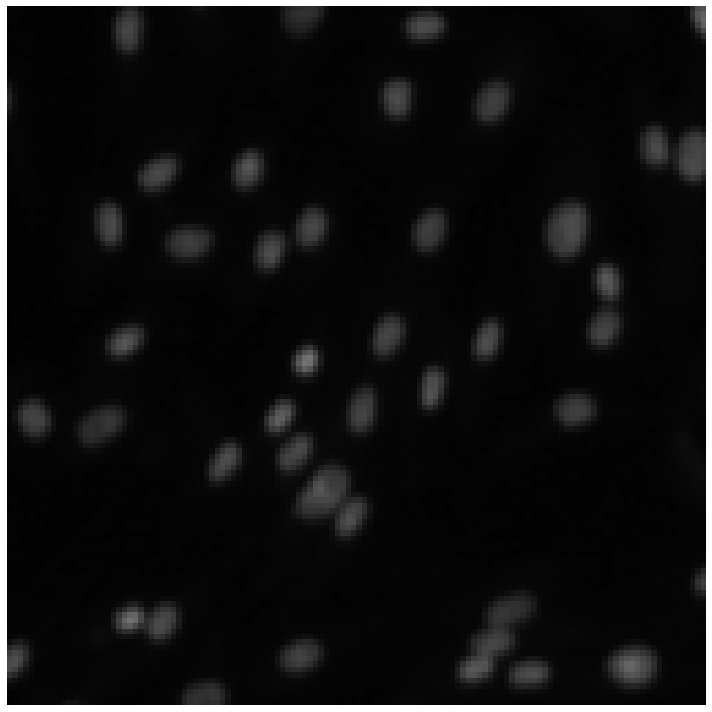

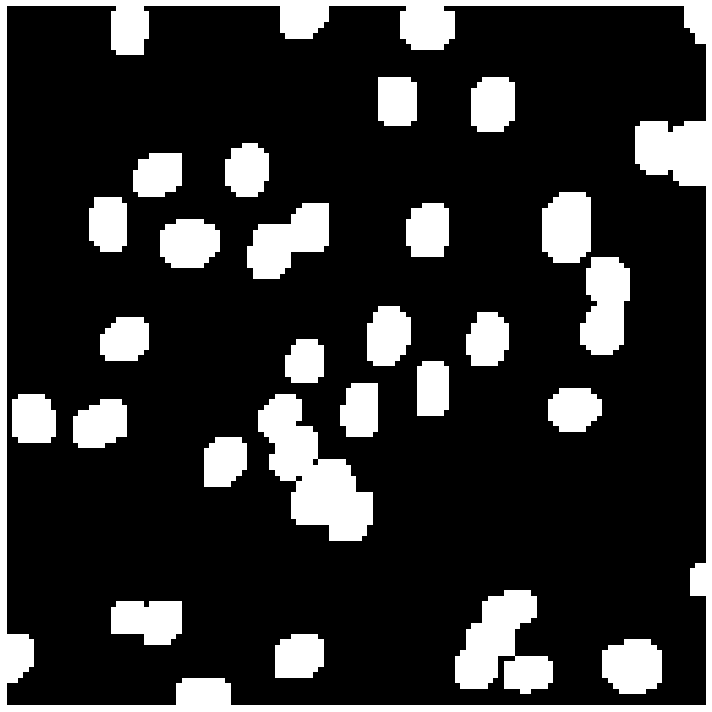

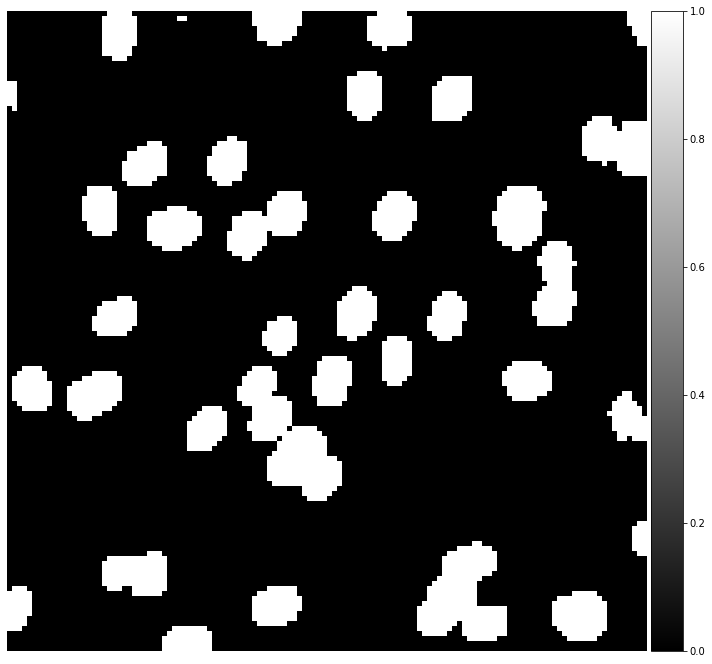

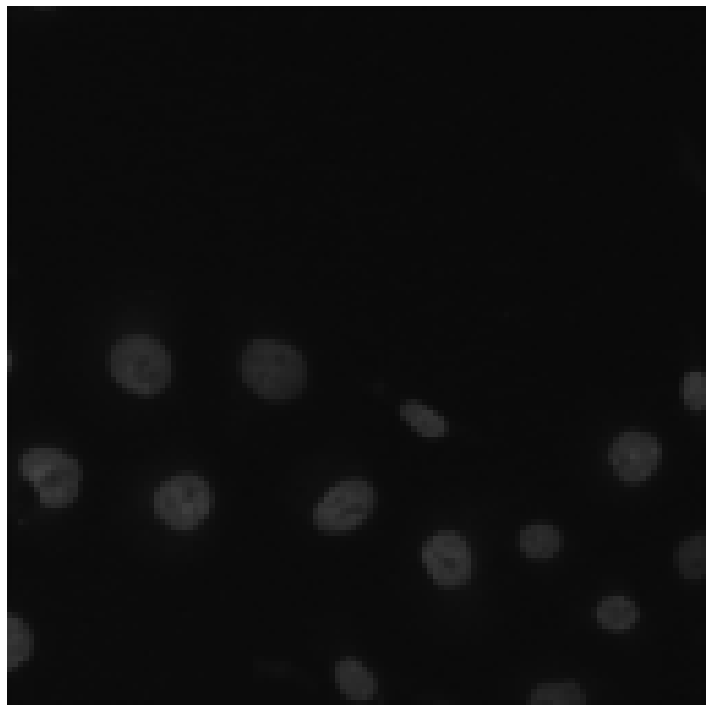

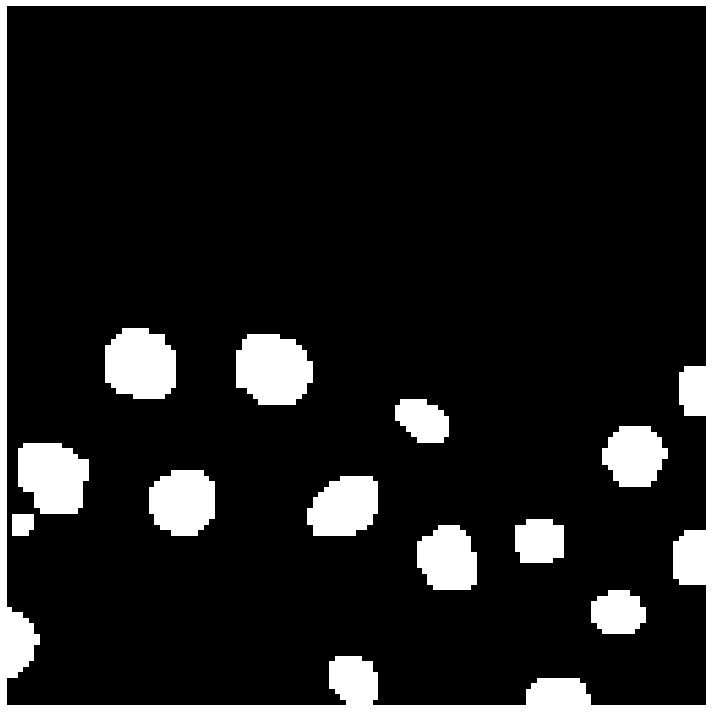

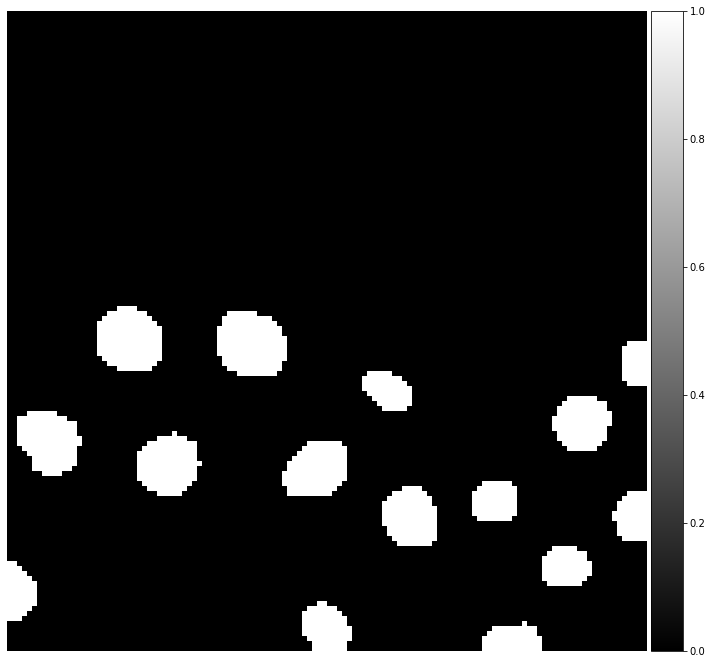

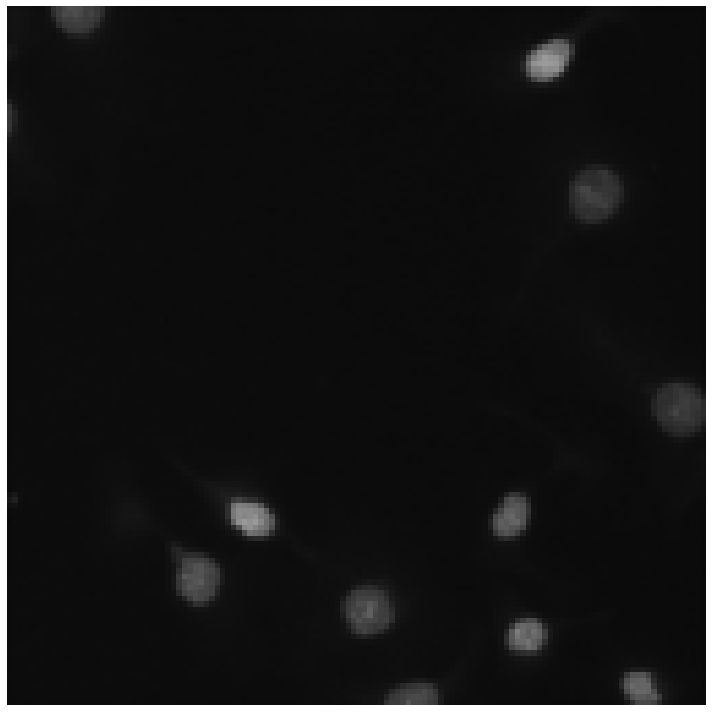

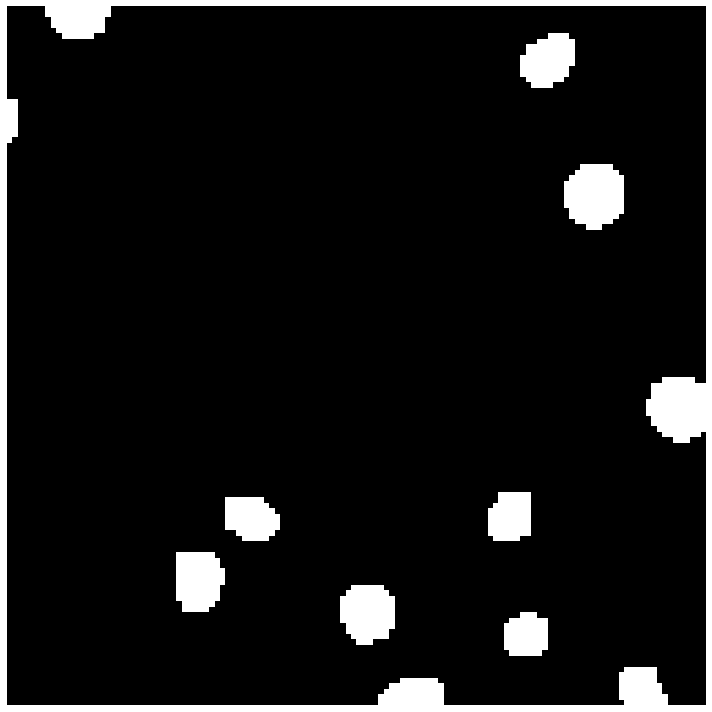

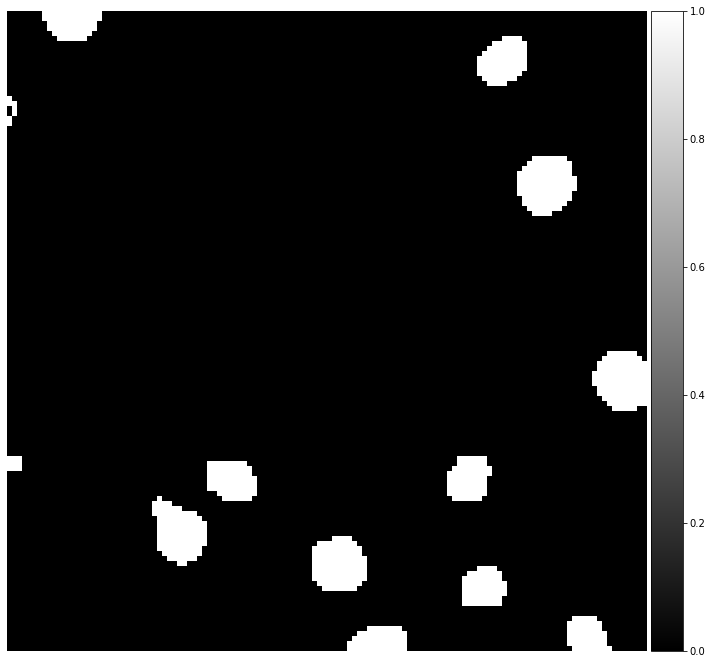

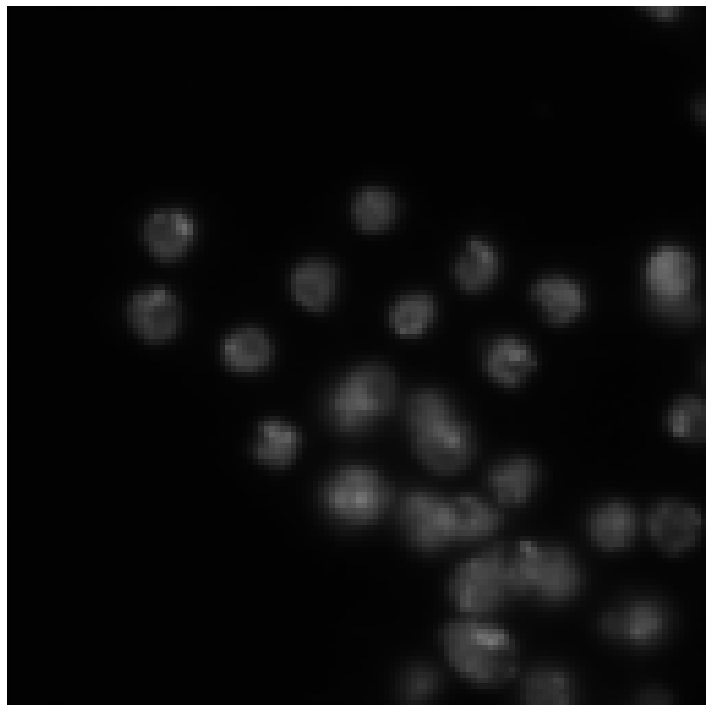

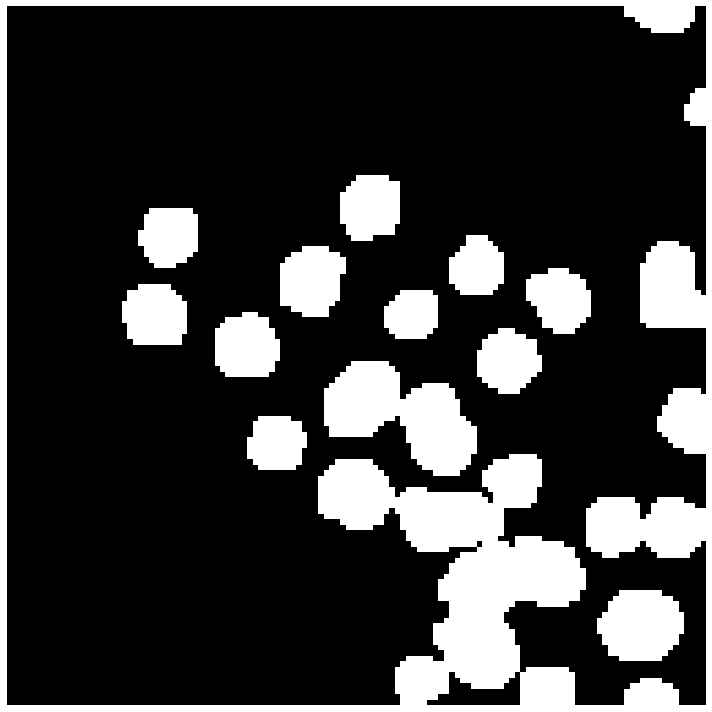

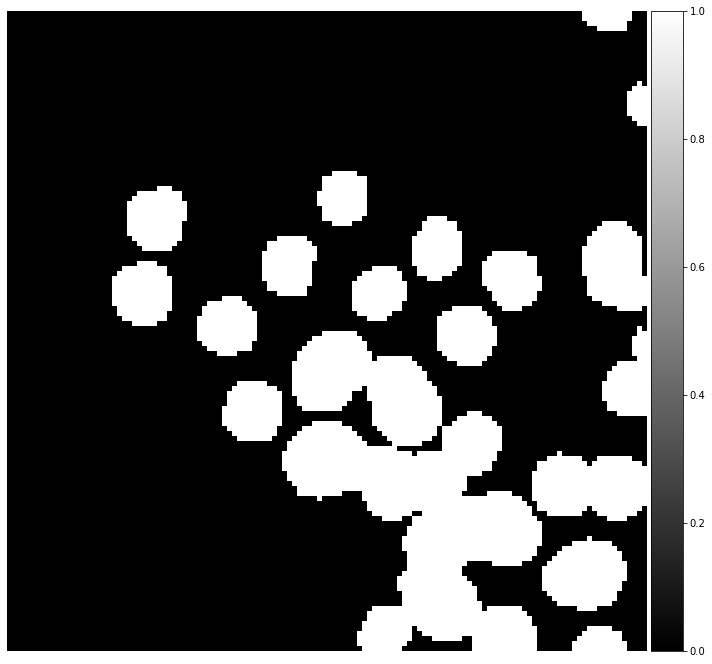

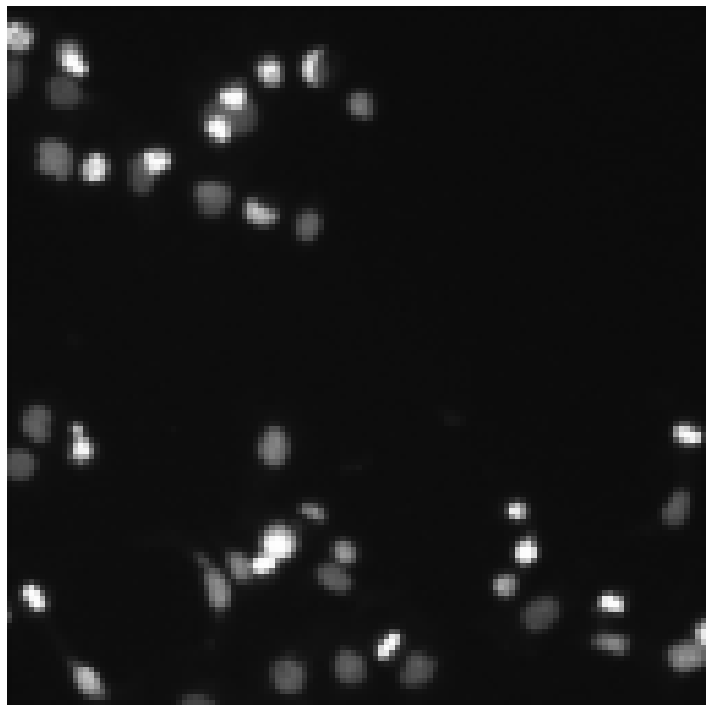

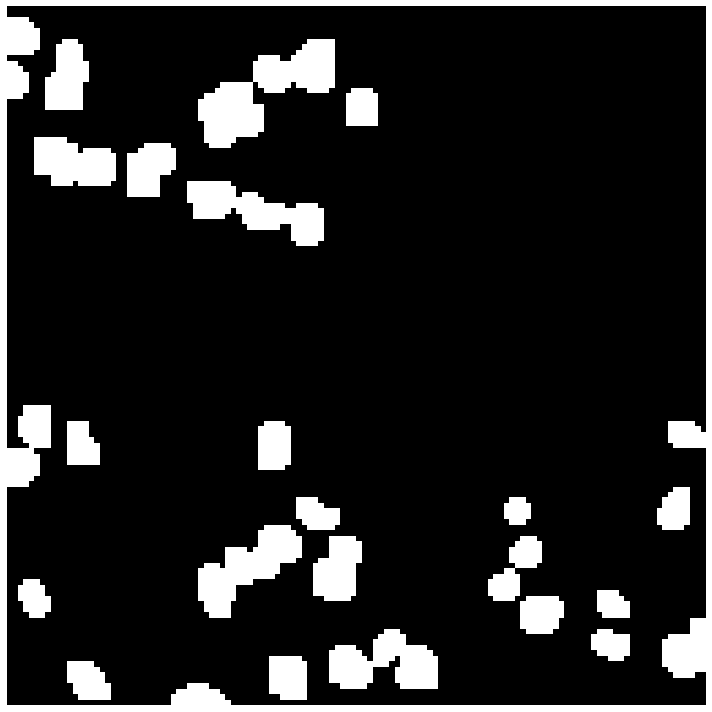

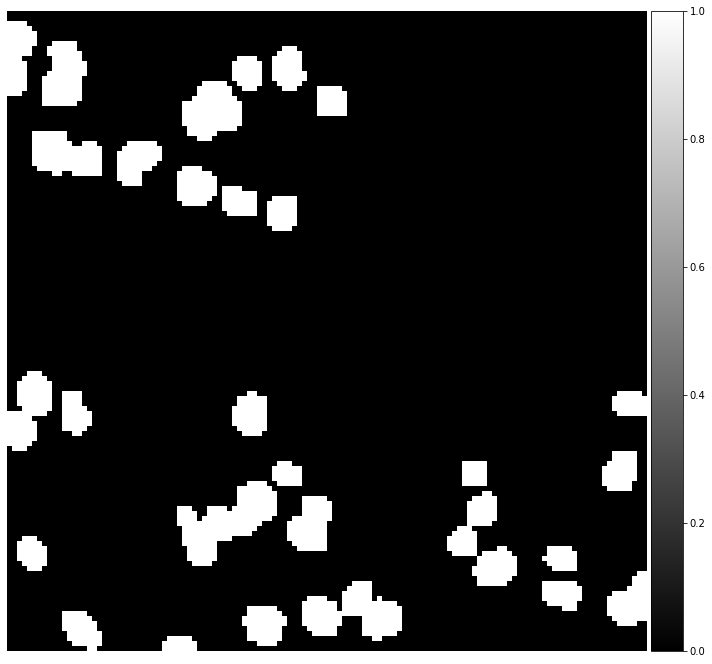

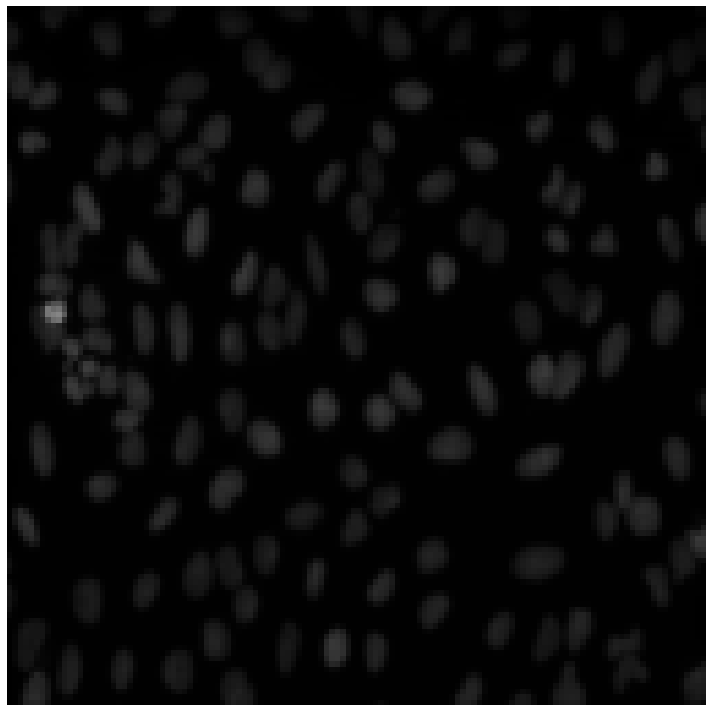

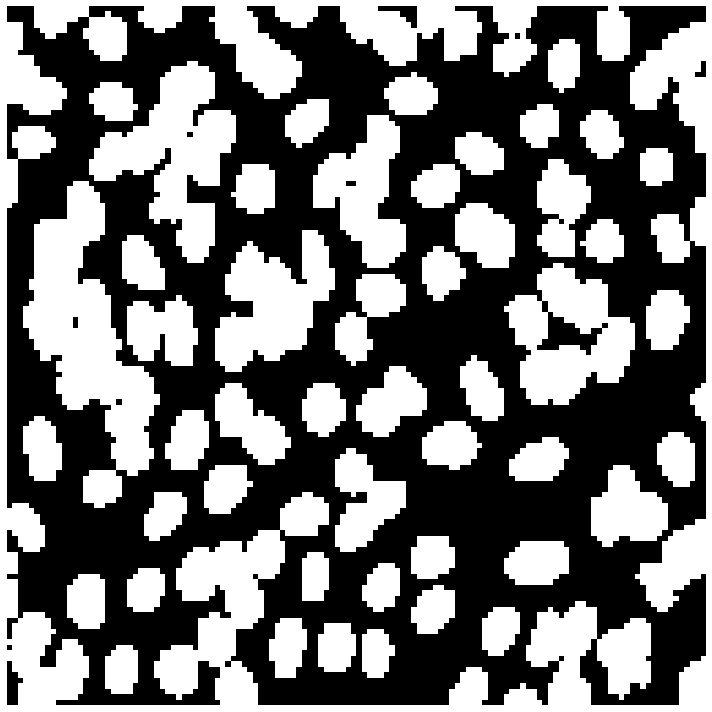

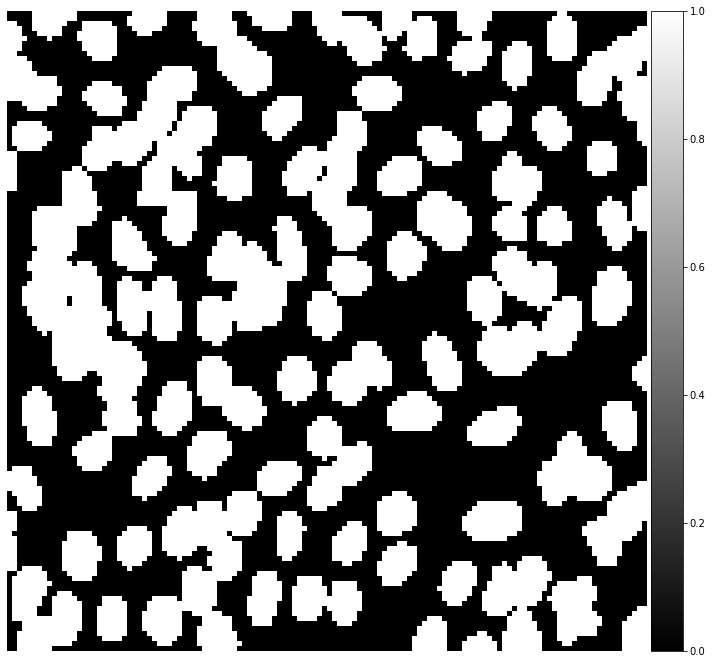

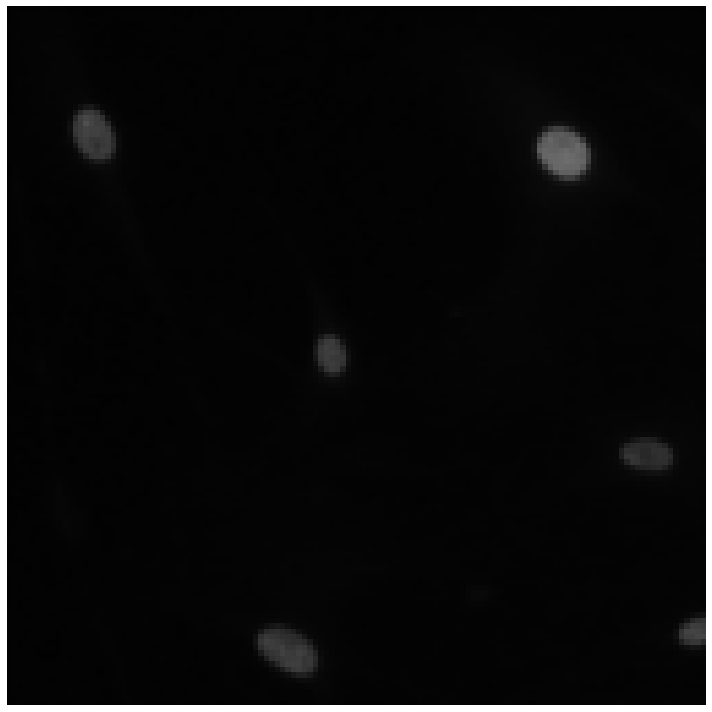

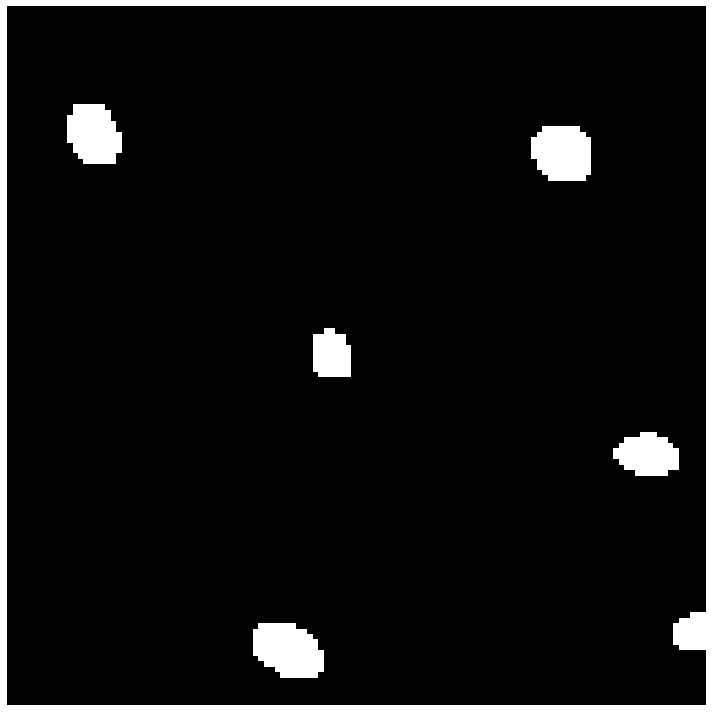

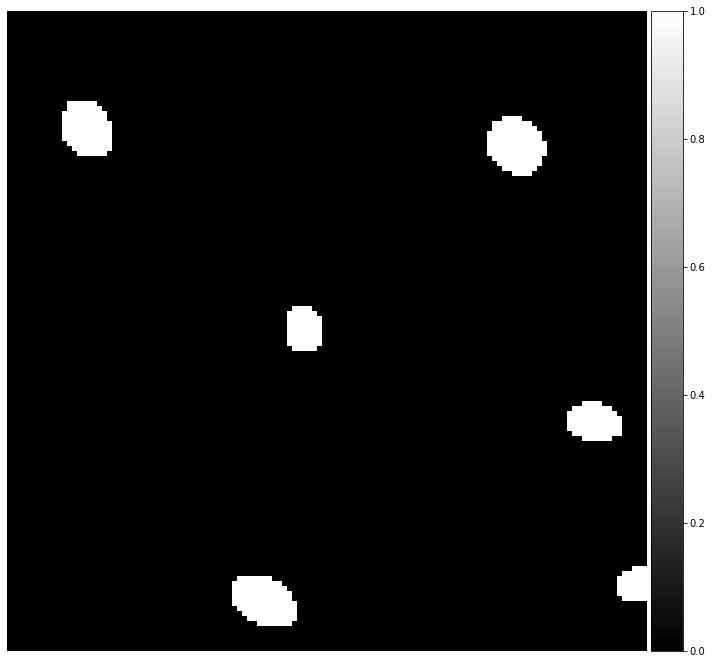

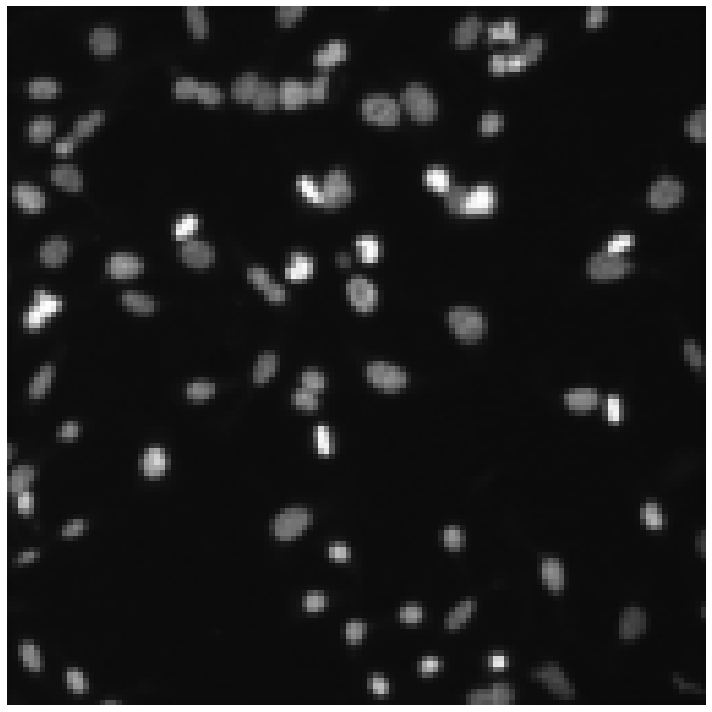

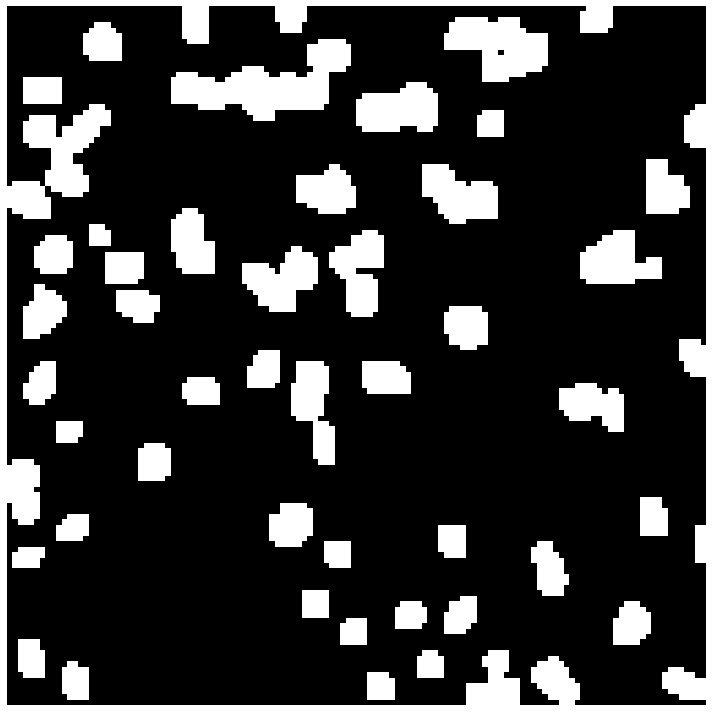

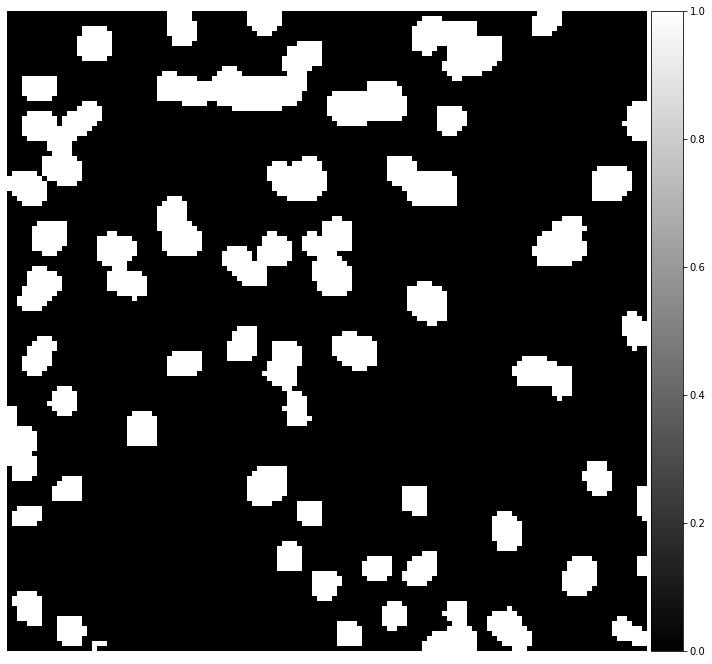

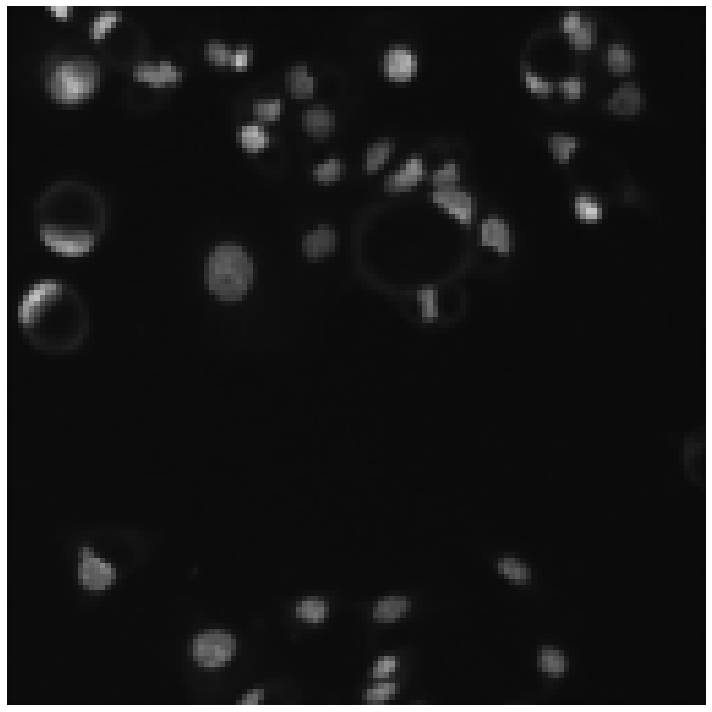

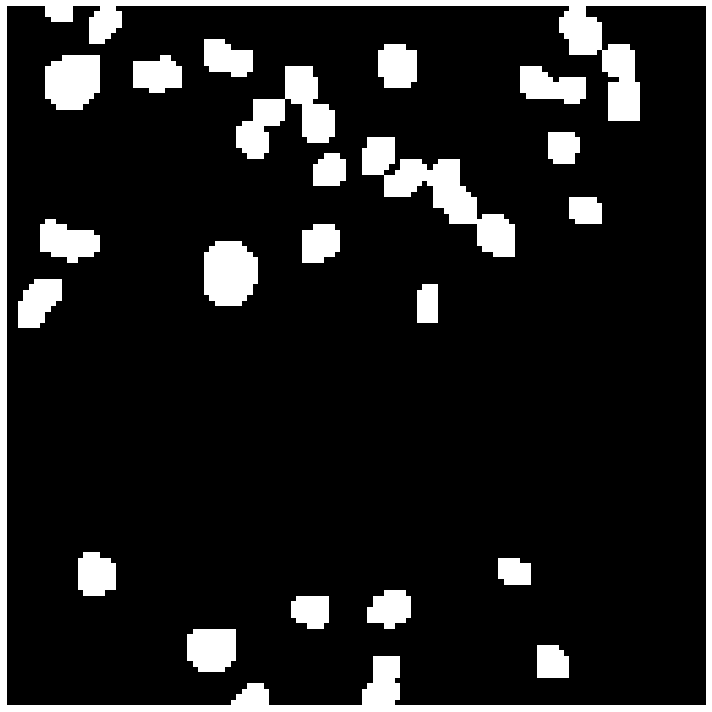

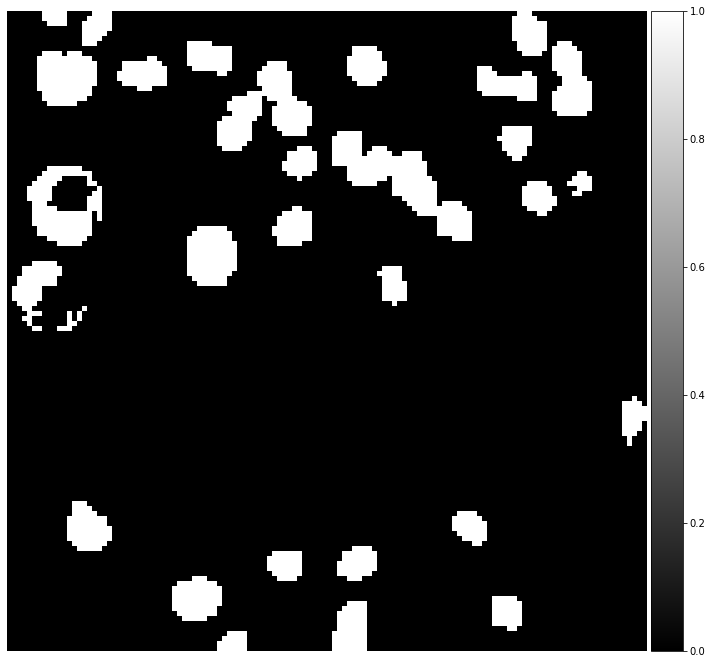

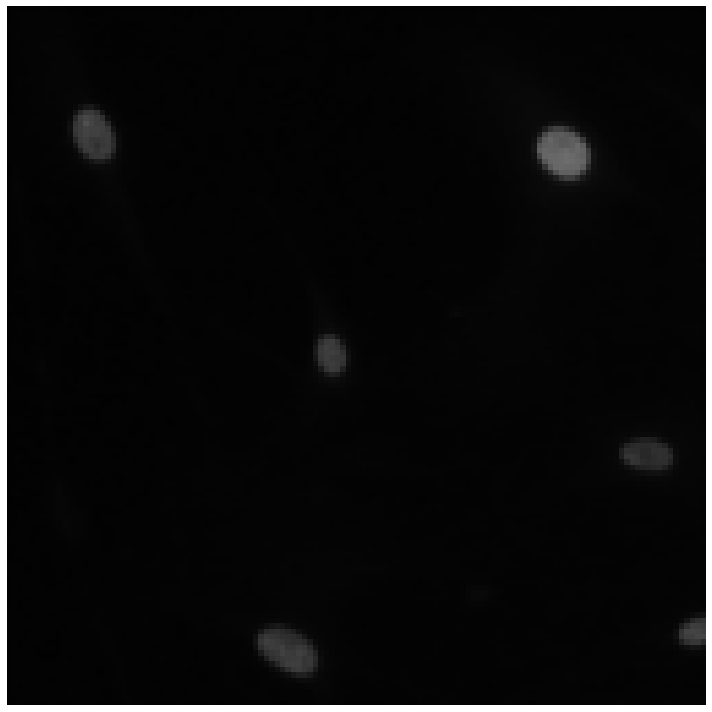

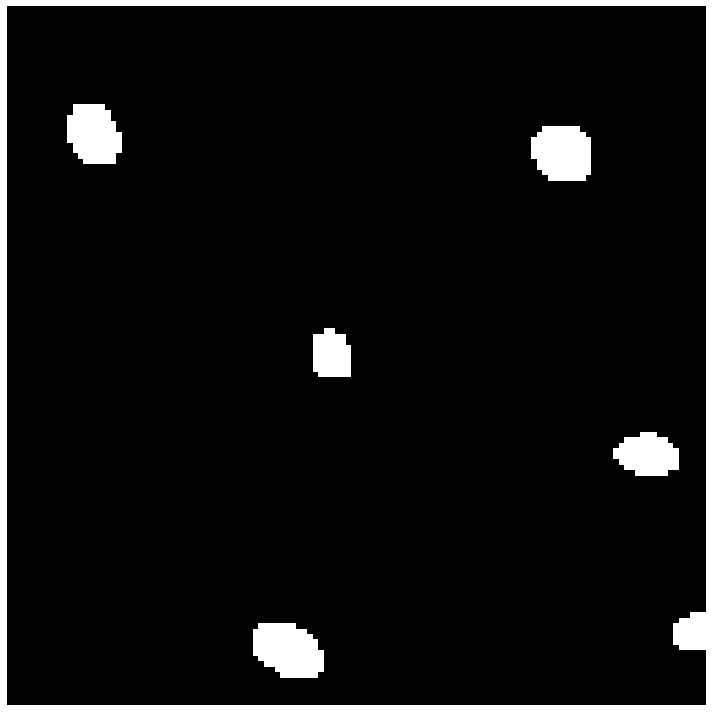

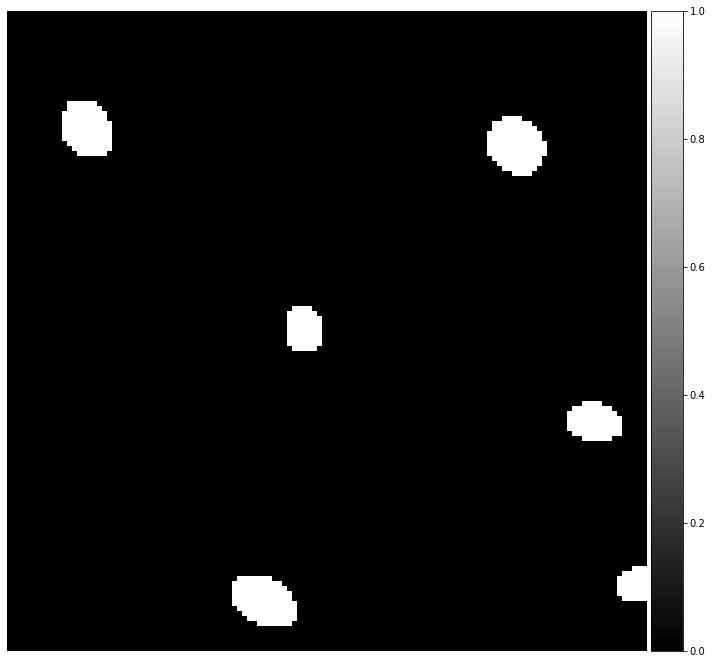

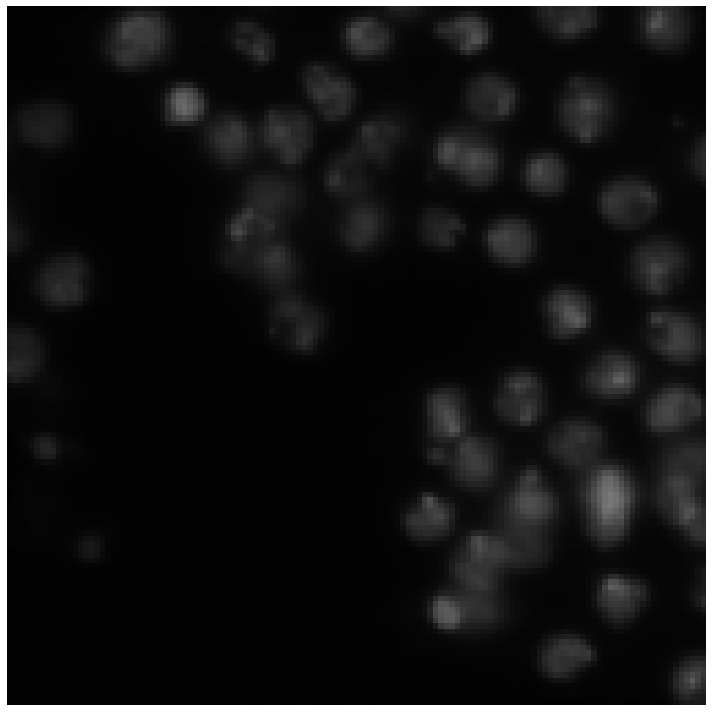

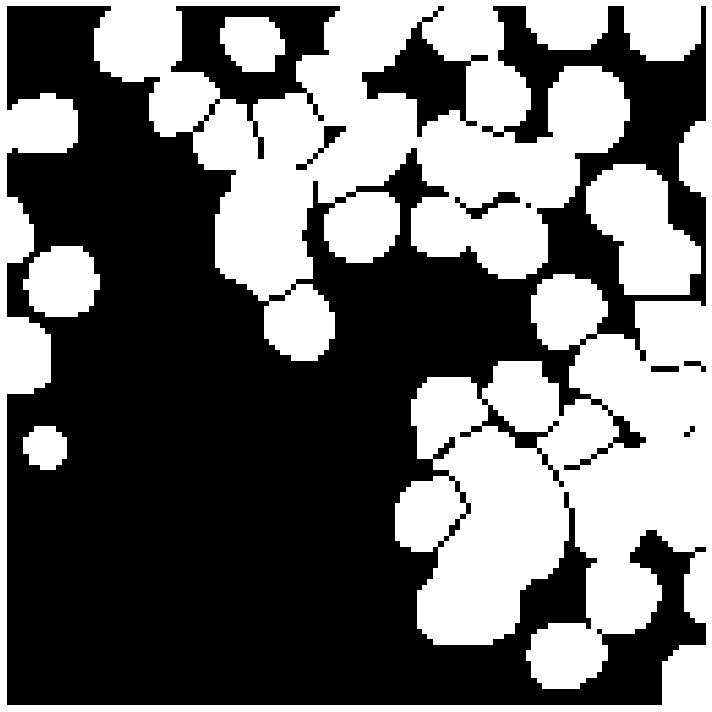

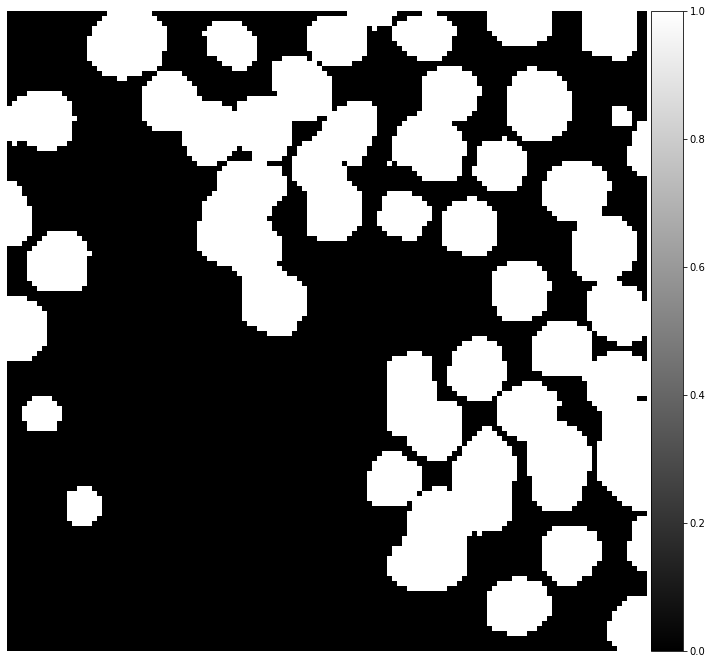

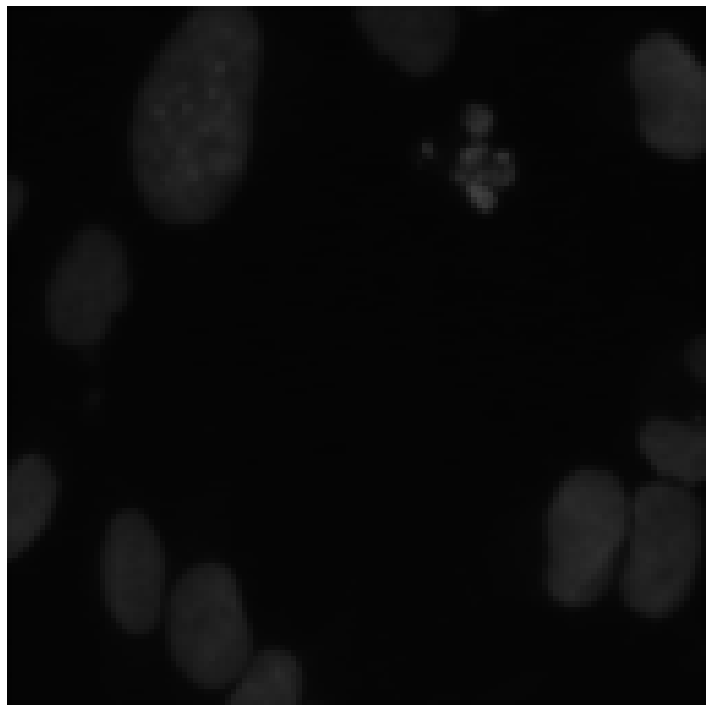

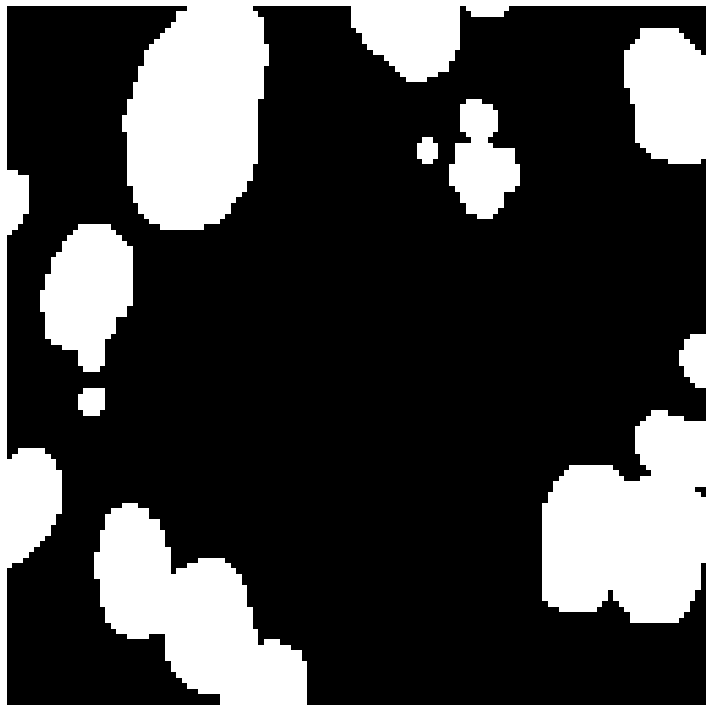

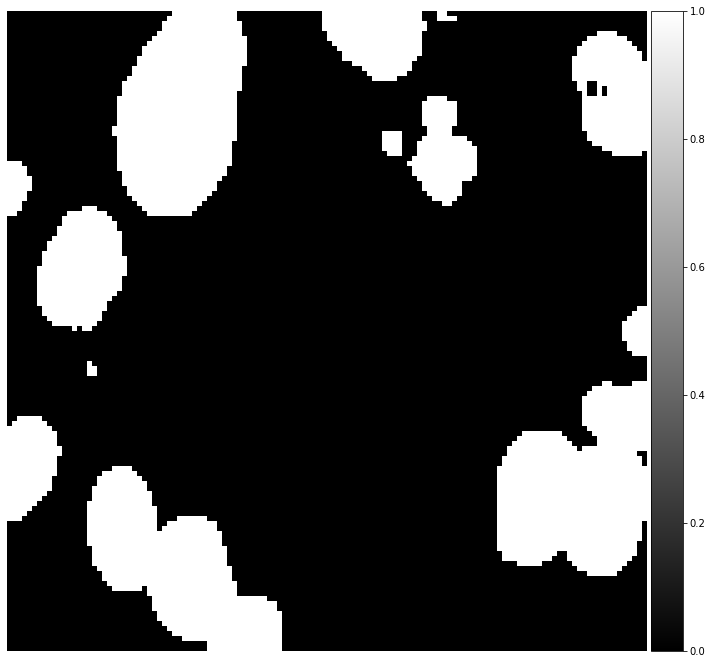

In [14]:
#Teste

for i in range(0, 20):
    
    # Perform a sanity check on some random validation samples
    ix_ = random.randint(0, len(preds_val_t))

    plt.figure(figsize=(10,10))
    plt.axis('off')
    imshow(X_train[int(X_train.shape[0]*0.9):][ix_])
    plt.savefig("./resultadosImages/Teste/ImageTest{}.png".format(i))
    plt.show()

    plt.figure(figsize=(10,10))
    plt.axis('off')
    imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix_]), cmap=plt.cm.gray)
    plt.savefig("./resultadosImages/Teste/figUnetNucleiTest{}.png".format(i))
    plt.show()

    plt.figure(figsize=(10,10))
    plt.axis('off')
    imshow(np.squeeze(preds_val_t[ix_]), cmap=plt.cm.gray)
    plt.savefig("./resultadosImages/Teste/figUnetNucleiTestPred{}.png".format(i))
    plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3019/3019 [00:56<00:00, 53.55it/s]


Done!
95/95 [==============================] - ETA:  - 3s 34ms/step


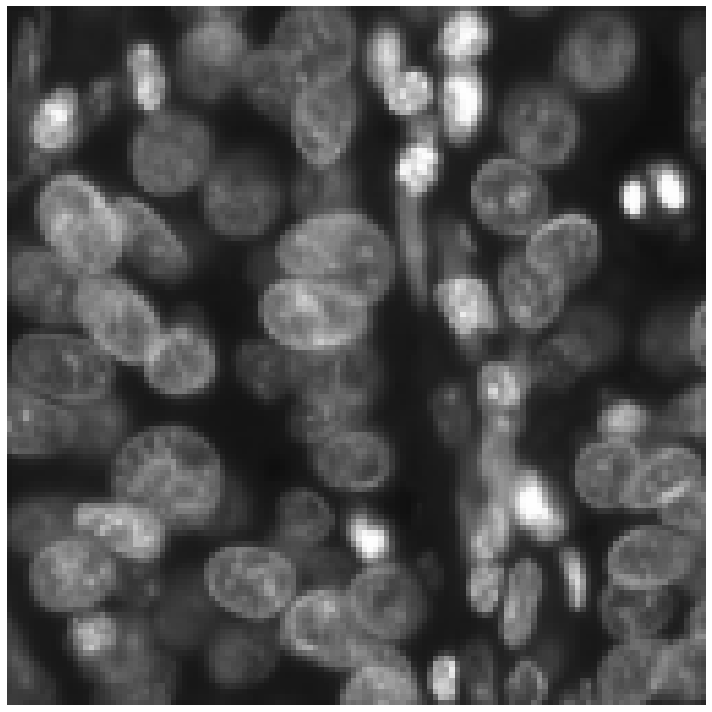

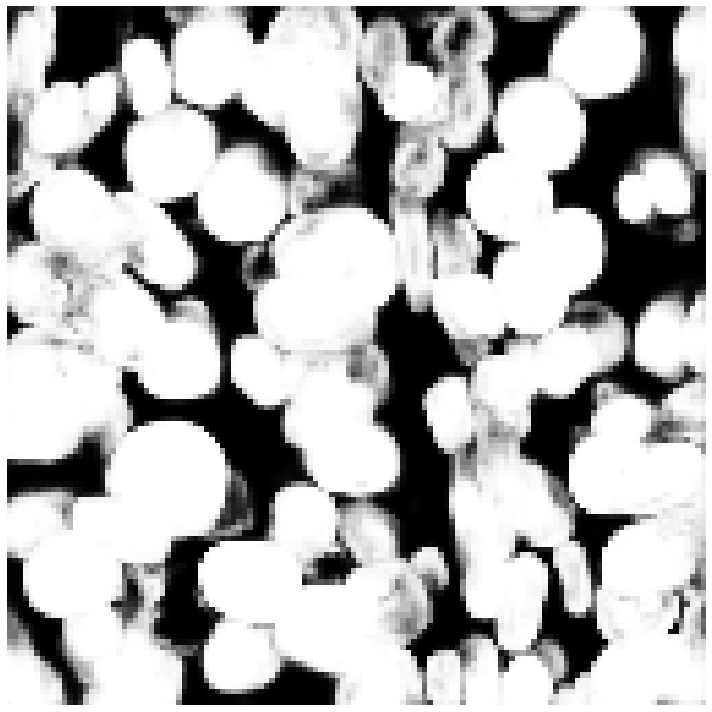

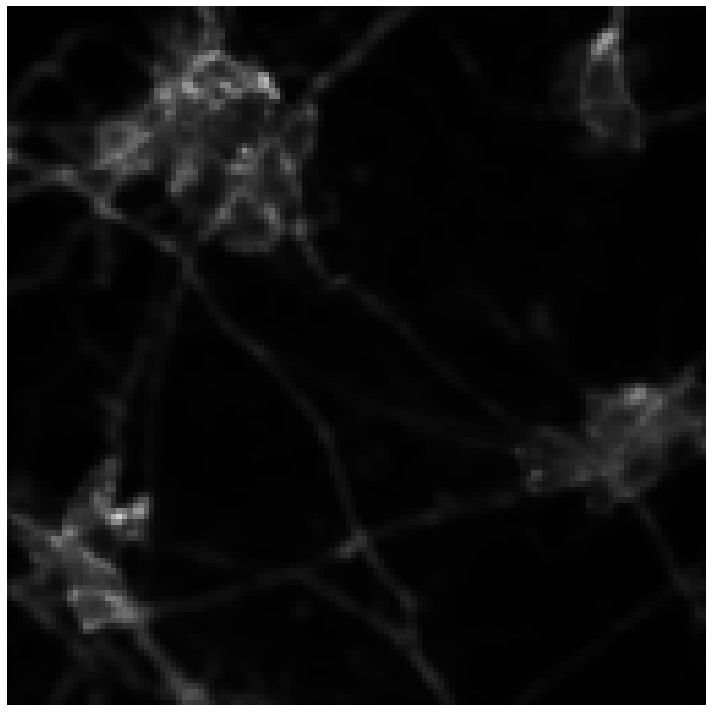

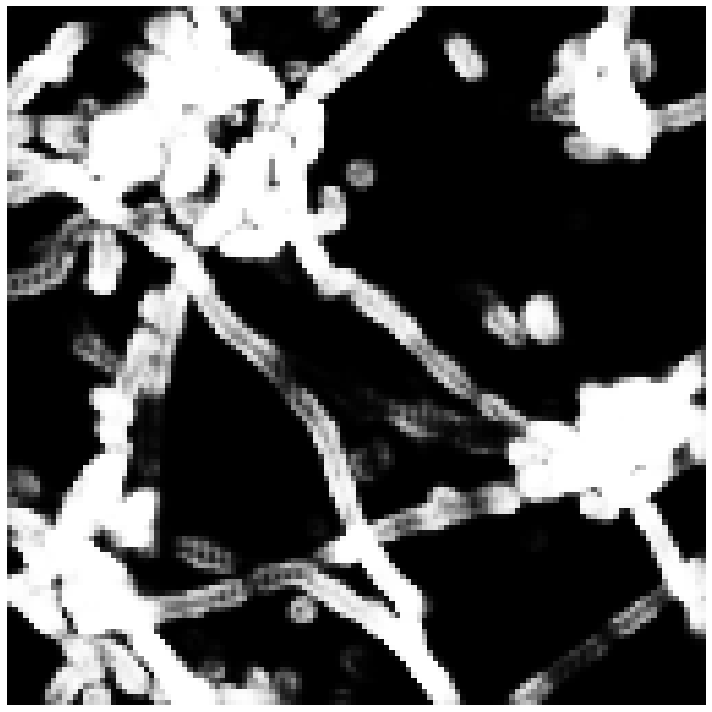

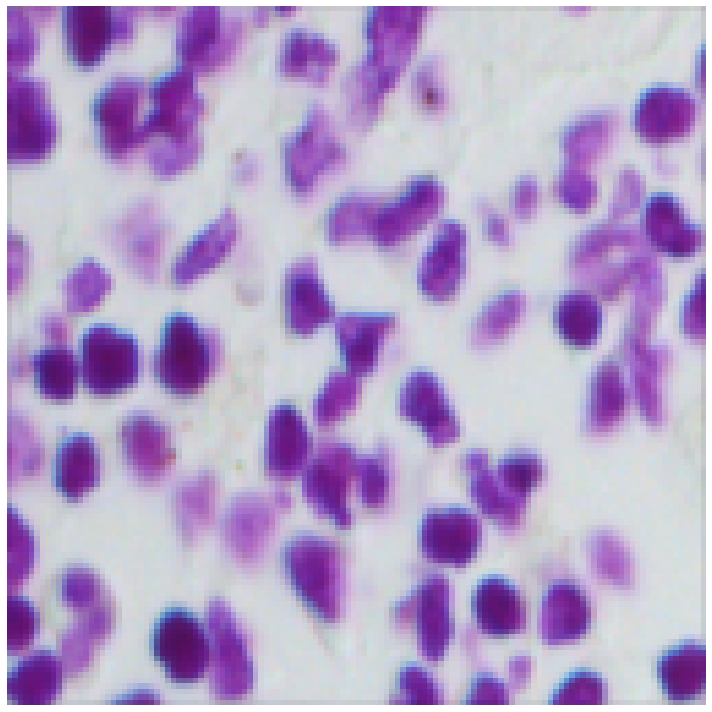

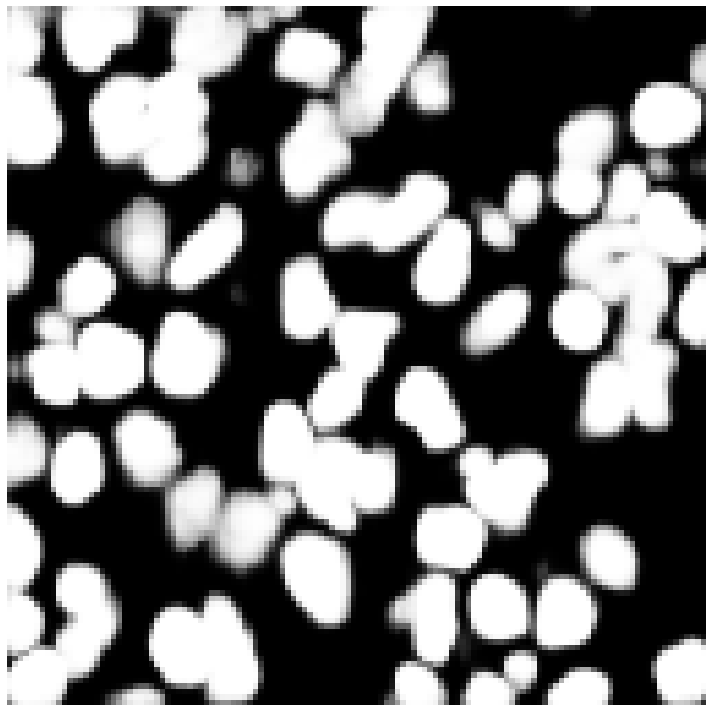

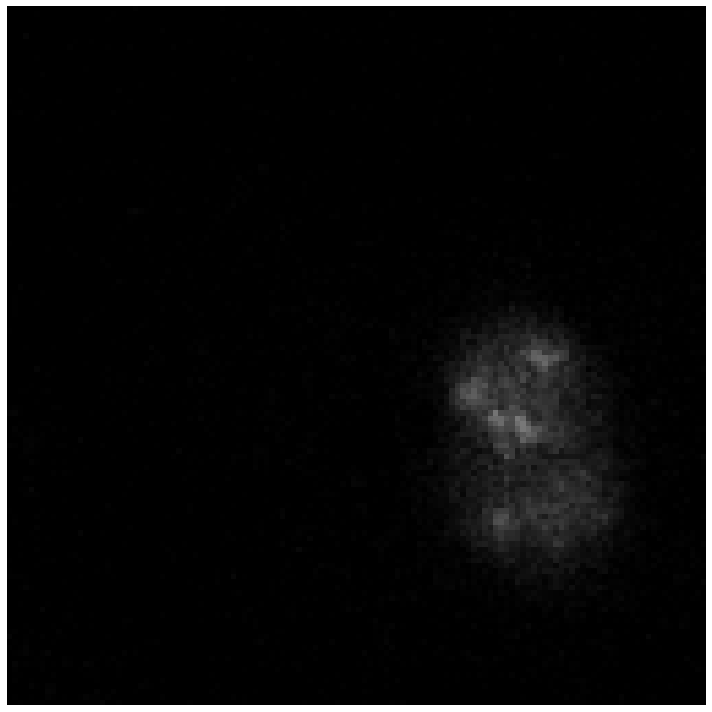

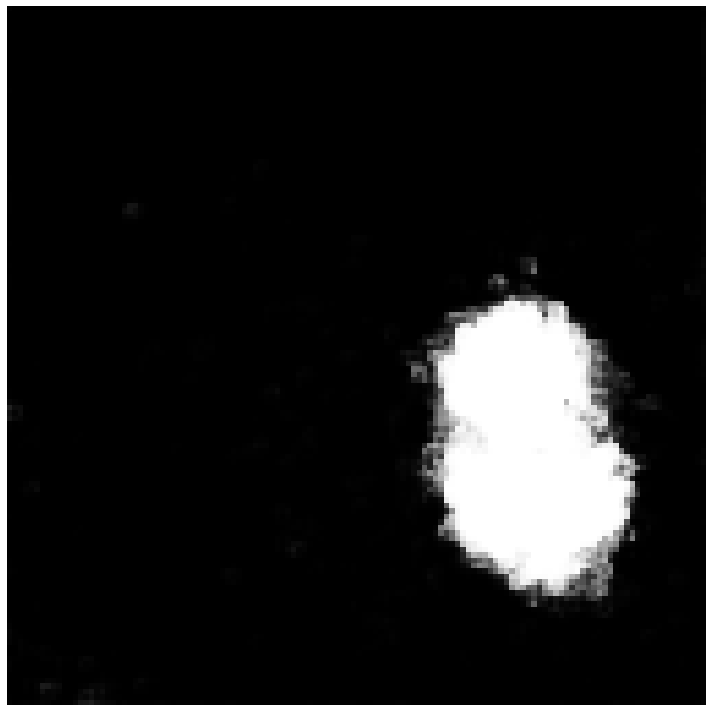

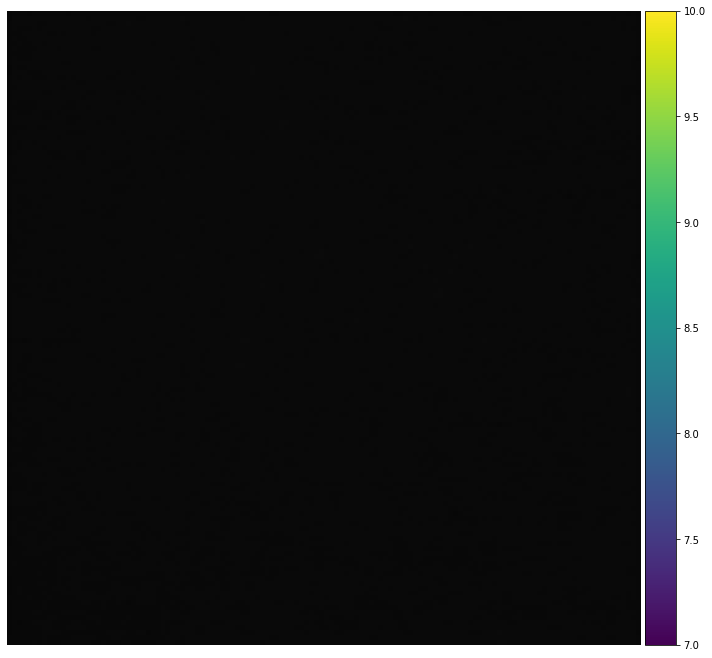

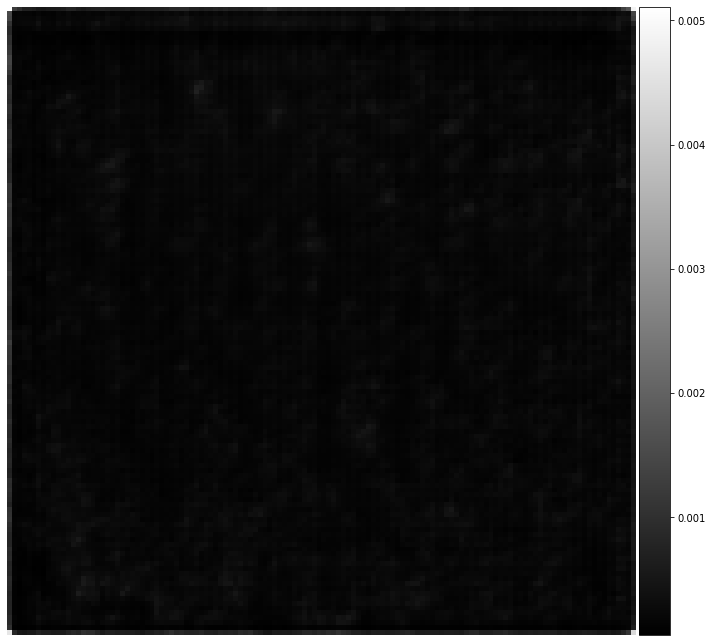

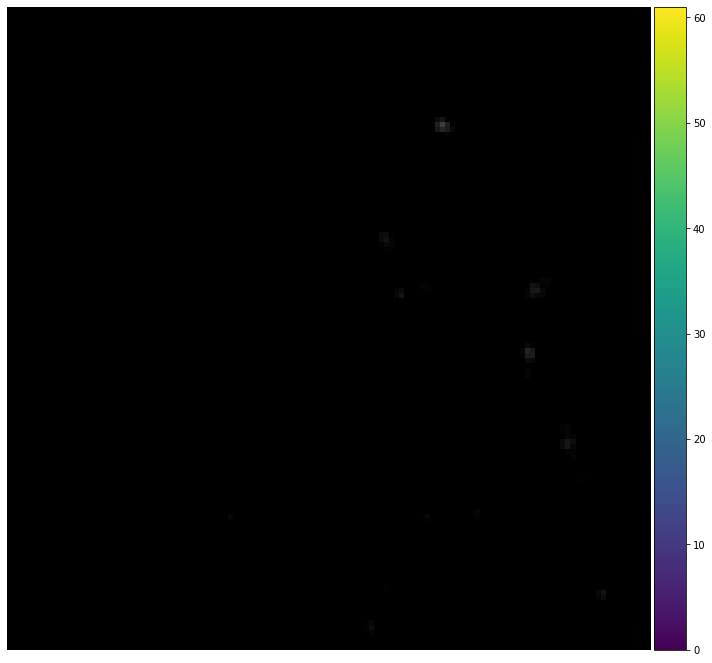

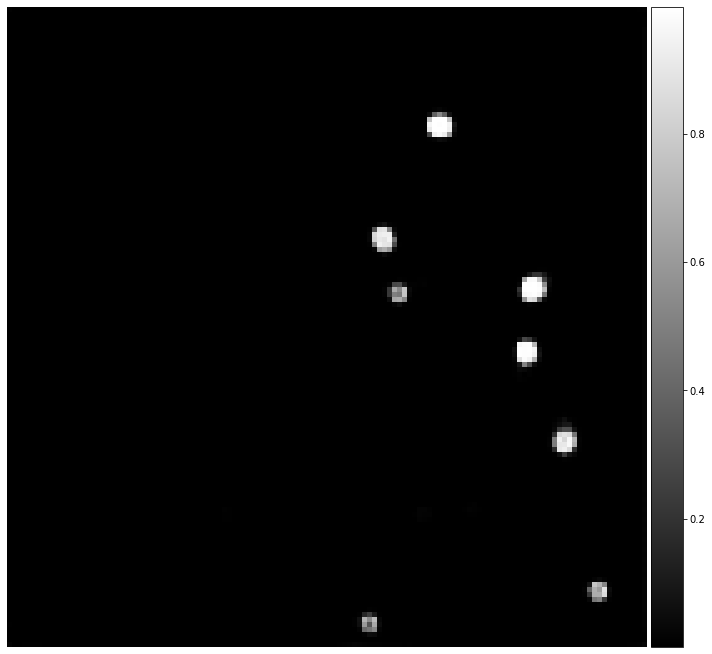

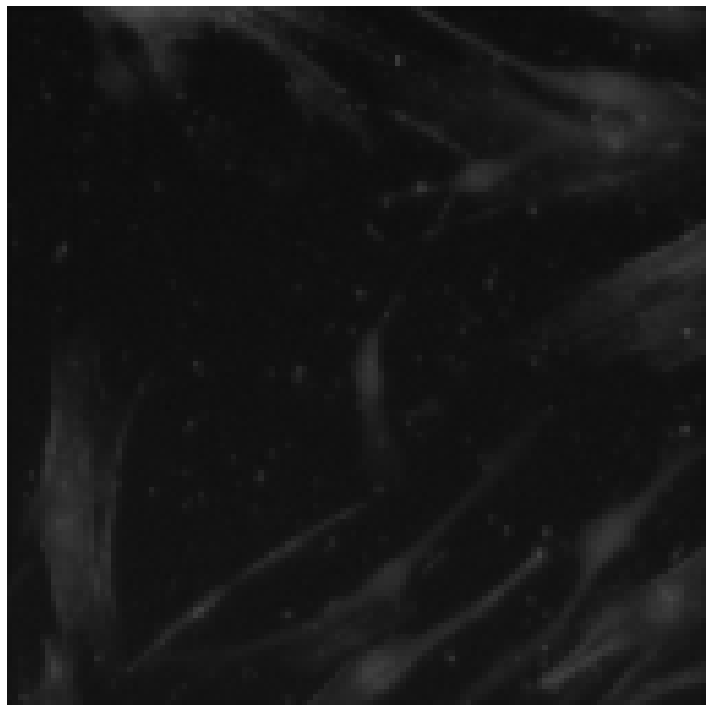

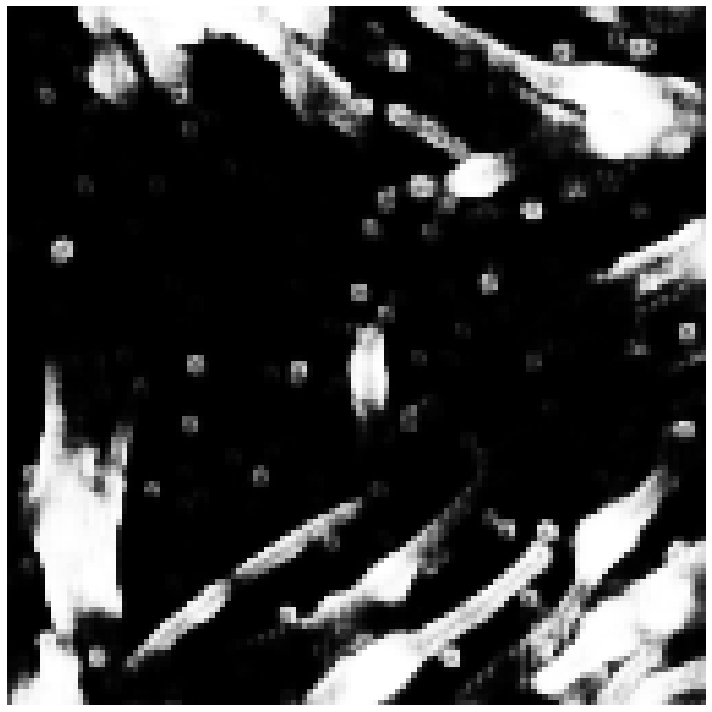

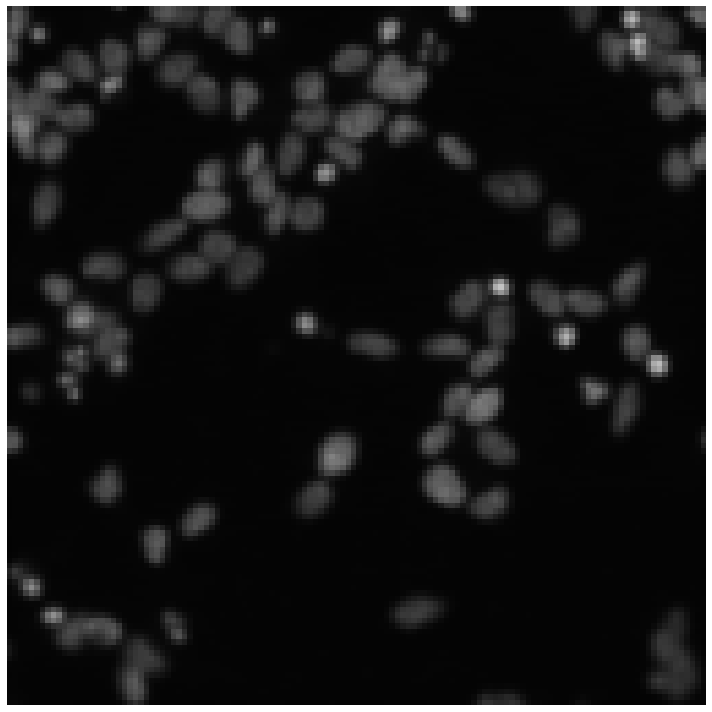

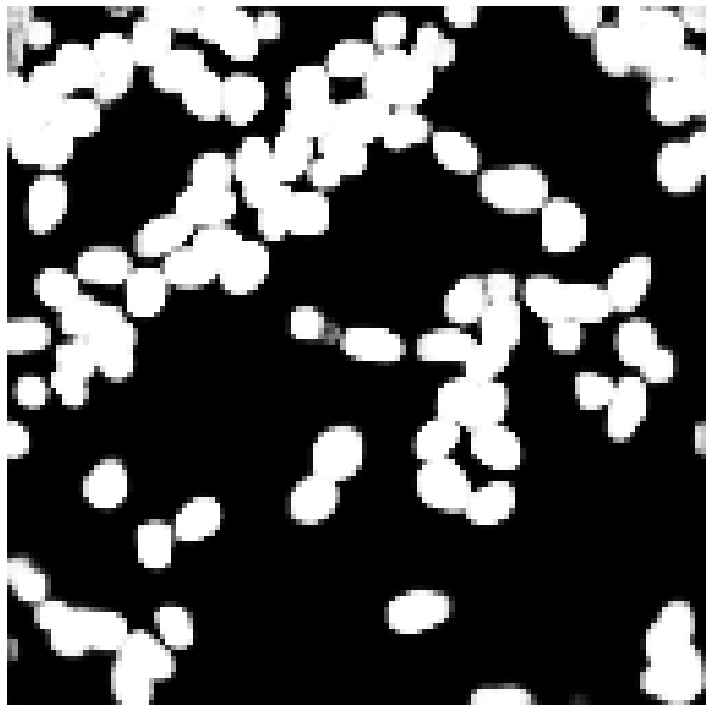

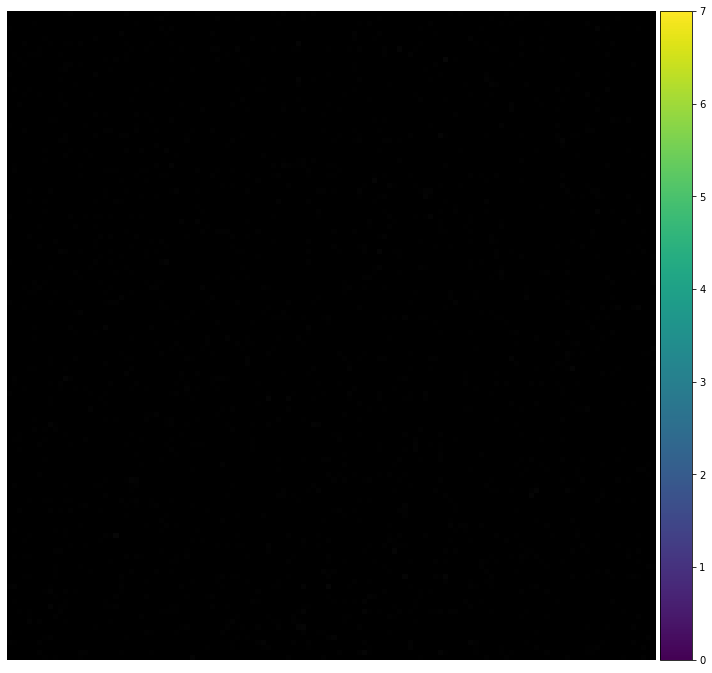

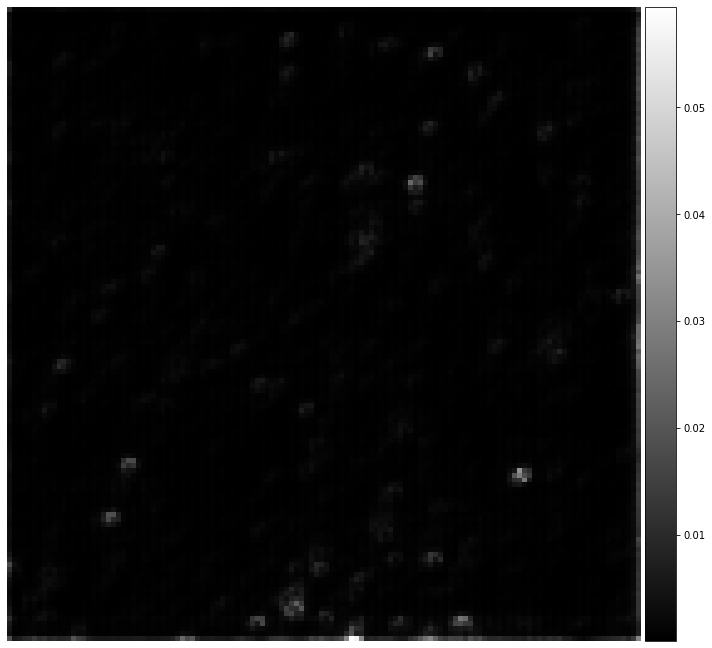

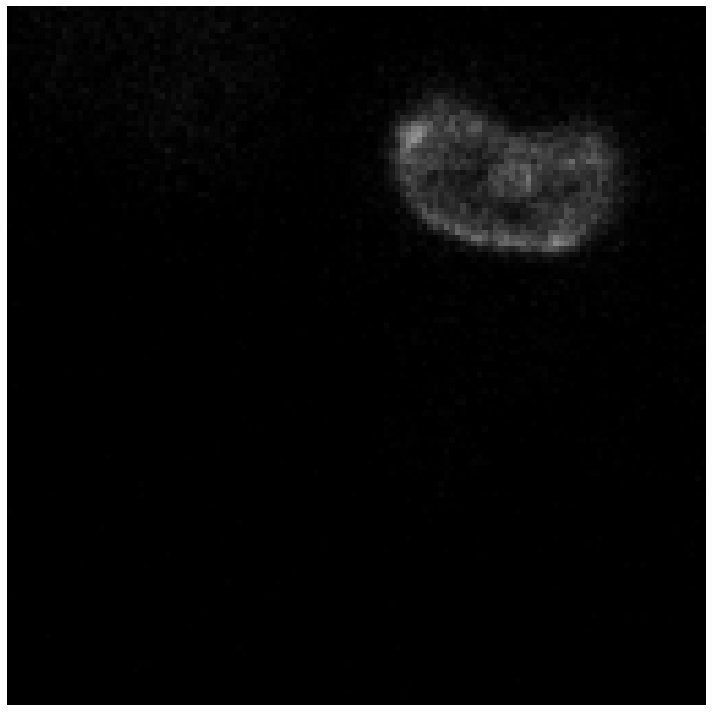

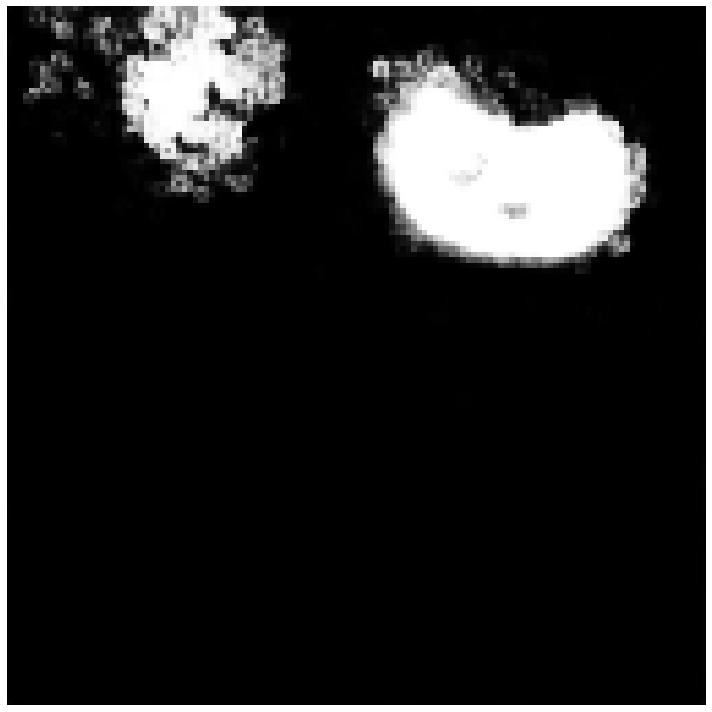

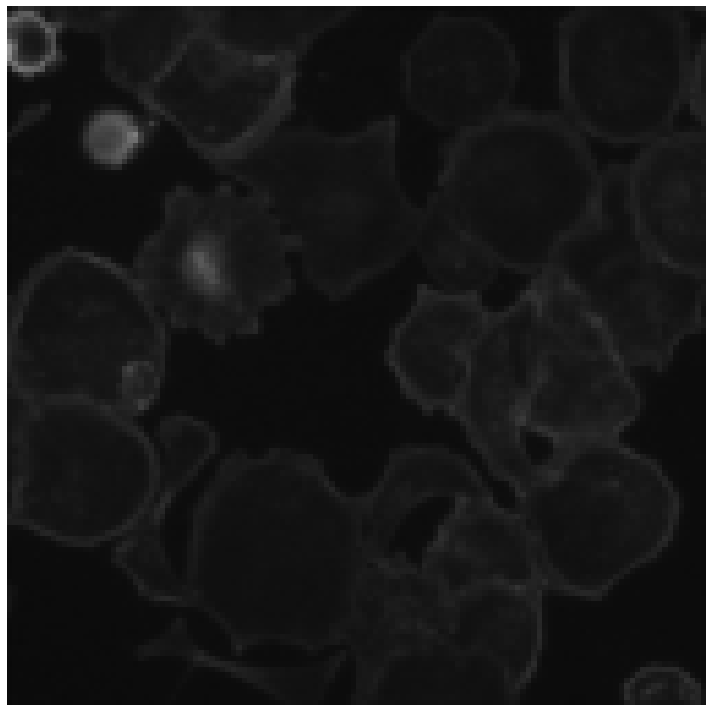

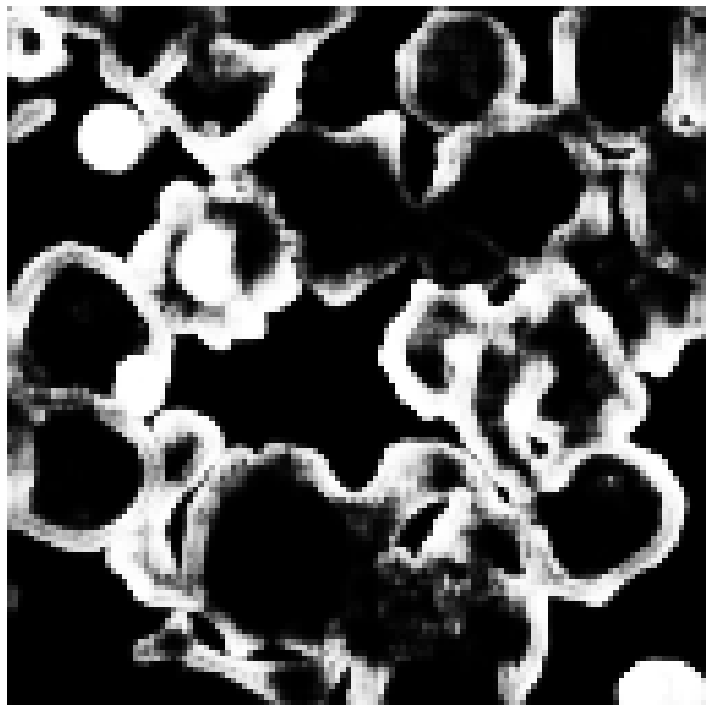

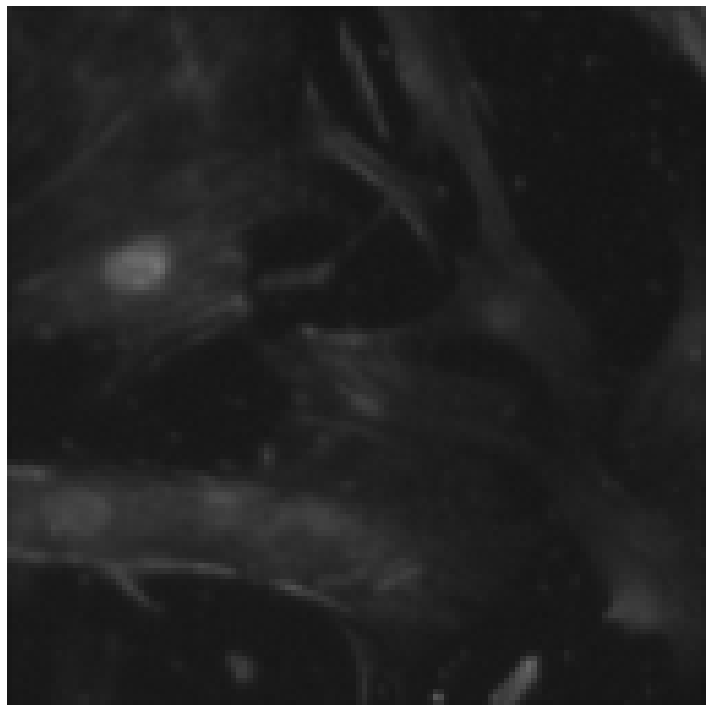

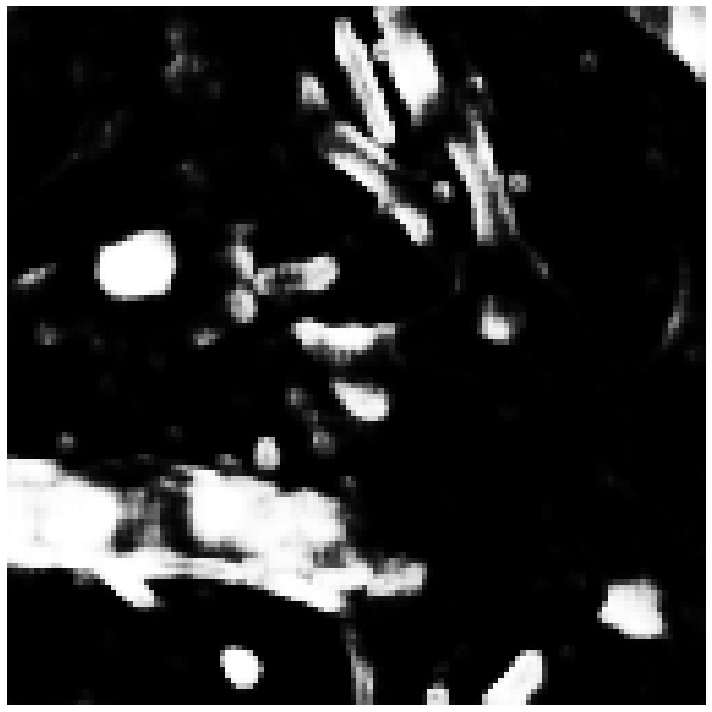

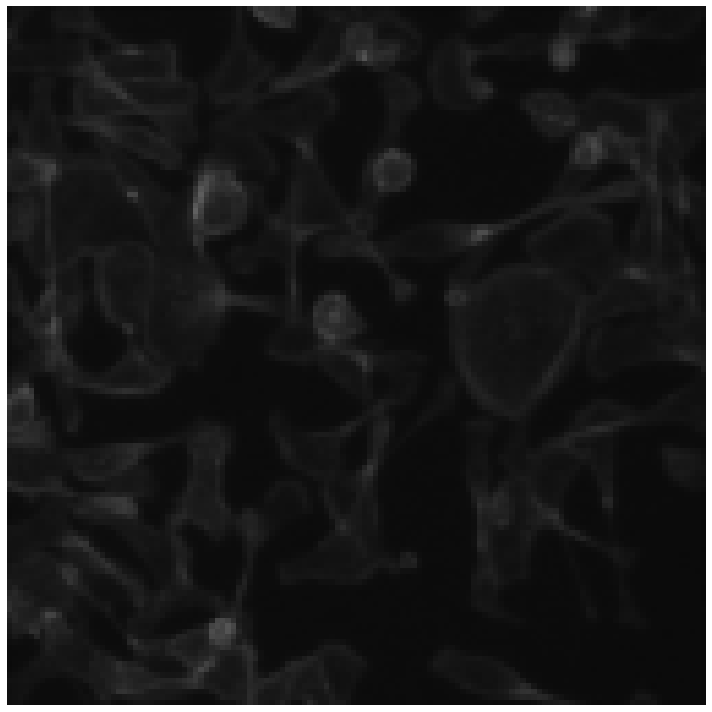

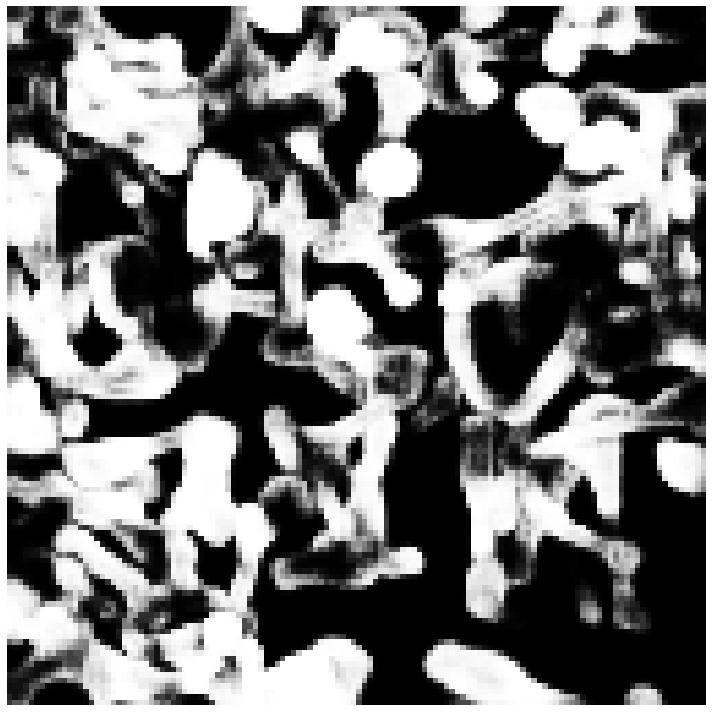

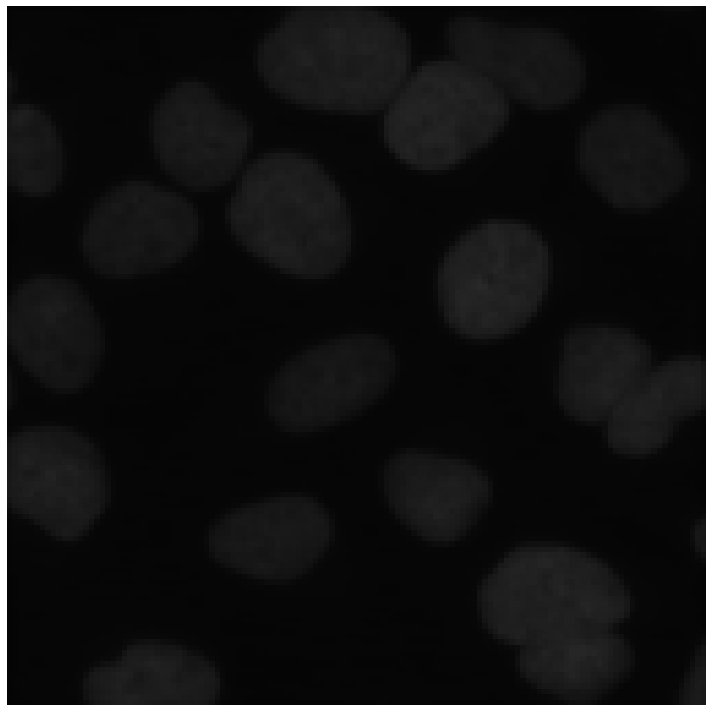

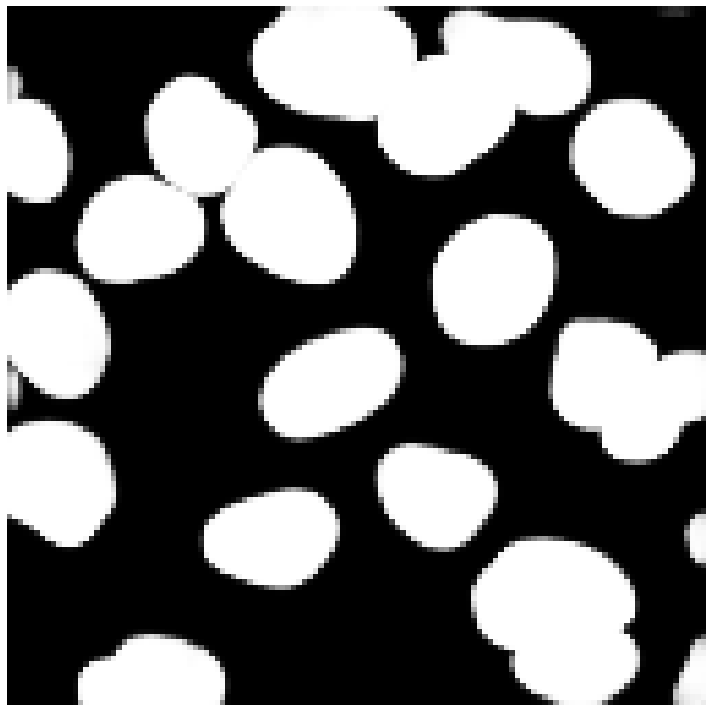

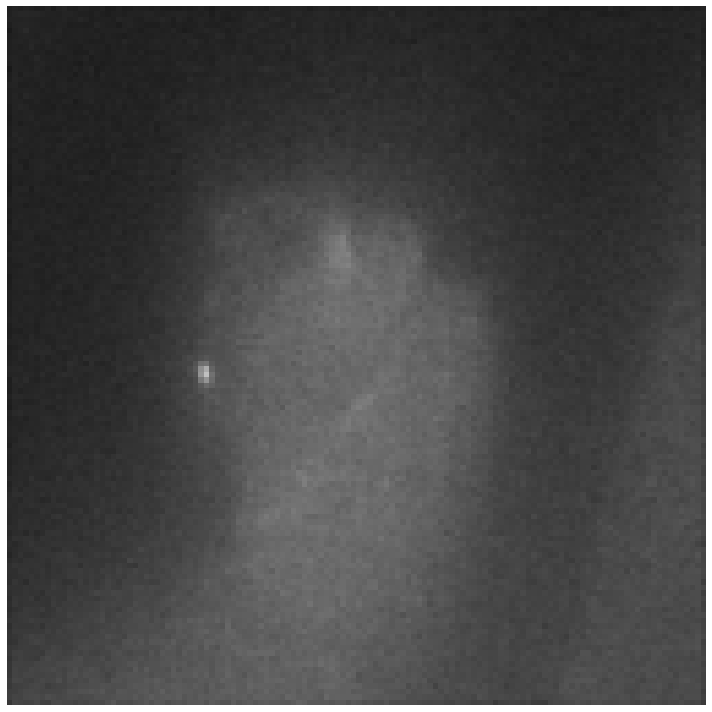

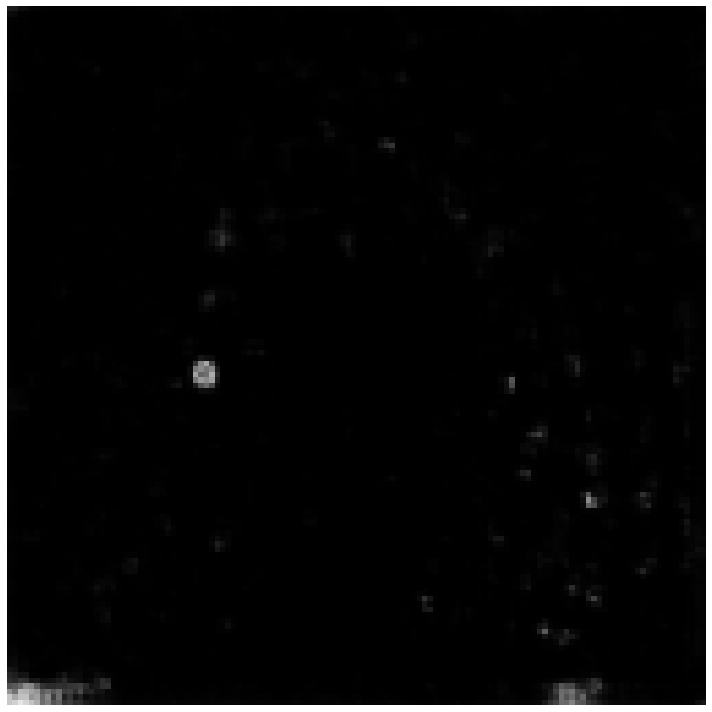

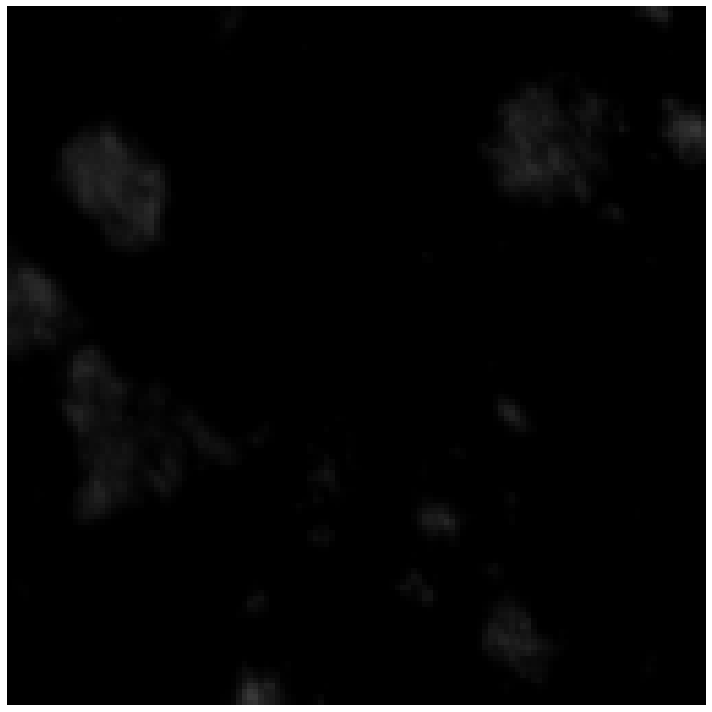

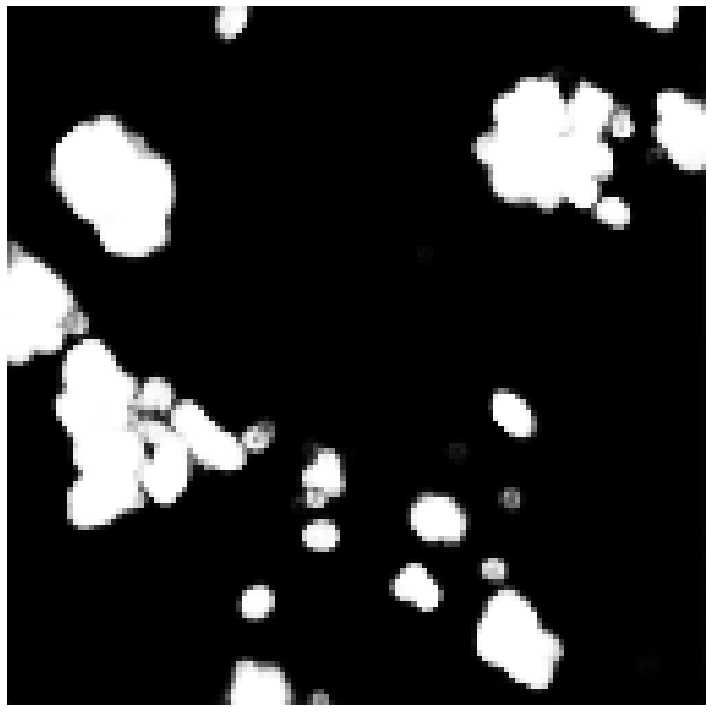

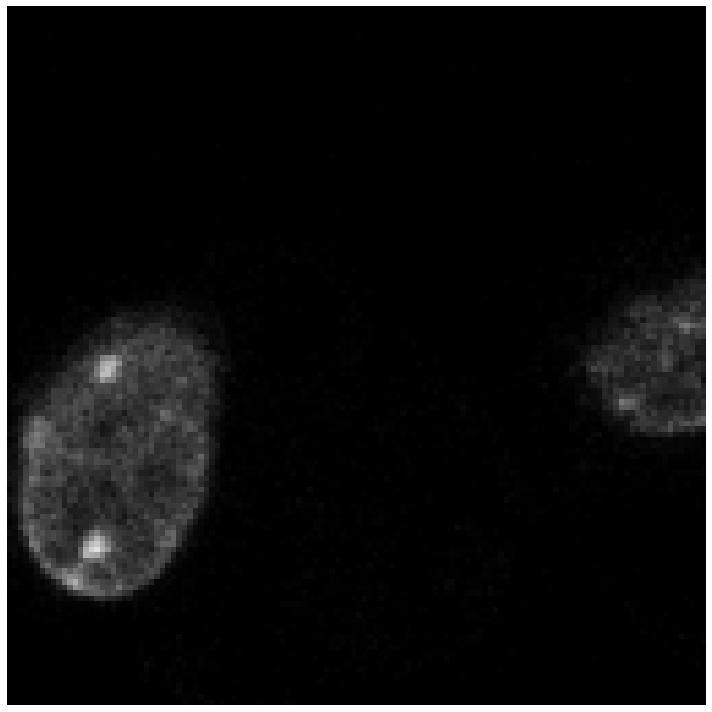

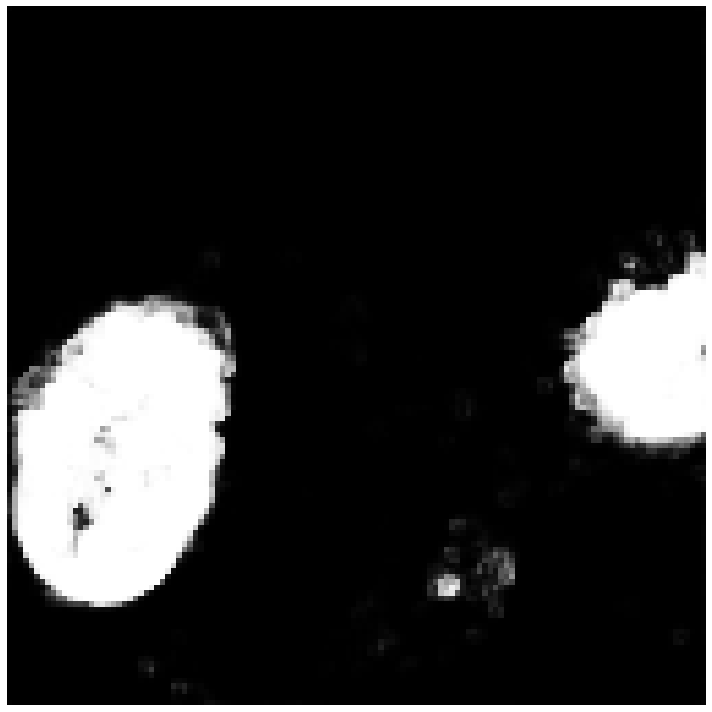

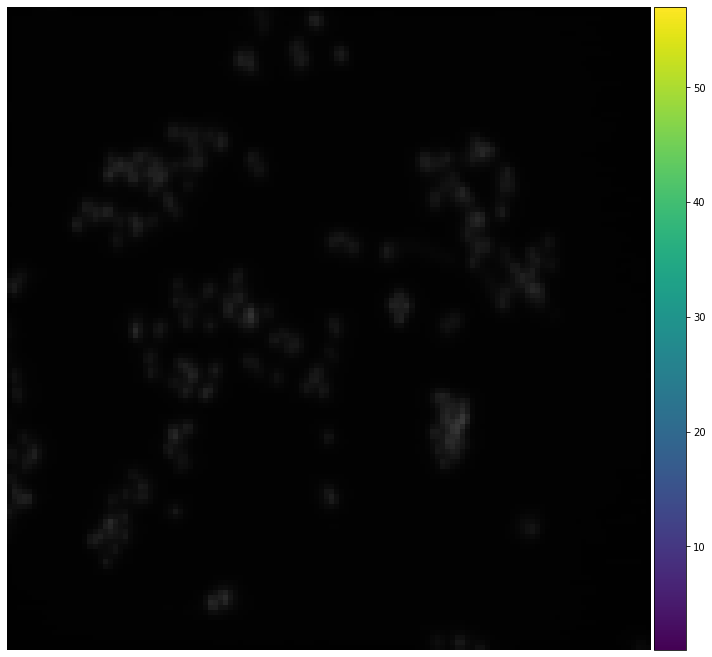

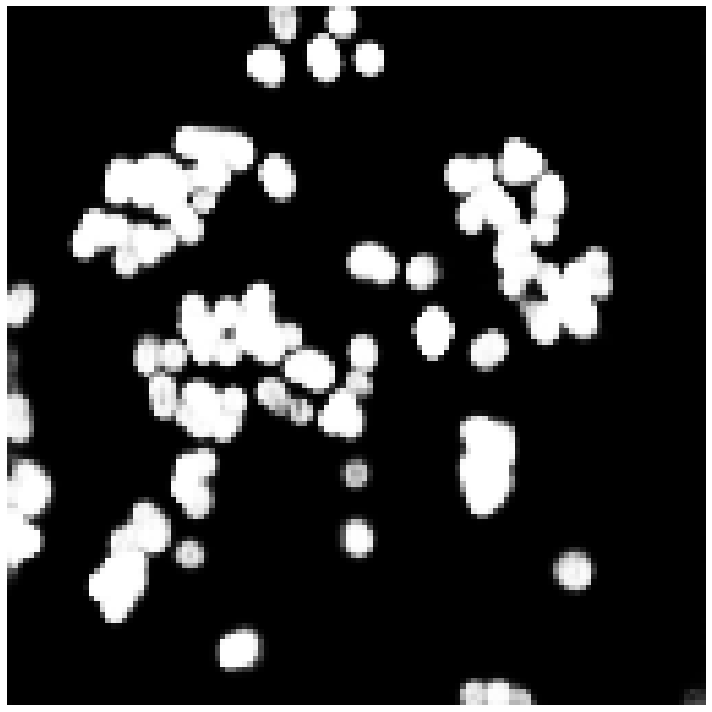

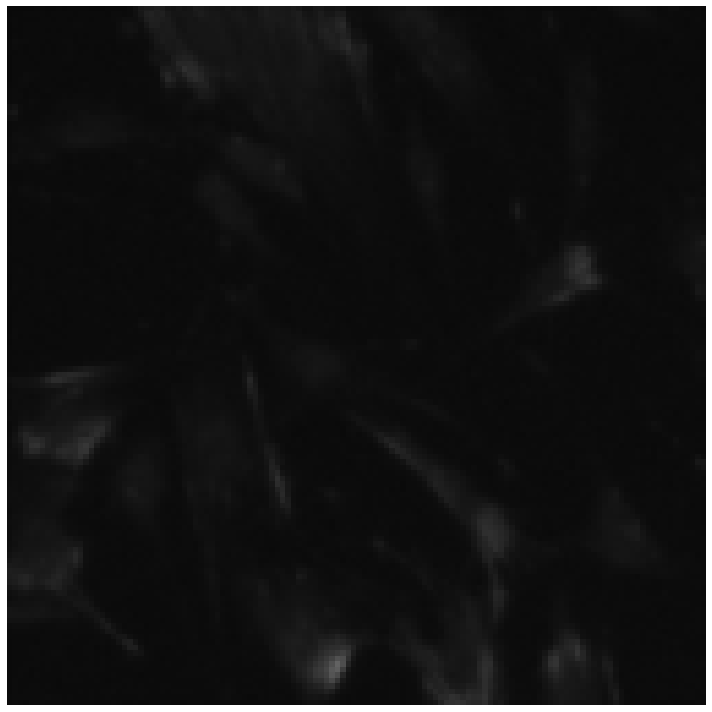

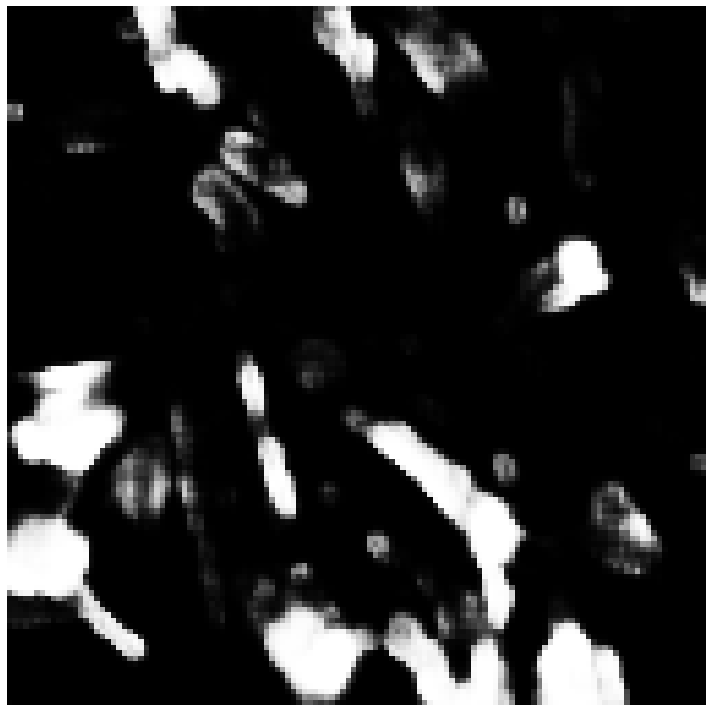

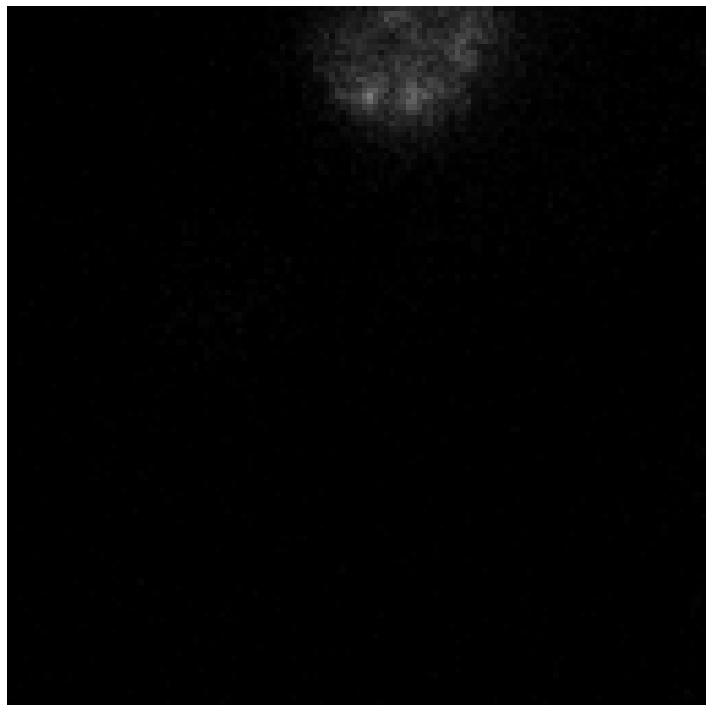

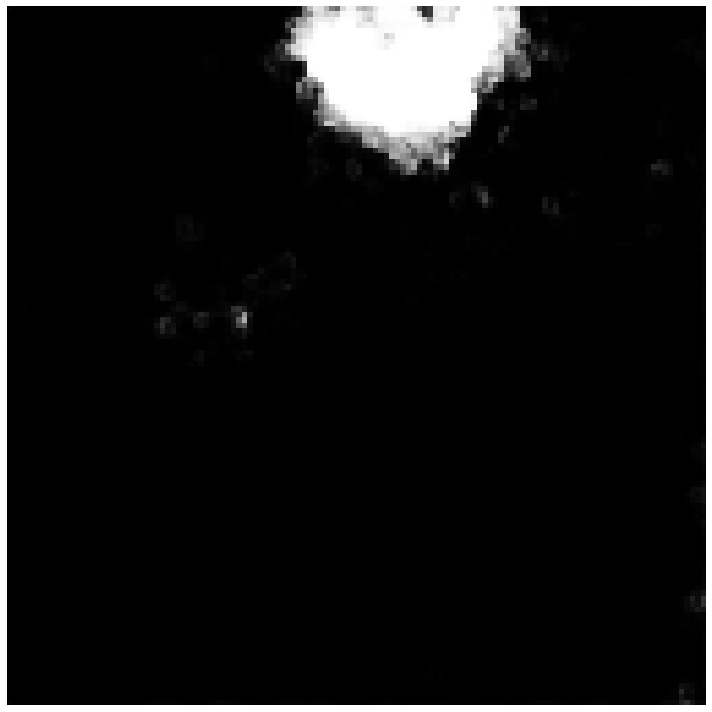

In [16]:
X_valid = np.zeros((len(final_test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for n, id_ in tqdm(enumerate(final_test_ids), total=len(final_test_ids)):
    
    path = FINAL_TEST_PATH + id_

    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')

    if(len(img.shape) >= 3):
        
        img = img[:,:,:IMG_CHANNELS]
    
        #Resize image to match training data
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

        #Append image to numpy array for test dataset
        X_valid[n] = img

print('Done!')

# Validação

preds_Valid = model.predict(X_valid, verbose=1)

for i in range(0, 20):
    
    # Perform a sanity check on some random validation samples
    ix_ = random.randint(0, len(preds_Valid))

    plt.figure(figsize=(10,10))
    plt.axis('off')
    imshow(X_valid[ix_])
    plt.savefig("./resultadosImages/Validacao/ImageValid{}.png".format(i))
    plt.show()

    plt.figure(figsize=(10,10))
    plt.axis('off')
    imshow(np.squeeze(preds_Valid[ix_]), cmap=plt.cm.gray)
    plt.savefig("./resultadosImages/Validacao/figUnetNucleiValid{}.png".format(i))
    plt.show()